In [1]:
!pip install keras-tcn
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.3 MB/s eta 0:00:00


Librerias a Utilizar

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Concatenate, BatchNormalization, LeakyReLU, Dropout
from sklearn.preprocessing import MinMaxScaler
from  sklearn.model_selection import TimeSeriesSplit
from keras.callbacks import EarlyStopping
import tensorflow as tf
import keras_tuner as kt
import os
import warnings
from tensorflow.keras.utils import plot_model
from tcn import TCN
import math as m
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from keras import backend as K
import pdb
import copy

Lectura de Dataset preprocesado

In [4]:
arch='MILSTM'
project_path='/content/drive/MyDrive/Price_Prediction'
df=pd.read_csv(project_path+'/DataCompleta_Resultados/Complete.csv')
df

Date ticker_symbol  p_sentiment        Open        High  \
0     2015-01-02          AAPL     0.766185   27.847500   27.860001   
1     2015-01-02          AMZN     0.506131   15.629000   15.737500   
2     2015-01-02          GOOG     0.846197   26.378078   26.490770   
3     2015-01-02         GOOGL     0.819823   26.629999   26.790001   
4     2015-01-02          MSFT     0.795557   46.660000   47.419998   
...          ...           ...          ...         ...         ...   
7539  2019-12-31          AMZN     0.715115   92.099998   92.663002   
7540  2019-12-31          GOOG     0.656211   66.505501   66.900002   
7541  2019-12-31         GOOGL     0.777357   66.789497   67.032997   
7542  2019-12-31          MSFT     0.683018  156.770004  157.770004   
7543  2019-12-31          TSLA     0.496388   27.000000   28.086000   

             Low       Close     Volume  unrate  psr       m2    dspic  \
0      26.837500   27.332500  212818400     5.7  8.0  11759.1  13224.7   
1      15.348000   15.426000   55664000     5.7  8.0  11759.1  13224.7   
2      26.133251   26.168653   28951268     5.7  8.0  11759.1  13224.7   
3      26.393999   26.477501   26480000     5.7  8.0  11759.1  13224.7   
4      46.540001   46.759998   27913900     5.7  8.0  11759.1  13224.7   
...          ...         ...        ...     ...  ...      ...      ...   
7539   91.611504   92.391998   50130000     3.6  7.3  15416.2  14844.1   
7540   66.454247   66.850998   19236000     3.6  7.3  15416.2  14844.1   
7541   66.606499   66.969498   19514000     3.6  7.3  15416.2  14844.1   
7542  156.449997  157.699997   18369400     3.6  7.3  15416.2  14844.1   
7543   26.805332   27.888666  154285500     3.6  7.3  15416.2  14844.1   

          pce    reer        ir      ffer        tcs    indpro     ccpi  
0     12036.5  106.11  1.881500  0.114839  1069010.0  102.8479  239.811  
1     12036.5  106.11  1.881500  0.114839  1069010.0  102.8479  239.811  
2     12036.5  106.11  1.881500  0.114839  1069010.0  102.8479  239.811  
3     12036.5  106.11  1.881500  0.114839  1069010.0  102.8479  239.811  
4     12036.5  106.11  1.881500  0.114839  1069010.0  102.8479  239.811  
...       ...     ...       ...       ...        ...       ...      ...  
7539  14686.3  116.51  1.862857  1.550968  1458485.0  101.6179  265.651  
7540  14686.3  116.51  1.862857  1.550968  1458485.0  101.6179  265.651  
7541  14686.3  116.51  1.862857  1.550968  1458485.0  101.6179  265.651  
7542  14686.3  116.51  1.862857  1.550968  1458485.0  101.6179  265.651  
7543  14686.3  116.51  1.862857  1.550968  1458485.0  101.6179  265.651  

[7544 rows x 19 columns]

In [5]:
# Lista de fechas a eliminar
fechas_a_eliminar = ['2015-03-26', '2015-07-08', '2015-10-12', '2015-12-17']
df = df[~df['Date'].isin(fechas_a_eliminar)]
df

Date ticker_symbol  p_sentiment        Open        High  \
0     2015-01-02          AAPL     0.766185   27.847500   27.860001   
1     2015-01-02          AMZN     0.506131   15.629000   15.737500   
2     2015-01-02          GOOG     0.846197   26.378078   26.490770   
3     2015-01-02         GOOGL     0.819823   26.629999   26.790001   
4     2015-01-02          MSFT     0.795557   46.660000   47.419998   
...          ...           ...          ...         ...         ...   
7539  2019-12-31          AMZN     0.715115   92.099998   92.663002   
7540  2019-12-31          GOOG     0.656211   66.505501   66.900002   
7541  2019-12-31         GOOGL     0.777357   66.789497   67.032997   
7542  2019-12-31          MSFT     0.683018  156.770004  157.770004   
7543  2019-12-31          TSLA     0.496388   27.000000   28.086000   

             Low       Close     Volume  unrate  psr       m2    dspic  \
0      26.837500   27.332500  212818400     5.7  8.0  11759.1  13224.7   
1      15.348000   15.426000   55664000     5.7  8.0  11759.1  13224.7   
2      26.133251   26.168653   28951268     5.7  8.0  11759.1  13224.7   
3      26.393999   26.477501   26480000     5.7  8.0  11759.1  13224.7   
4      46.540001   46.759998   27913900     5.7  8.0  11759.1  13224.7   
...          ...         ...        ...     ...  ...      ...      ...   
7539   91.611504   92.391998   50130000     3.6  7.3  15416.2  14844.1   
7540   66.454247   66.850998   19236000     3.6  7.3  15416.2  14844.1   
7541   66.606499   66.969498   19514000     3.6  7.3  15416.2  14844.1   
7542  156.449997  157.699997   18369400     3.6  7.3  15416.2  14844.1   
7543   26.805332   27.888666  154285500     3.6  7.3  15416.2  14844.1   

          pce    reer        ir      ffer        tcs    indpro     ccpi  
0     12036.5  106.11  1.881500  0.114839  1069010.0  102.8479  239.811  
1     12036.5  106.11  1.881500  0.114839  1069010.0  102.8479  239.811  
2     12036.5  106.11  1.881500  0.114839  1069010.0  102.8479  239.811  
3     12036.5  106.11  1.881500  0.114839  1069010.0  102.8479  239.811  
4     12036.5  106.11  1.881500  0.114839  1069010.0  102.8479  239.811  
...       ...     ...       ...       ...        ...       ...      ...  
7539  14686.3  116.51  1.862857  1.550968  1458485.0  101.6179  265.651  
7540  14686.3  116.51  1.862857  1.550968  1458485.0  101.6179  265.651  
7541  14686.3  116.51  1.862857  1.550968  1458485.0  101.6179  265.651  
7542  14686.3  116.51  1.862857  1.550968  1458485.0  101.6179  265.651  
7543  14686.3  116.51  1.862857  1.550968  1458485.0  101.6179  265.651  

[7524 rows x 19 columns]

Se utiliza solo un segmento del DataSet para pruebas

In [6]:
dfCorto = df.head(1002)
dfCorto

Date ticker_symbol  p_sentiment       Open       High        Low  \
0     2015-01-02          AAPL     0.766185  27.847500  27.860001  26.837500   
1     2015-01-02          AMZN     0.506131  15.629000  15.737500  15.348000   
2     2015-01-02          GOOG     0.846197  26.378078  26.490770  26.133251   
3     2015-01-02         GOOGL     0.819823  26.629999  26.790001  26.393999   
4     2015-01-02          MSFT     0.795557  46.660000  47.419998  46.540001   
...          ...           ...          ...        ...        ...        ...   
1007  2015-09-02          AMZN     0.734782  25.254499  25.542999  24.886000   
1008  2015-09-02          GOOG     0.707943  30.279499  30.716999  29.985500   
1009  2015-09-02         GOOGL     0.688165  31.900000  32.252998  31.532000   
1010  2015-09-02          MSFT     0.839926  42.360001  43.380001  41.880001   
1011  2015-09-02          TSLA     0.632574  16.353333  16.525333  15.985333   

          Close     Volume  unrate  psr        m2    dspic      pce    reer  \
0     27.332500  212818400     5.7  8.0  11759.10  13224.7  12036.5  106.11   
1     15.426000   55664000     5.7  8.0  11759.10  13224.7  12036.5  106.11   
2     26.168653   28951268     5.7  8.0  11759.10  13224.7  12036.5  106.11   
3     26.477501   26480000     5.7  8.0  11759.10  13224.7  12036.5  106.11   
4     46.759998   27913900     5.7  8.0  11759.10  13224.7  12036.5  106.11   
...         ...        ...     ...  ...       ...      ...      ...     ...   
1007  25.527500   74142000     5.0  7.4  12135.95  13392.0  12356.4  113.34   
1008  30.716999   51512000     5.0  7.4  12135.95  13392.0  12356.4  113.34   
1009  32.245499   37630000     5.0  7.4  12135.95  13392.0  12356.4  113.34   
1010  43.360001   37671500     5.0  7.4  12135.95  13392.0  12356.4  113.34   
1011  16.512667   69438000     5.0  7.4  12135.95  13392.0  12356.4  113.34   

            ir      ffer        tcs    indpro     ccpi  
0     1.881500  0.114839  1069010.0  102.8479  239.811  
1     1.881500  0.114839  1069010.0  102.8479  239.811  
2     1.881500  0.114839  1069010.0  102.8479  239.811  
3     1.881500  0.114839  1069010.0  102.8479  239.811  
4     1.881500  0.114839  1069010.0  102.8479  239.811  
...        ...       ...        ...       ...      ...  
1007  2.172857  0.136000  1171147.0  100.5680  243.316  
1008  2.172857  0.136000  1171147.0  100.5680  243.316  
1009  2.172857  0.136000  1171147.0  100.5680  243.316  
1010  2.172857  0.136000  1171147.0  100.5680  243.316  
1011  2.172857  0.136000  1171147.0  100.5680  243.316  

[1002 rows x 19 columns]

In [ ]:
a=dfCorto['ticker_symbol']=='AAPL'
a.sum()

167

In [ ]:
b=dfCorto['ticker_symbol']=='AMZN'
b.sum()

167

In [ ]:
c=dfCorto['ticker_symbol']=='GOOG'
c.sum()

167

In [ ]:
d=dfCorto['ticker_symbol']=='GOOGL'
d.sum()

167

In [ ]:
e=dfCorto['ticker_symbol']=='MSFT'
e.sum()

167

In [ ]:
f=dfCorto['ticker_symbol']=='TSLA'
f.sum()

167

Separacion de Empresas en diccionario

In [6]:
metric_labels=['Testing-MSE','Validation-MSE','testing-MAE','validation-MAE','testing-mape','validation-mape','testing-RMSE','validation-RMSE', 'testing-MPE','validation-MPE']
metrics_df=pd.DataFrame()
metrics_df['Metrics']=metric_labels
std_metrics_df=pd.DataFrame()
std_metrics_df['Metrics']=metric_labels

mse_t_p, mae_t_p, mape_t_p, rmse_t_p, mpe_t_p, mse_v_p, mae_v_p, mape_v_p, rmse_v_p, mpe_v_p =[], [], [], [], [], [], [], [], [], []

overall_mse_train, overall_mse_val, overall_std_train, overall_std_val=[], [], [], []

# Cálculo de métricas para cada canal de entrada y salida
t_mses, v_mses, t_maes, v_maes, t_mapes, v_mapes, t_rmses, v_rmses, t_mpes, v_mpes = [], [], [], [], [], [], [], [], [], []

metrics=[]

#save dataframe as csv
metrics_df.to_csv(project_path+f'/Resultados/metricas/{arch}_metrics.csv',index=False)
std_metrics_df.to_csv(project_path+f'/Resultados/metricas/{arch}_std_metrics.csv',index=False)

Creacion de las secuencias de entrada y salida de cada empresa (ventana de tiempo)

In [7]:
df_dict={}

for key in df['ticker_symbol'].unique():
    df_dict[key]=df[df['ticker_symbol']==key]
    df_dict[key]=df_dict[key].drop(columns=['ticker_symbol'])
    df_dict[key]=df_dict[key].sort_values(by=['Date']).reset_index(drop=True)

# Lista para almacenar los datos de entrada para cada canal
X_channels, y_channels = [], []

keys=df_dict.keys()
keys_list=list(keys)

scalers=[]
scaler_d=[]
# Preprocesamiento de datos y almacenamiento en las listas X_channels y y_channels
for ticker_symbol in keys_list:
    #pdb.set_trace()
    df = df_dict[ticker_symbol]#.copy()
    df = df[['Date','p_sentiment', 'Open', 'High', 'Low', 'Volume', 'unrate', 'psr', 'm2', 'dspic', 'pce', 'reer', 'ir', 'ffer', 'tcs', 'indpro', 'ccpi', 'Close']]

    dates = pd.to_datetime(df['Date'])
    cols=list(df)[1:]

    df_for_training = df[cols].astype(float)

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df_for_training)
    scaler_d.append(scaled_data)
    scalers.append(scaler)

    n_future = 1
    n_past = 7
    X_ticker, y_ticker  = [], []

    # División de datos en entrada y salida para cada canal
    for i in range(n_past, len(scaled_data) - n_future + 1):
        X_ticker.append(scaled_data[i - n_past:i, 0:df_for_training.shape[1]])
        y_ticker.append(scaled_data[i + n_future - 1:i + n_future, len(cols)-1])

    X_channels.append(np.array(X_ticker))
    y_channels.append(np.array(y_ticker))

In [8]:
def mape(y_true, y_pred):
    return 100 * np.mean(np.abs(y_pred - y_true) / (np.abs(y_true)))
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true))
def mse(y_true, y_pred):
    return np.mean(np.square(y_pred - y_true))
def rmse(y_true, y_pred):
    return np.sqrt(mse(y_true,y_pred))
def mpe(y_true, y_pred):
    return np.mean((y_pred - y_true) / y_true) * 100

Funcion que contiene implementacion del modelo MILSTM

In [9]:
def build_model(hp):
    hp_units = hp.Int('units', min_value=2, max_value=240, step=2)

    # hp_units_1 = hp.Int('units_1', min_value=2, max_value=240, step=14)
    # hp_units_2 = hp.Int('units_2', min_value=2, max_value=240, step=14)
    # hp_alpha = hp.Choice('alpha', values=[0.01, 0.1, 0.2, 0.5])

    X_tensors = []
    for i in range(len(X_channels)):
        X_tensors.append((X_channels[i]))

    model = Sequential()

    combined_input = Concatenate(axis=2)(X_tensors)

    model.add(LSTM(units=hp_units,activation='relu', input_shape=(X_channels[0].shape[1], X_channels[0].shape[2]*6)))

    model.add(BatchNormalization())

    #model.add(Dense(units=hp_units_2, activation=LeakyReLU(alpha=hp_alpha)))

    model.add(Dropout(0.2))

    model.add(Dense(units=y_channels[0].shape[1]*6))

    model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-4), loss='mse')

    return model

In [11]:
# Copiar X_channels
X_channels_copy = copy.deepcopy(X_channels)

# Copiar y_channels
y_channels_copy = copy.deepcopy(y_channels)

# Concatenar los tensores en X_channels a lo largo del eje de características (axis=2)
x_channels_combined = tf.concat(X_channels_copy, axis=2)

# Concatenar los tensores en y_channels a lo largo del eje de características (axis=1)
y_channels_combined = tf.concat(y_channels_copy, axis=1)


Calculo de Hiperparametros y CV

In [12]:
tf.keras.utils.set_random_seed(42)
# Instanciar el callback EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=10)

# Definir el project_name incluyendo tanto el ticker como el canal de cada entrada
ticker = [f'{i}' for i in range(len(X_channels))]

# Instanciar el optimizador de hiperparámetros Kerastuner
tuner = kt.RandomSearch(build_model,
                     objective='val_loss',
                     directory=project_path + f'/Modelos/{arch}_Tuning',
                     project_name=''.join(ticker) + f'_{arch}_tuningFSAA')

# Buscar los mejores hiperparámetros para el modelo
tuner.search(x_channels_combined, y_channels_combined, epochs=1000, validation_split=0.2, callbacks=[early_stop])

# Obtener los mejores hiperparámetros
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

early_stop=EarlyStopping(monitor='val_loss',patience=20)
dir=project_path+f'/Graficas/{arch}_'+''.join(ticker)
tscv = TimeSeriesSplit(n_splits=10)

x_train, x_val = [], []
y_train, y_val = [], []
X_tmpA, X_testA = [], []
y_tmpA, y_testA = [], []

val_losses = []
train_losses = []

for channel_index in range(len(X_channels)):
  X_channel = X_channels[channel_index]
  y_channel = y_channels[channel_index]
  # Dividir los datos en conjuntos de entrenamiento y validación
  for train_index, test_index in tscv.split(X_channel):

    X_tmp, X_test = X_channel[train_index], X_channel[test_index]
    y_tmp, y_test= y_channel[train_index], y_channel[test_index]
    #Usar para test
    X_tmpA.append(X_tmp)
    X_testA.append(X_test)
    y_tmpA.append(y_tmp)
    y_testA.append(y_test)

    val_split = int(len(train_index) * 0.8)  # Adjust the validation split percentage as needed

    x_train.append(X_tmp[:val_split])
    x_val.append(X_tmp[val_split:])
    y_train.append(y_tmp[:val_split])
    y_val.append(y_tmp[val_split:])

Reloading Tuner from /content/drive/MyDrive/Price_Prediction/Modelos/MILSTM_Tuning/012345_MILSTM_tuningFSAA/tuner0.json


In [13]:
# Obtener un resumen de los resultados de la búsqueda
tuner.results_summary()
best_hps_values = best_hps.values
print("Mejores hiperparámetros encontrados:")
for key in best_hps_values.keys():
    print(f"{key}: {best_hps.get(key)}")

Results summary
Results in /content/drive/MyDrive/Price_Prediction/Modelos/MILSTM_Tuning/012345_MILSTM_tuningFSAA
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0027 summary
Hyperparameters:
units: 56
Score: 0.010044433176517487

Trial 0006 summary
Hyperparameters:
units: 14
Score: 0.010295391082763672

Trial 0119 summary
Hyperparameters:
units: 240
Score: 0.013127672486007214

Trial 0016 summary
Hyperparameters:
units: 34
Score: 0.016398467123508453

Trial 0042 summary
Hyperparameters:
units: 86
Score: 0.020023372024297714

Trial 0020 summary
Hyperparameters:
units: 42
Score: 0.02101849392056465

Trial 0103 summary
Hyperparameters:
units: 208
Score: 0.0215107761323452

Trial 0069 summary
Hyperparameters:
units: 140
Score: 0.030418243259191513

Trial 0024 summary
Hyperparameters:
units: 50
Score: 0.03260895609855652

Trial 0092 summary
Hyperparameters:
units: 186
Score: 0.0328657440841198
Mejores hiperparámetros encontrados:
units: 56


preparacion de datos para entrenar en el modelo MILSTM

In [14]:
# Crear una lista de listas para agrupar por forma
x_train_, x_val_ = [], []
y_train_, y_val_ = [], []

# Iterar sobre cada array en la lista y agruparlos por forma
for array in x_train:
    forma = array.shape
    encontrado = False
    for sublist in x_train_:
        if sublist[0].shape == forma:
            sublist.append(array)
            encontrado = True
            break
    if not encontrado:
        x_train_.append([array])

# Imprimir la lista de listas
for sublist in x_train_:
    forma = sublist[0].shape
    print(f"Forma x_train_: {forma}, Número de arrays: {len(sublist)}")


# Iterar sobre cada array en la lista y agruparlos por forma
for array in y_train:
    forma = array.shape
    encontrado = False
    for sublist in y_train_:
        if sublist[0].shape == forma:
            sublist.append(array)
            encontrado = True
            break
    if not encontrado:
        y_train_.append([array])

# Imprimir la lista de listas
for sublist in y_train_:
    forma = sublist[0].shape
    print(f"Forma y_train_: {forma}, Número de arrays: {len(sublist)}")


# Iterar sobre cada array en la lista y agruparlos por forma
for array in x_val:
    forma = array.shape
    encontrado = False
    for sublist in x_val_:
        if sublist[0].shape == forma:
            sublist.append(array)
            encontrado = True
            break
    if not encontrado:
        x_val_.append([array])

# Imprimir la lista de listas
for sublist in x_val_:
    forma = sublist[0].shape
    print(f"Forma x_val_: {forma}, Número de arrays: {len(sublist)}")


# Iterar sobre cada array en la lista y agruparlos por forma
for array in y_val:
    forma = array.shape
    encontrado = False
    for sublist in y_val_:
        if sublist[0].shape == forma:
            sublist.append(array)
            encontrado = True
            break
    if not encontrado:
        y_val_.append([array])

# Imprimir la lista de listas
for sublist in y_val_:
    forma = sublist[0].shape
    print(f"Forma y_val_: {forma}, Número de arrays: {len(sublist)}")

# Iterar sobre cada array en la lista y agruparlos por forma
X_testA_=[]
temp_sublistA = []  # Lista temporal para contener cada 10 elementos
for i, array in enumerate(X_testA, start=1):
    temp_sublistA.append(array)
    if i % 6 == 0:  # Cuando tengamos 10 elementos en la lista temporal
        X_testA_.append(temp_sublistA)
        temp_sublistA = []  # Reiniciar la lista temporal para el próximo grupo de 10 elementos

# Si quedan elementos en la lista temporal, agrégelos a X_testA_
if temp_sublistA:
    X_testA_.append(temp_sublistA)

for sublist in X_testA_:
    forma = sublist[0].shape
    print(f"Forma X_testA_: {forma}, Número de arrays: {len(sublist)}")

# Iterar sobre cada array en la lista y agruparlos por forma
y_testA_=[]
temp_sublistB = []  # Lista temporal para contener cada 10 elementos
for i, array in enumerate(y_testA, start=1):
    temp_sublistB.append(array)
    if i % 6 == 0:  # Cuando tengamos 10 elementos en la lista temporal
        y_testA_.append(temp_sublistB)
        temp_sublistB = []  # Reiniciar la lista temporal para el próximo grupo de 10 elementos

# Si quedan elementos en la lista temporal, agrégelos a X_testA_
if temp_sublistB:
    y_testA_.append(temp_sublistB)

for sublist in y_testA_:
    forma = sublist[0].shape
    print(f"Forma y_testA_: {forma}, Número de arrays: {len(sublist)}")

Forma x_train_: (93, 7, 17), Número de arrays: 6
Forma x_train_: (184, 7, 17), Número de arrays: 6
Forma x_train_: (274, 7, 17), Número de arrays: 6
Forma x_train_: (364, 7, 17), Número de arrays: 6
Forma x_train_: (455, 7, 17), Número de arrays: 6
Forma x_train_: (545, 7, 17), Número de arrays: 6
Forma x_train_: (636, 7, 17), Número de arrays: 6
Forma x_train_: (726, 7, 17), Número de arrays: 6
Forma x_train_: (816, 7, 17), Número de arrays: 6
Forma x_train_: (907, 7, 17), Número de arrays: 6
Forma y_train_: (93, 1), Número de arrays: 6
Forma y_train_: (184, 1), Número de arrays: 6
Forma y_train_: (274, 1), Número de arrays: 6
Forma y_train_: (364, 1), Número de arrays: 6
Forma y_train_: (455, 1), Número de arrays: 6
Forma y_train_: (545, 1), Número de arrays: 6
Forma y_train_: (636, 1), Número de arrays: 6
Forma y_train_: (726, 1), Número de arrays: 6
Forma y_train_: (816, 1), Número de arrays: 6
Forma y_train_: (907, 1), Número de arrays: 6
Forma x_val_: (24, 7, 17), Número de array

In [15]:
x_train_combined=[]
y_train_combined=[]
x_val_combined=[]
y_val_combined=[]

x_testA_combined=[]
y_testA_combined=[]
# Concatenar los datos de entrada de los seis canales
# Se concatenan los datos de entrada a lo largo del eje de características

for i in range(len(x_train_)):
  x_train_combined.append(Concatenate(axis=2)(x_train_[i]))

for i in range(len(y_train_)):
  y_train_combined.append(Concatenate(axis=1)(y_train_[i]))

for i in range(len(x_val_)):
  x_val_combined.append(Concatenate(axis=2)(x_val_[i]))

for i in range(len(y_val_)):
  y_val_combined.append(Concatenate(axis=1)(y_val_[i]))

for i in range(len(X_testA_)):
  x_testA_combined.append(Concatenate(axis=2)(X_testA_[i]))

for i in range(len(y_testA_)):
  y_testA_combined.append(Concatenate(axis=1)(y_testA_[i]))

In [16]:
x_train_combined[0].shape, y_train_combined[0].shape, x_val_combined[0].shape, y_val_combined[0].shape, x_testA_combined[1].shape, y_testA_combined[1].shape

(TensorShape([93, 7, 102]),
 TensorShape([93, 6]),
 TensorShape([24, 7, 102]),
 TensorShape([24, 6]),
 TensorShape([113, 7, 102]),
 TensorShape([113, 6]))

Entrenamiento, prediccion por cada Fold (10)

Fold_0 Started


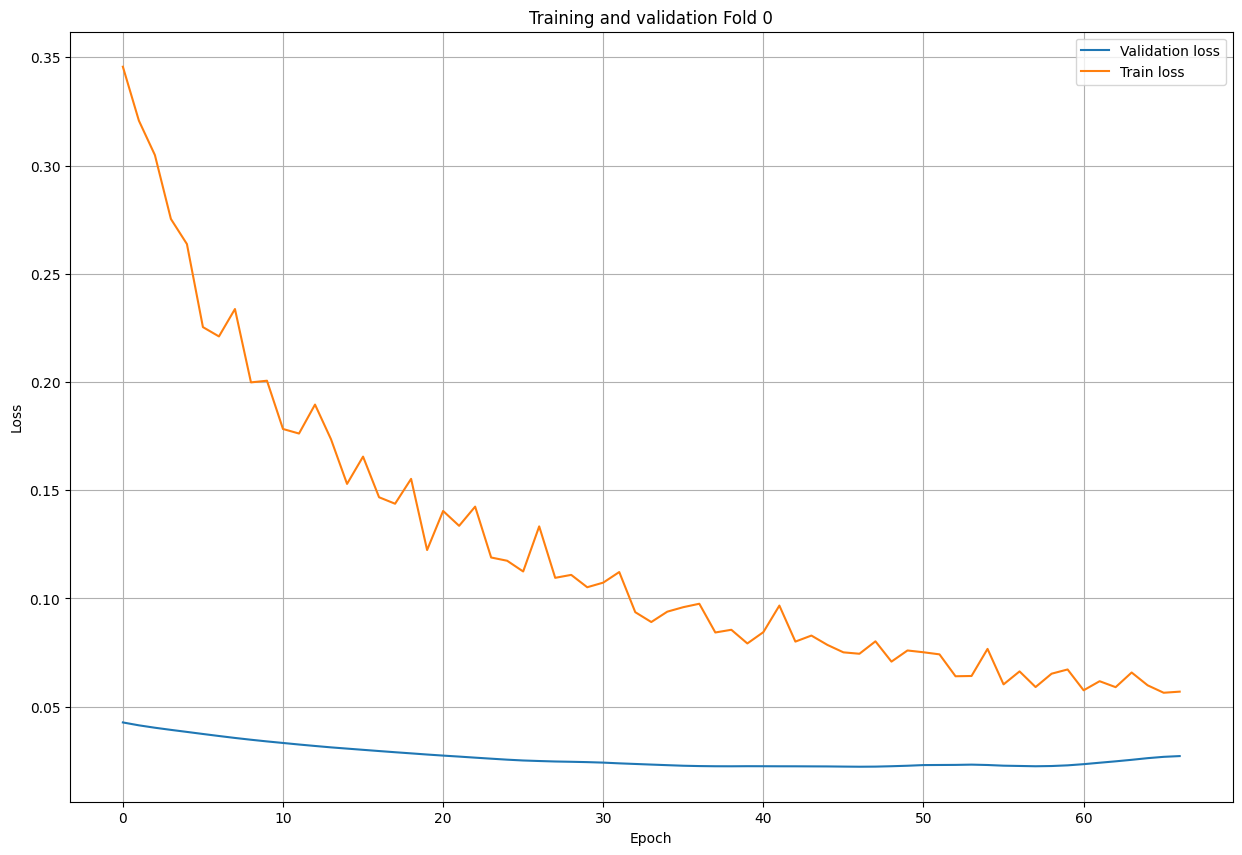

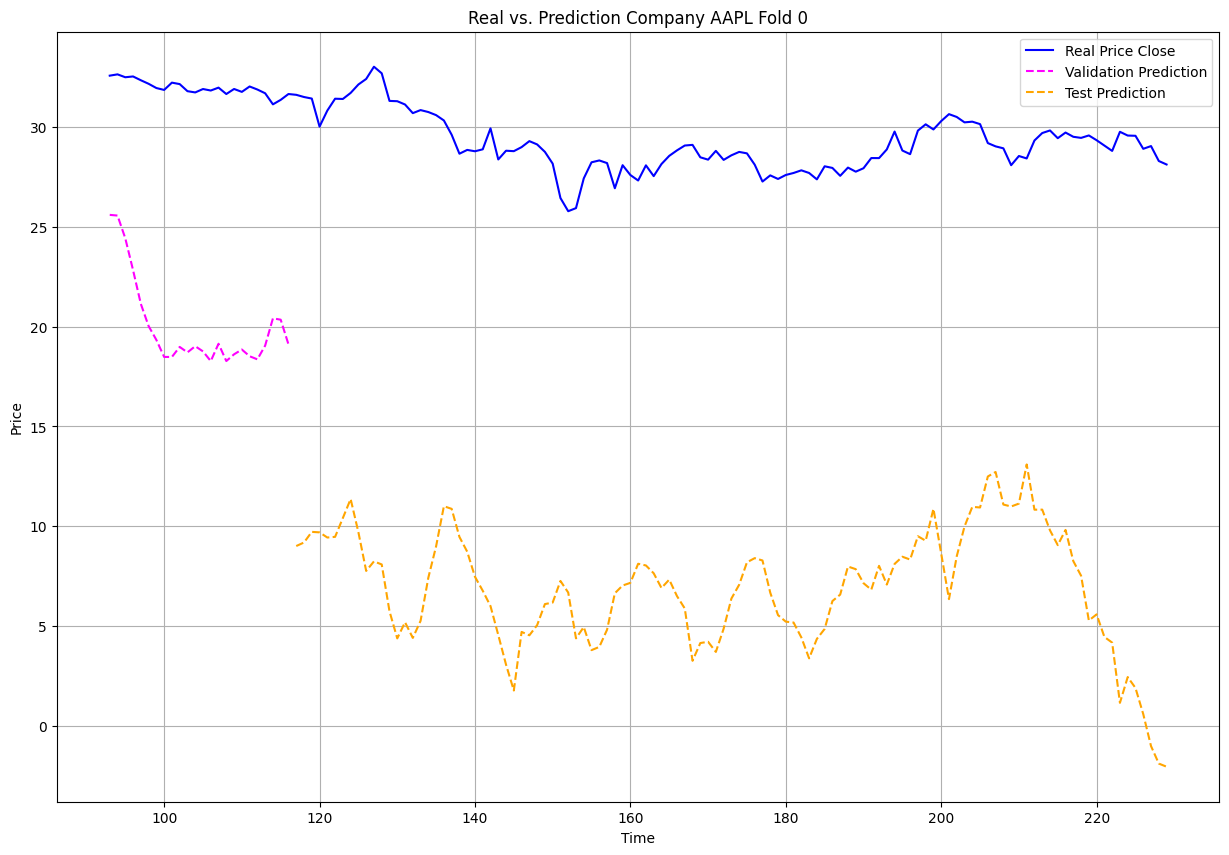

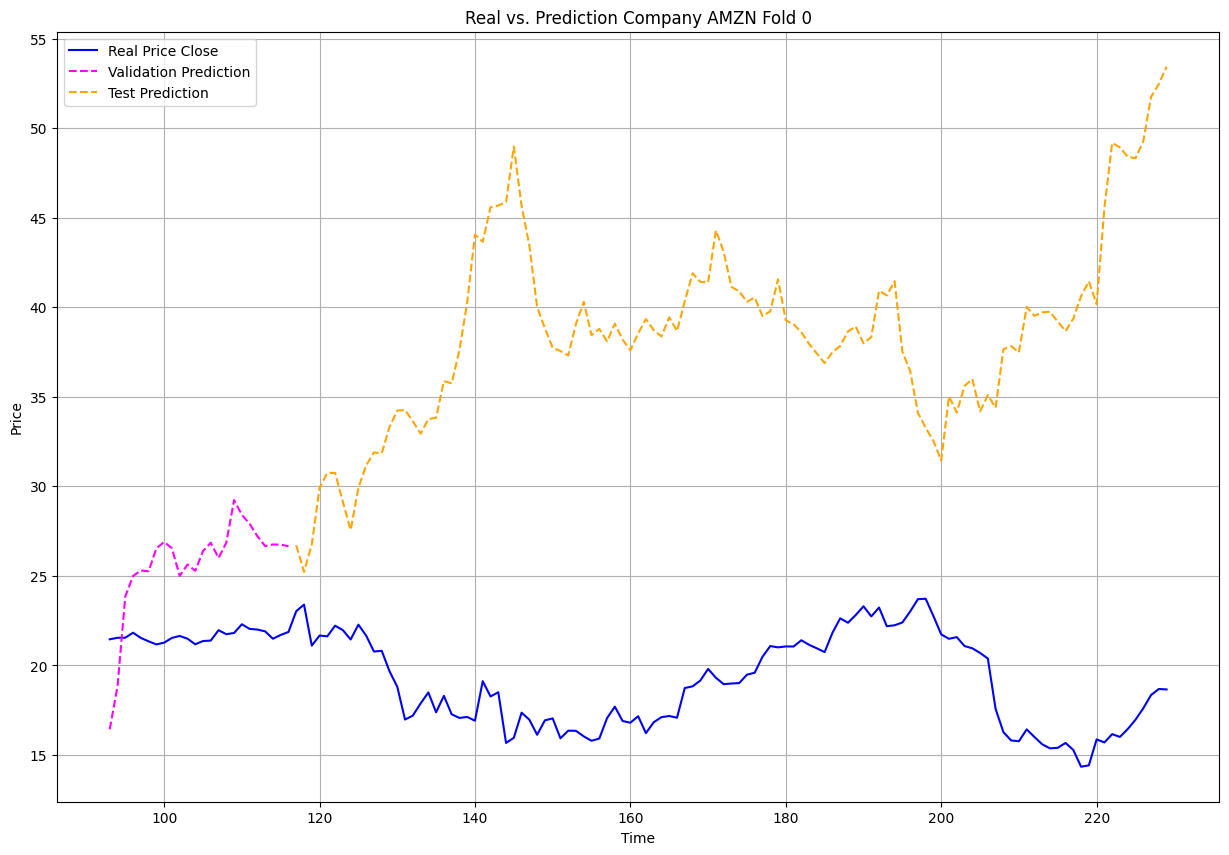

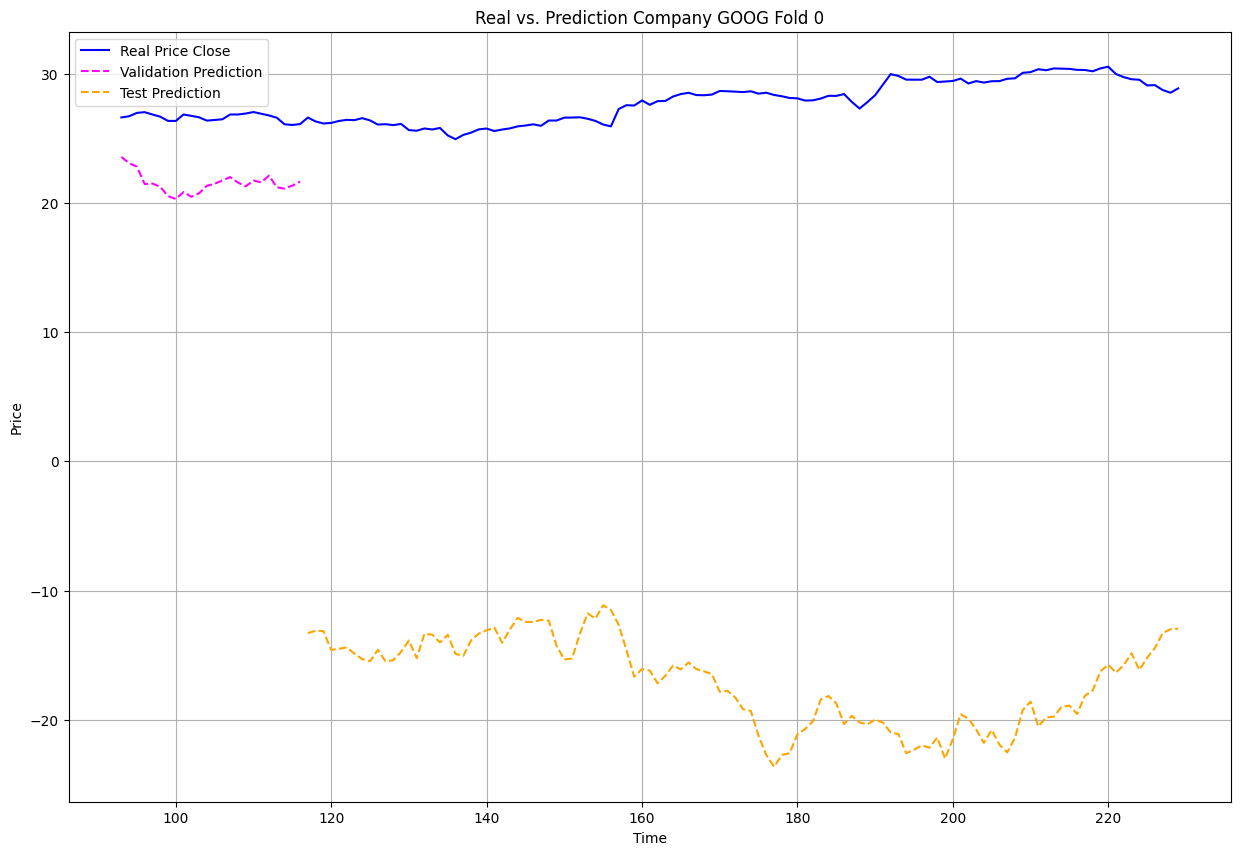

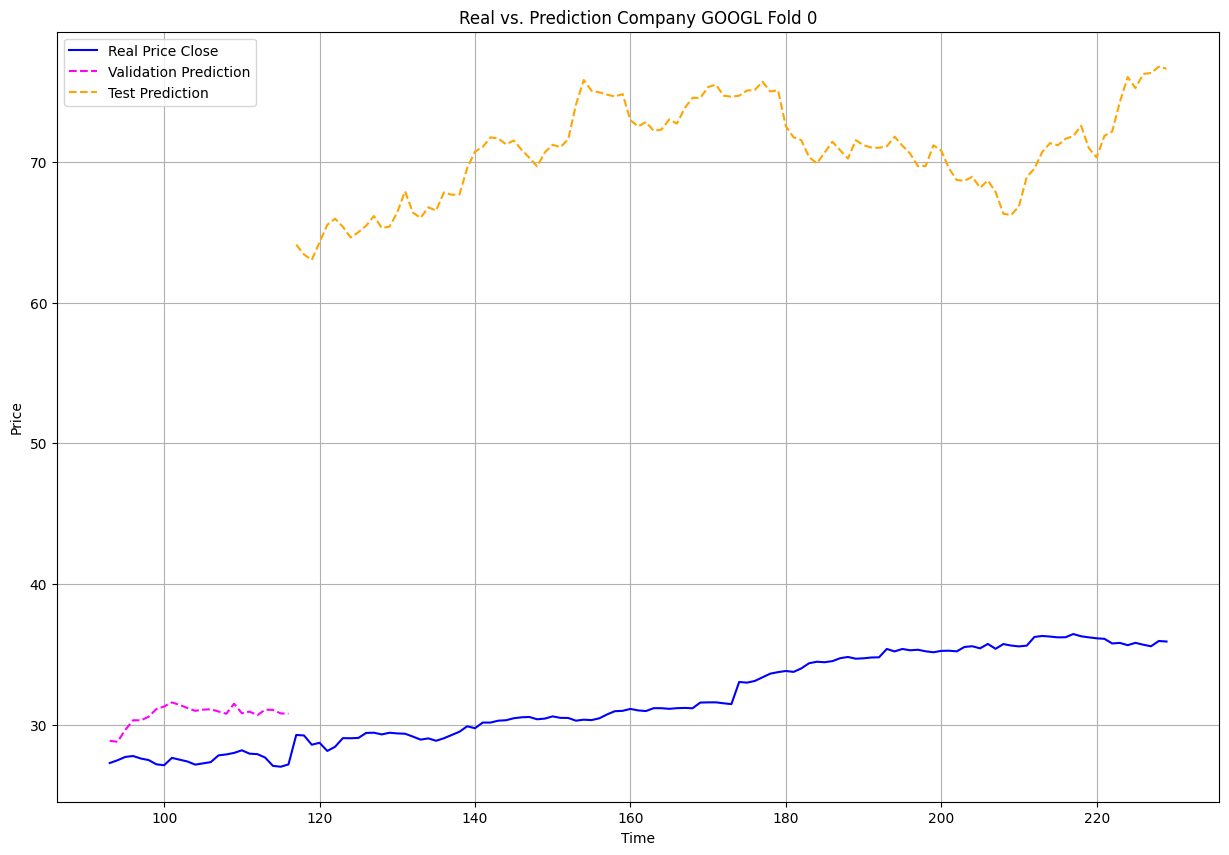

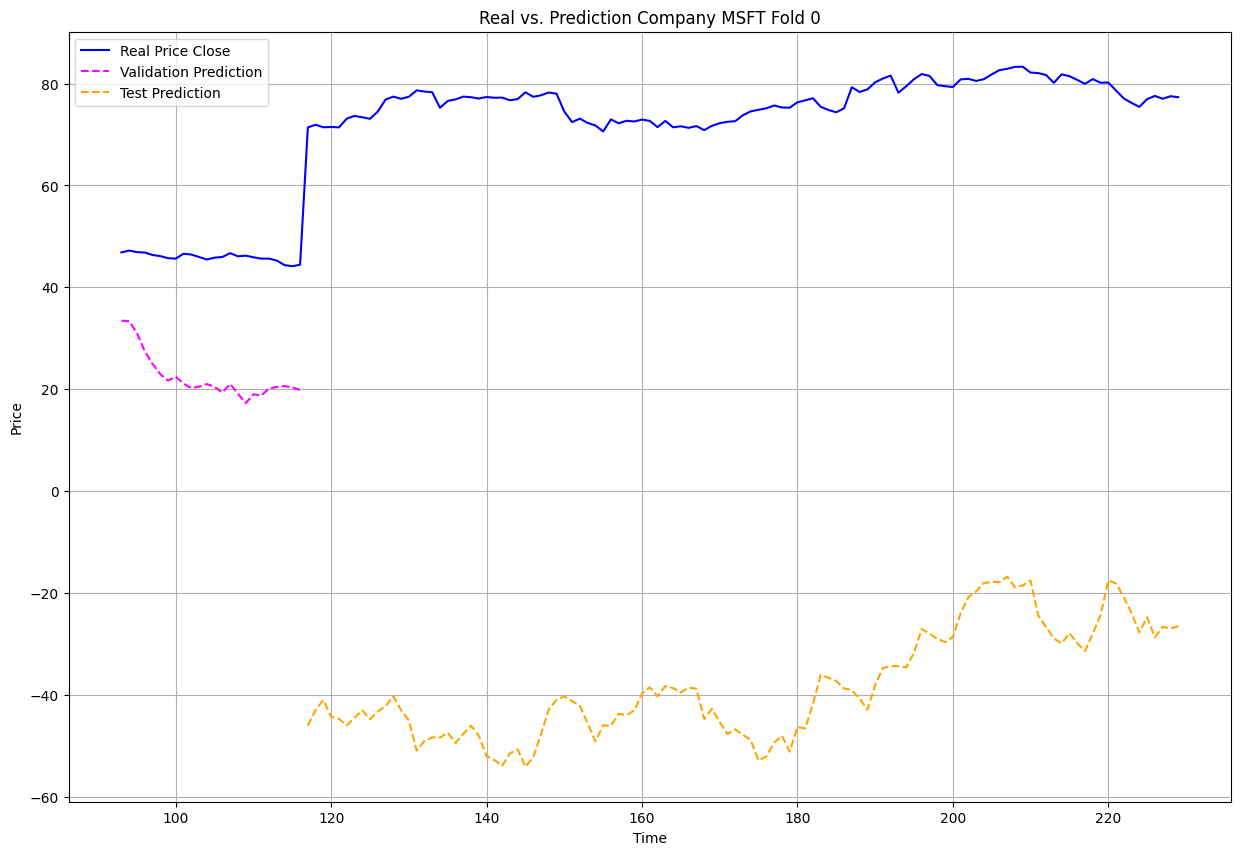

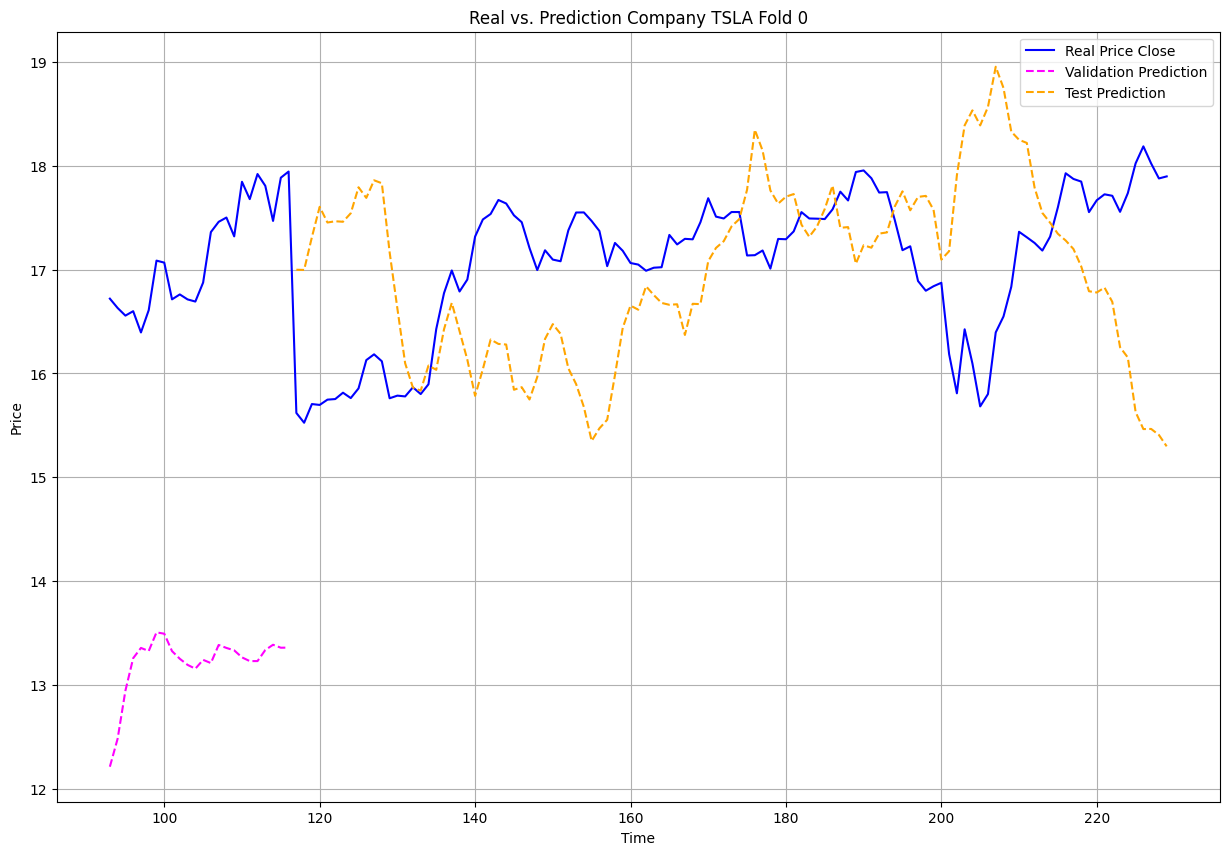

Fold_0 Done
Fold_1 Started


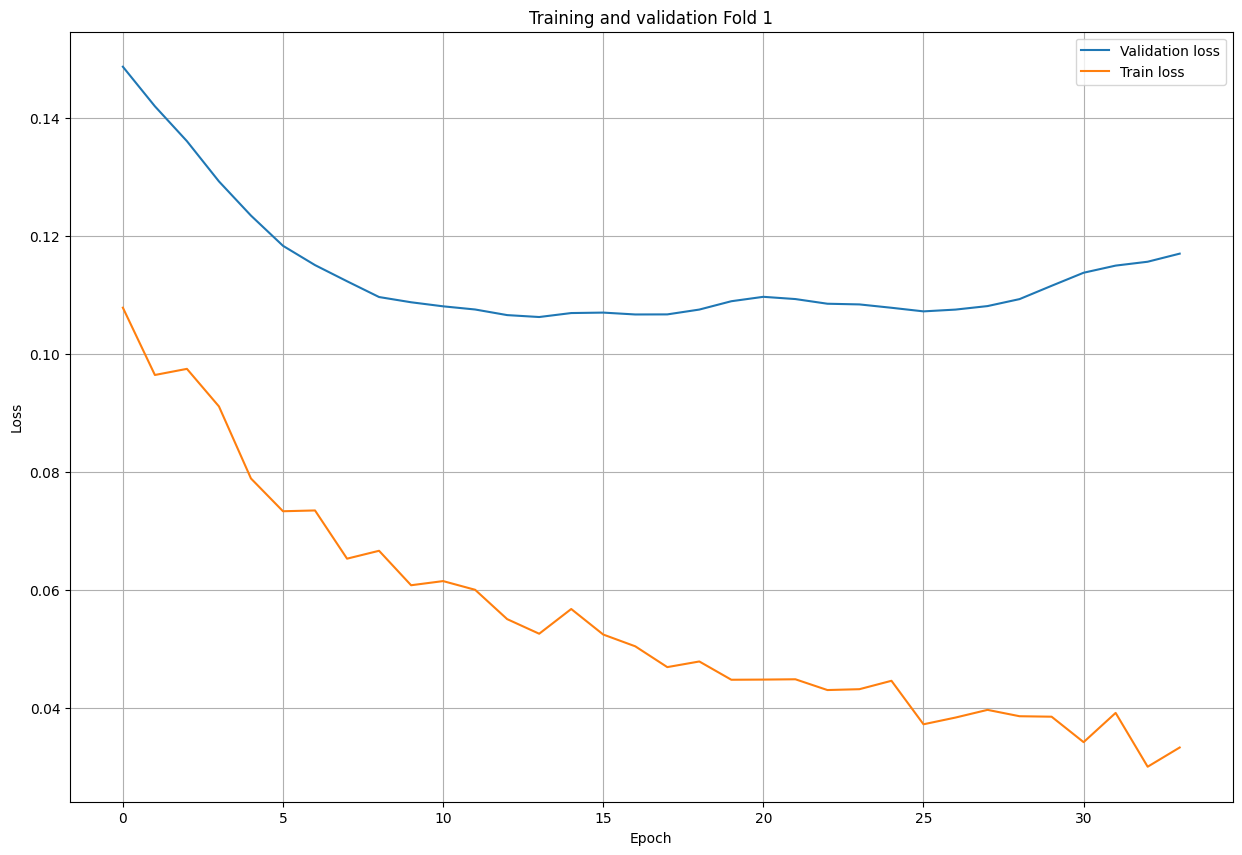

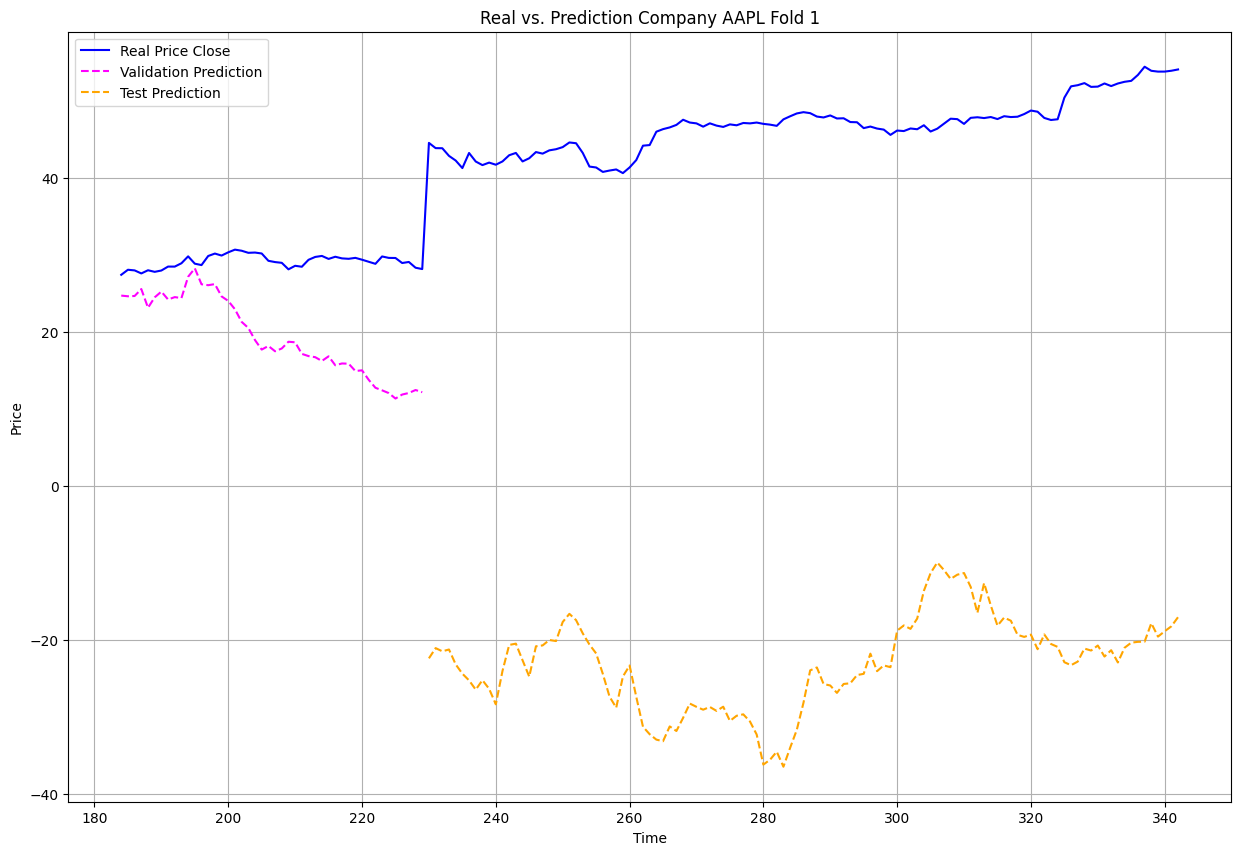

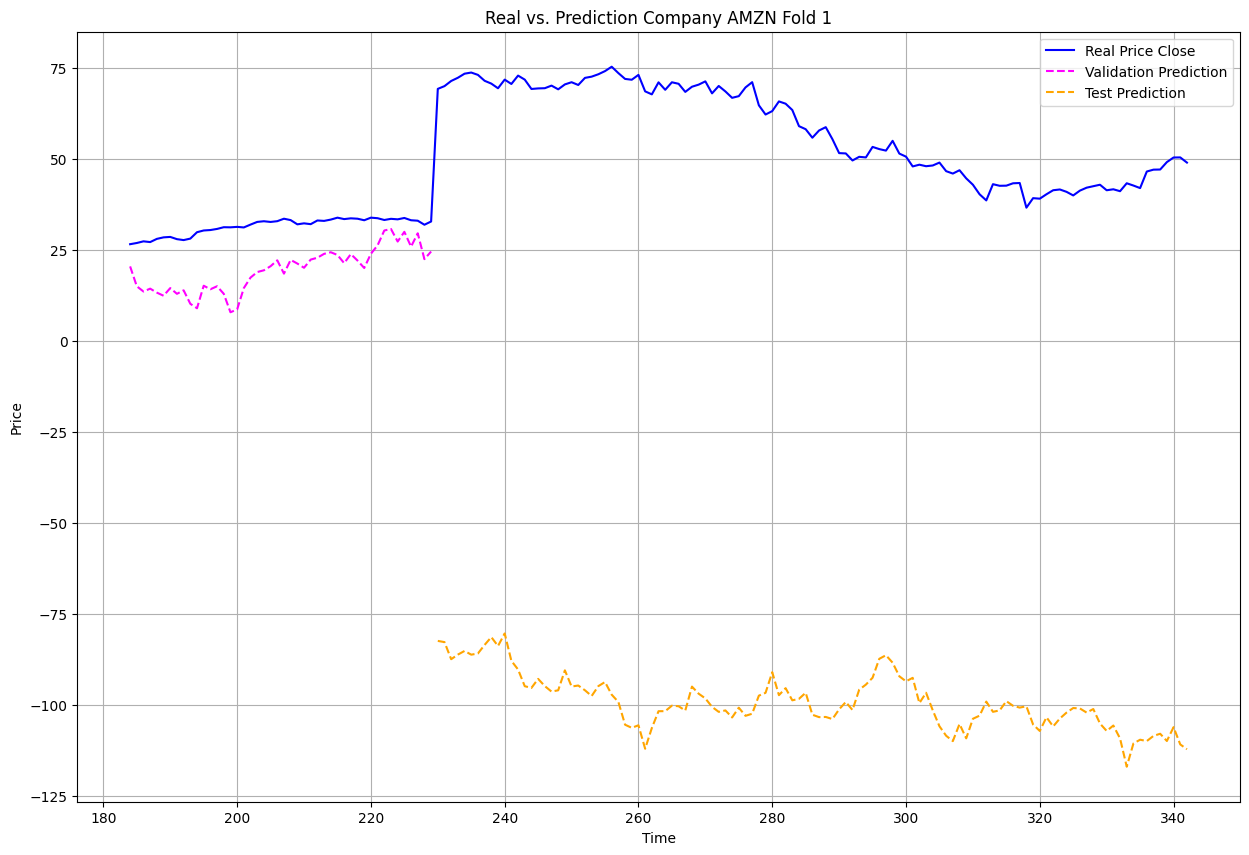

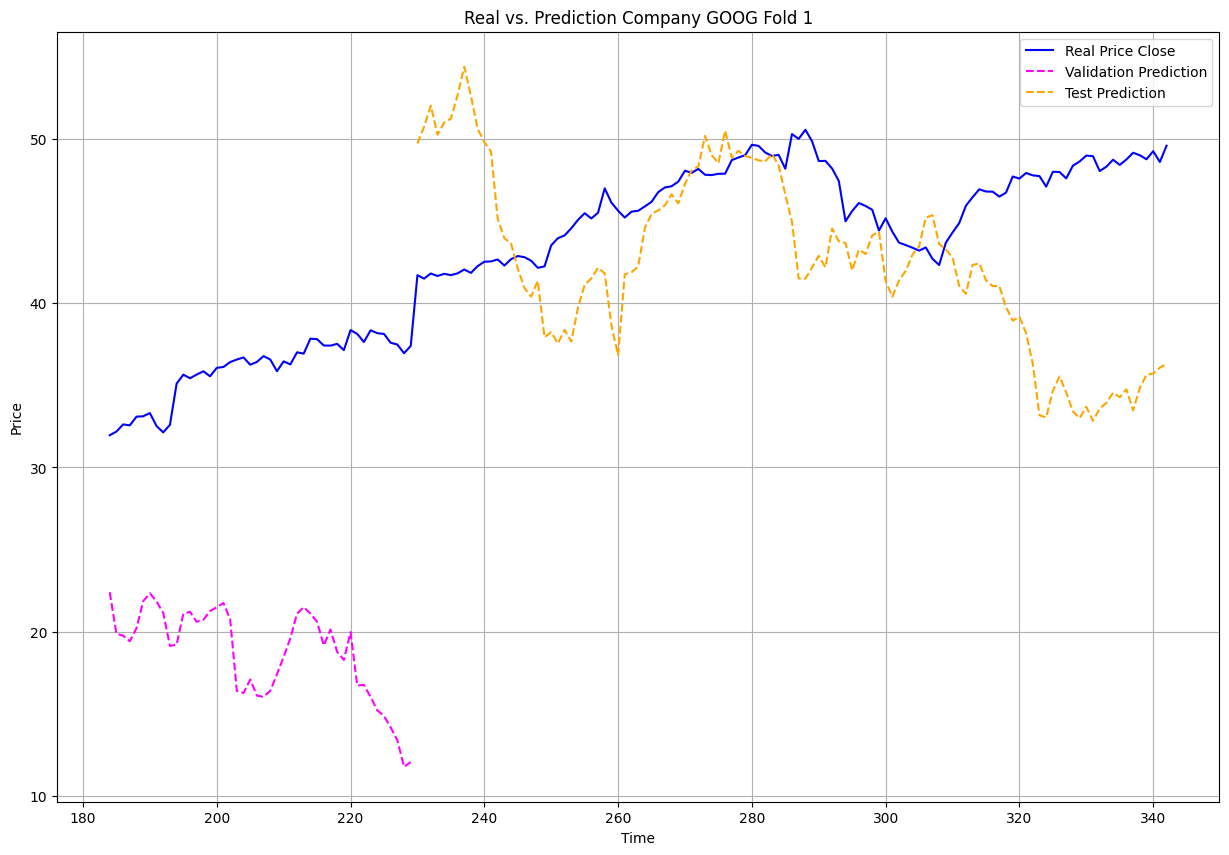

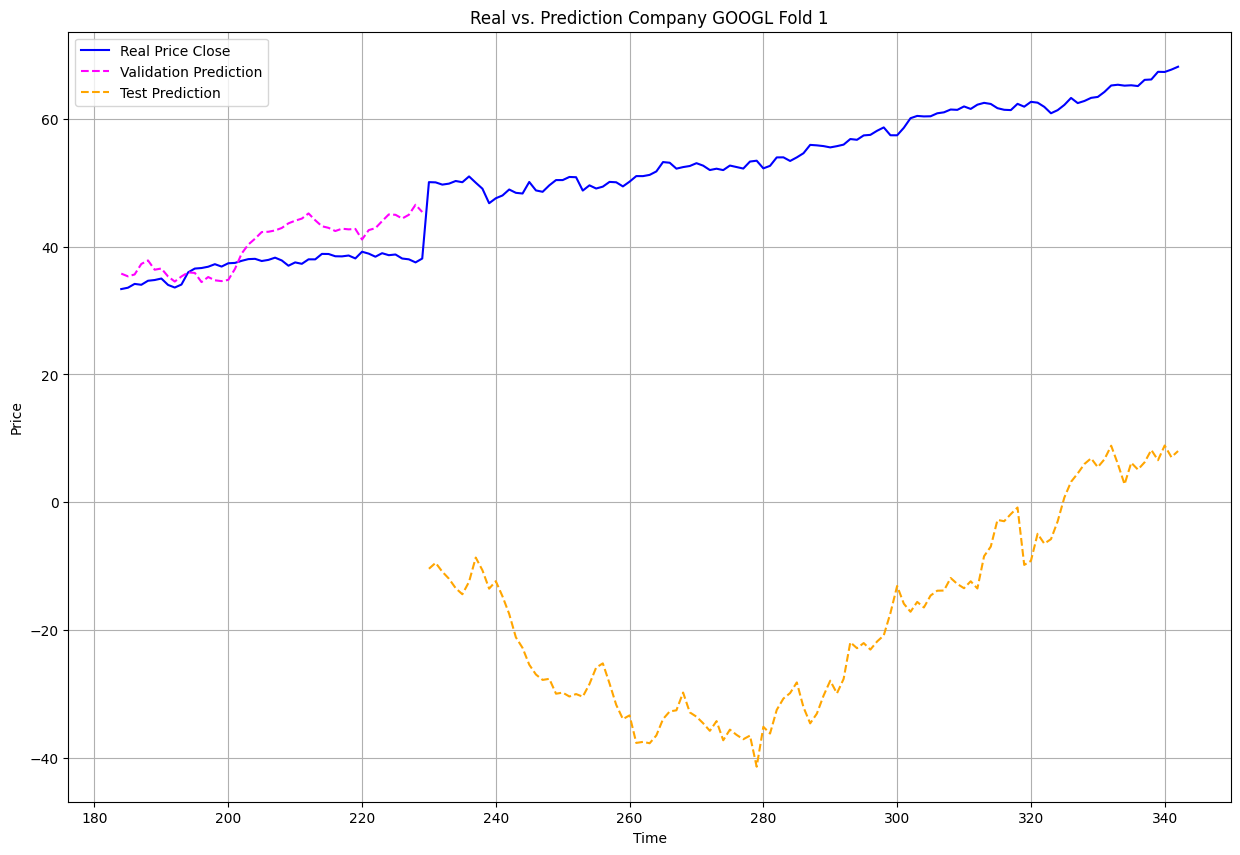

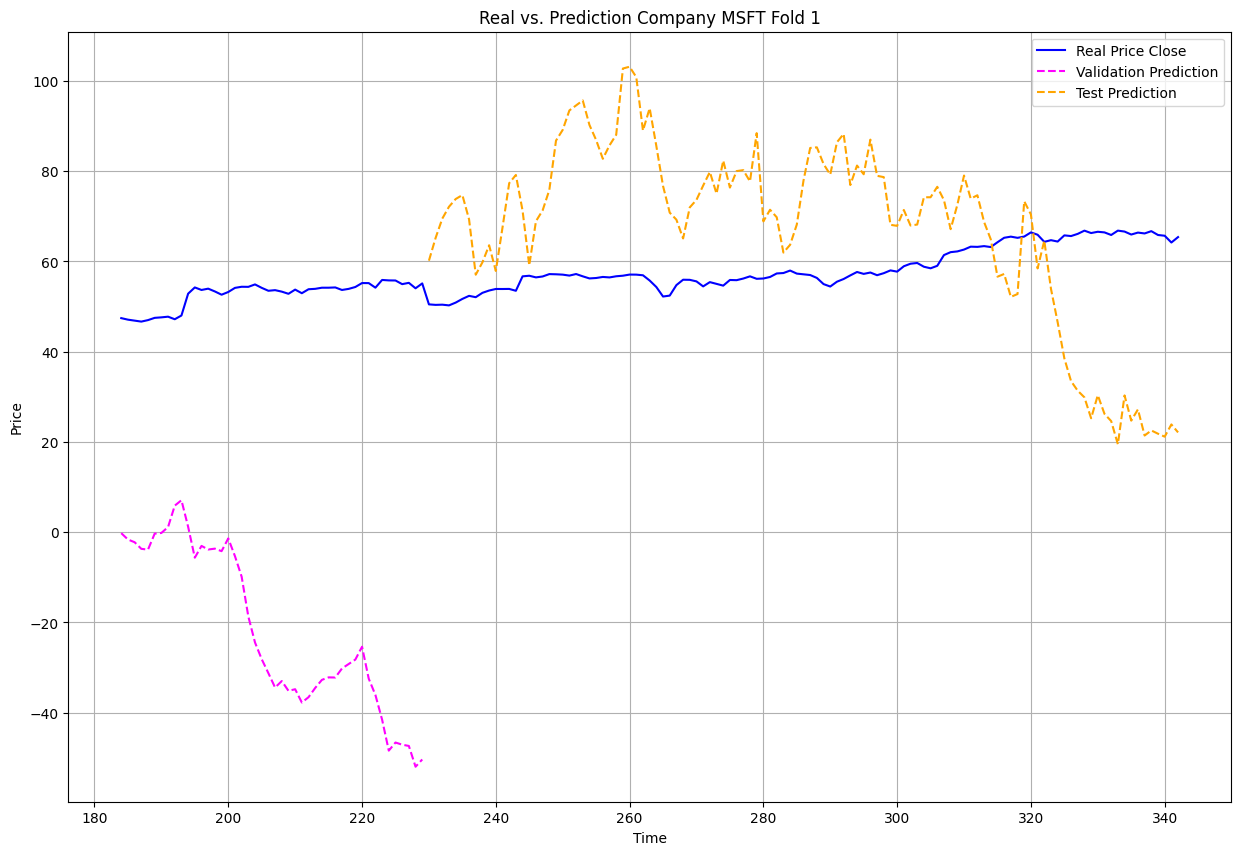

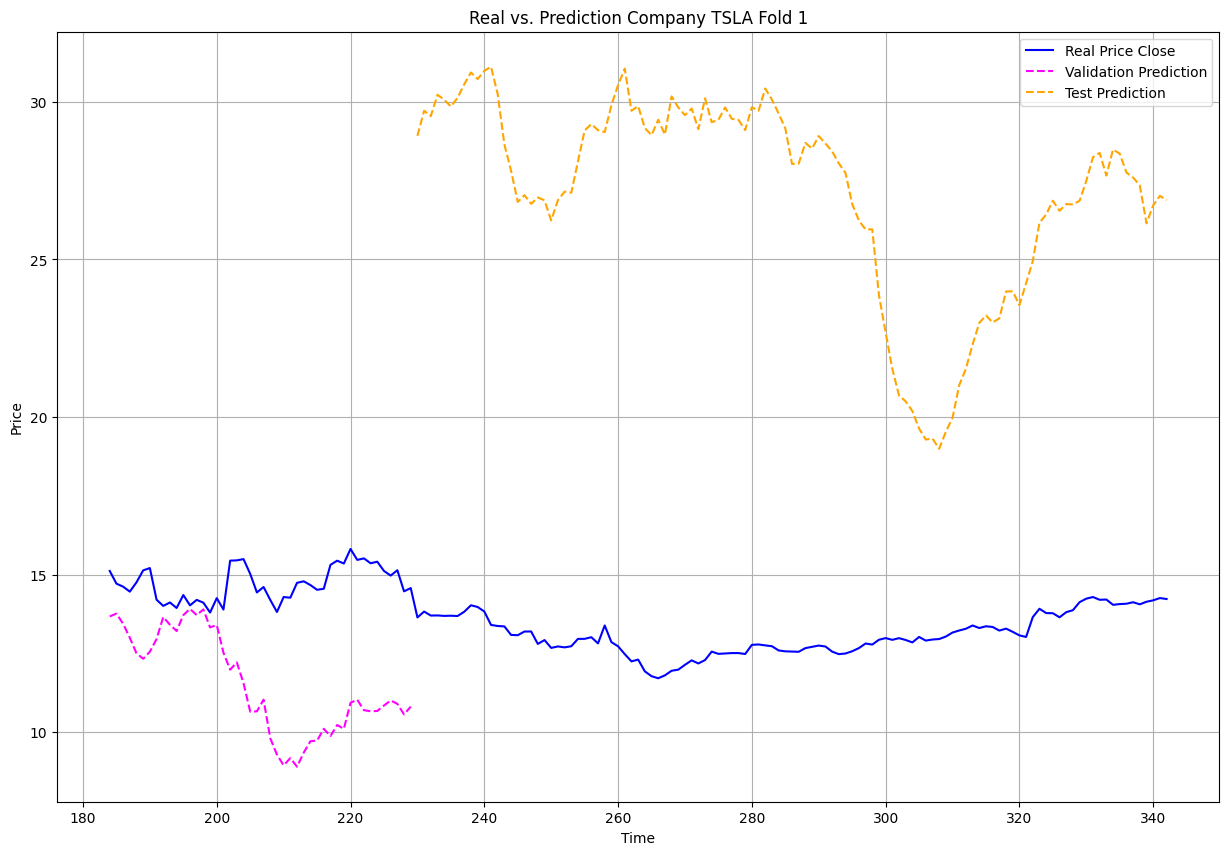

Fold_1 Done
Fold_2 Started


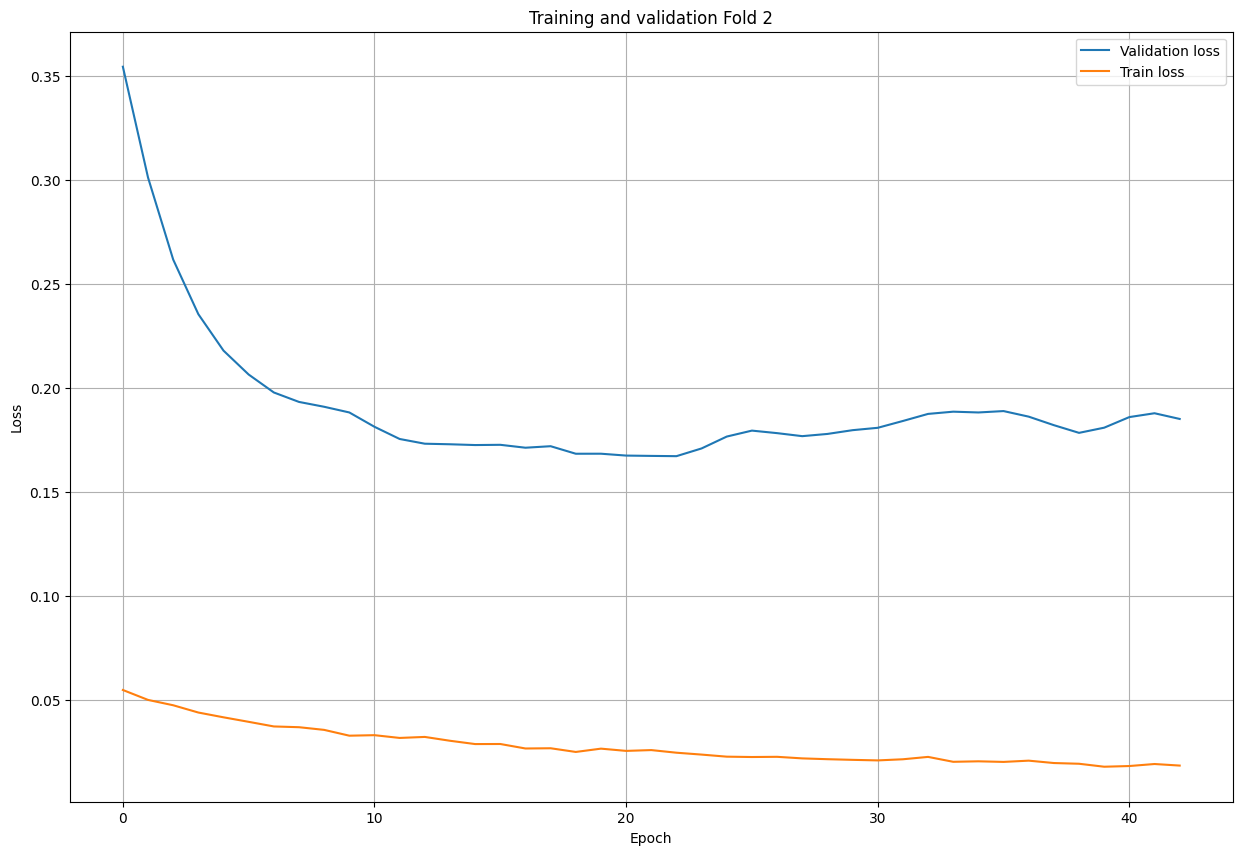

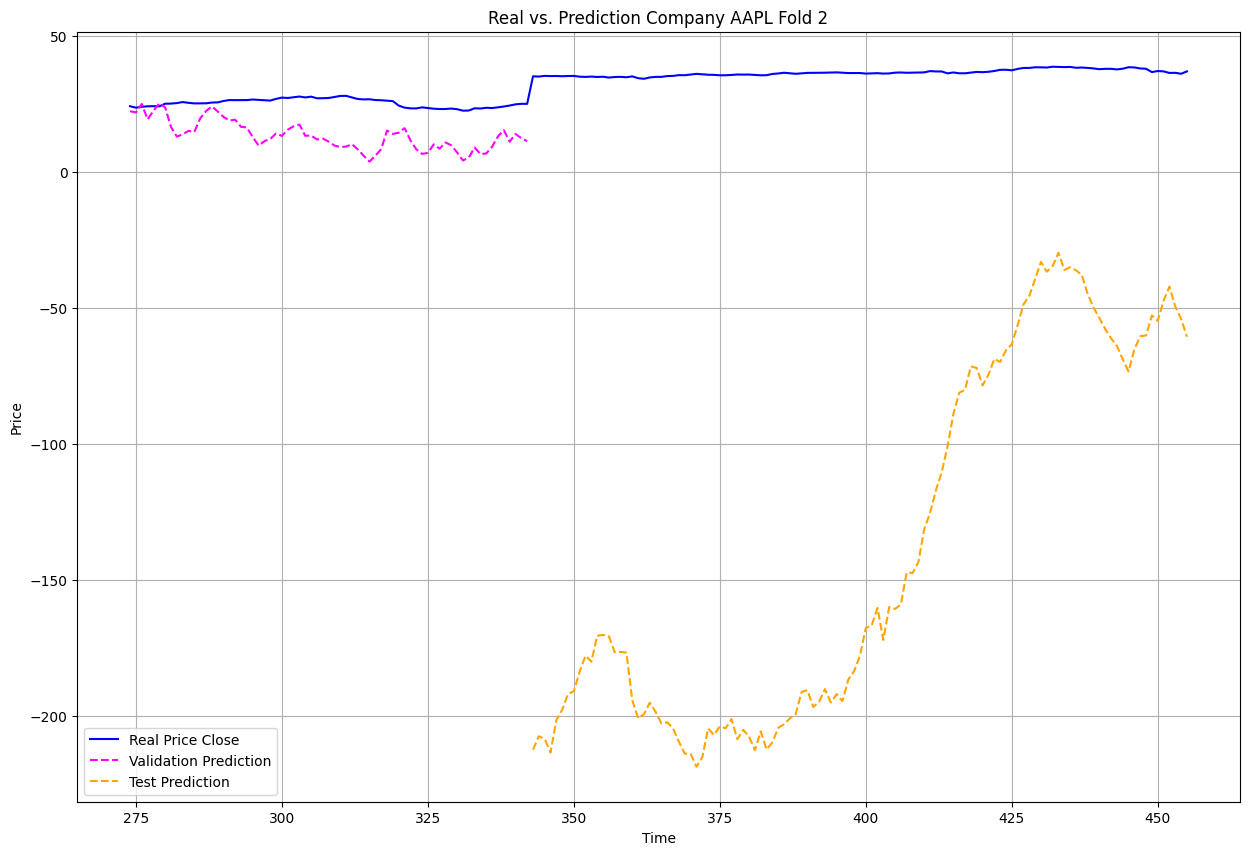

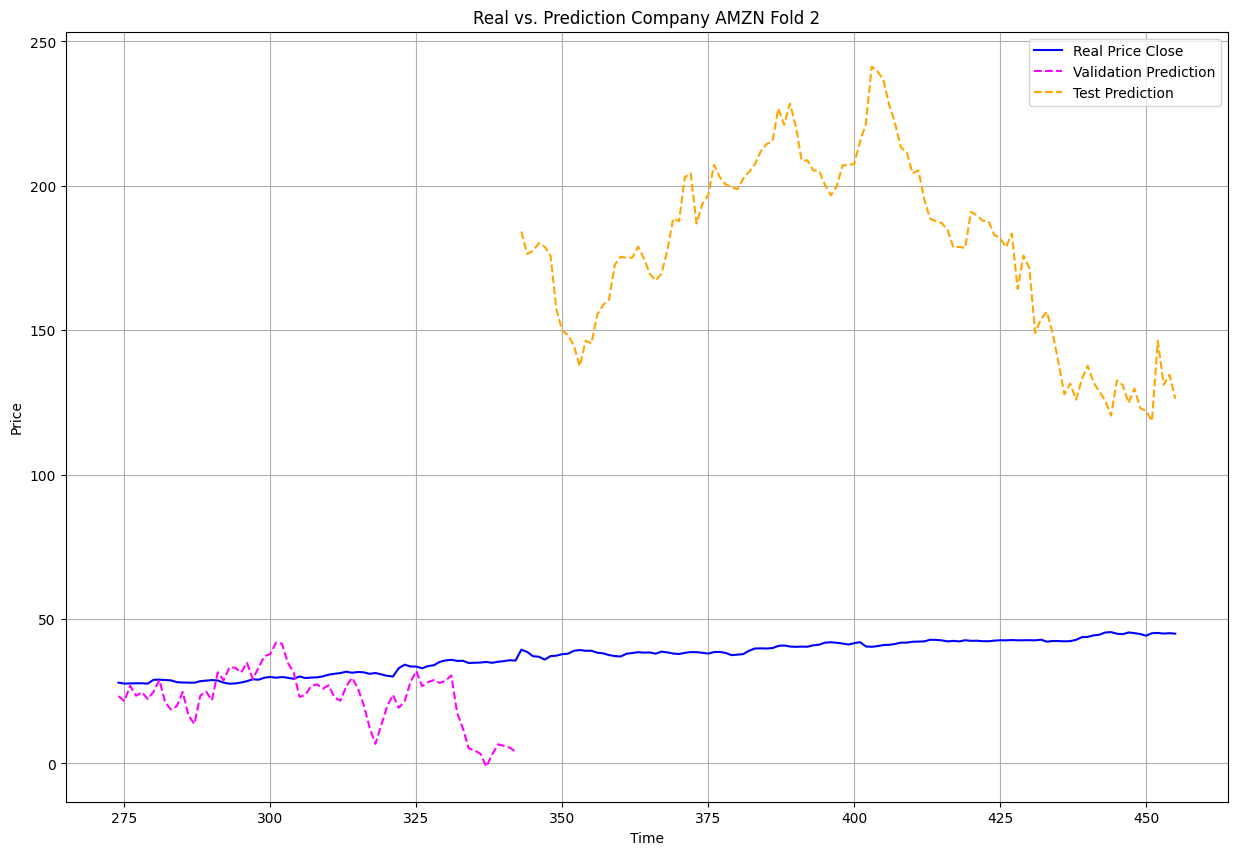

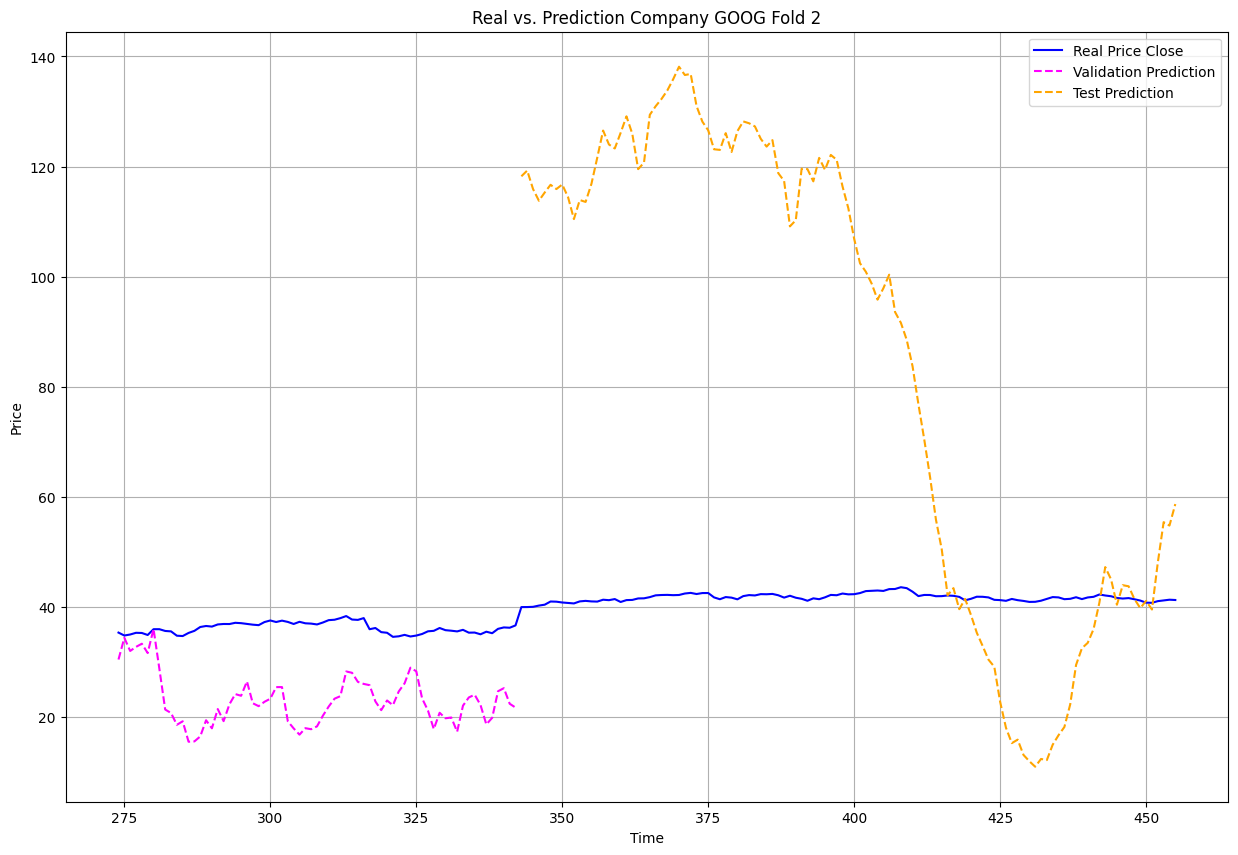

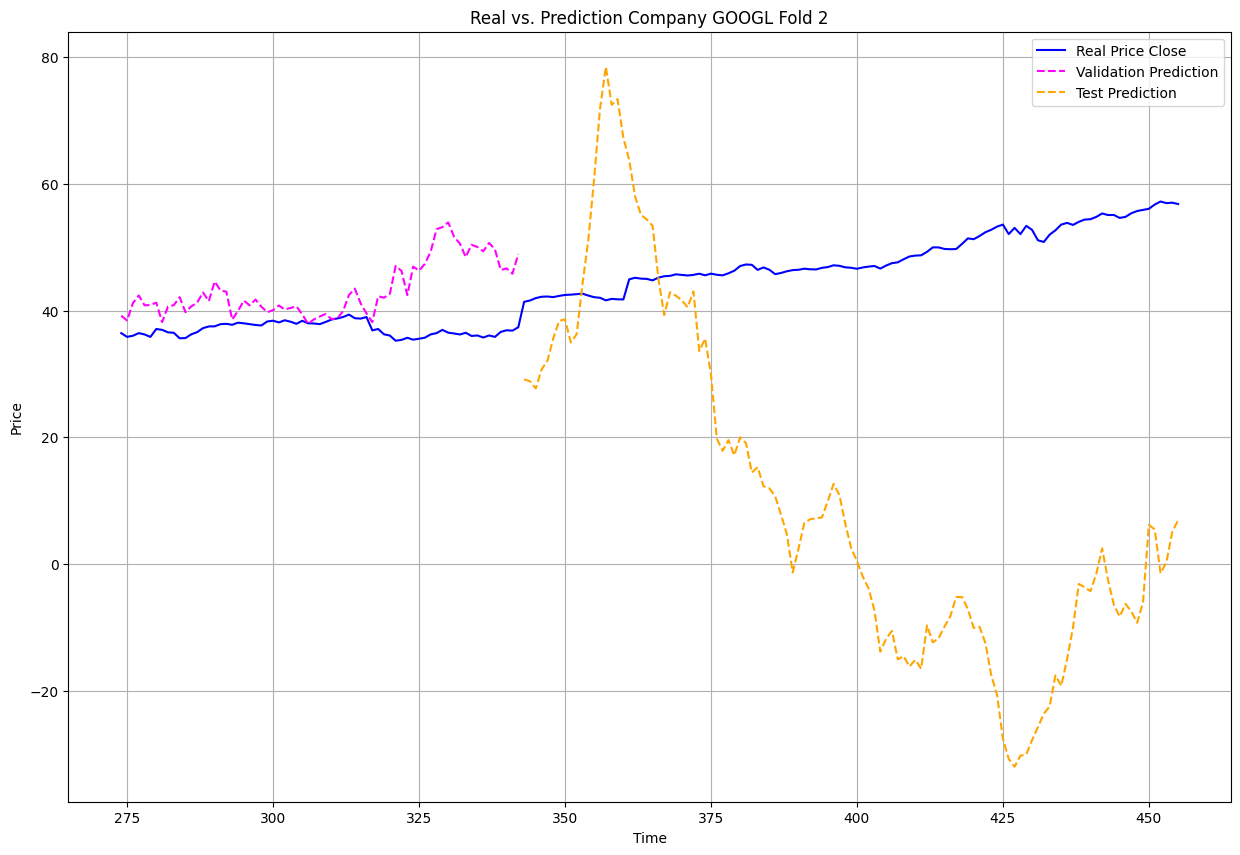

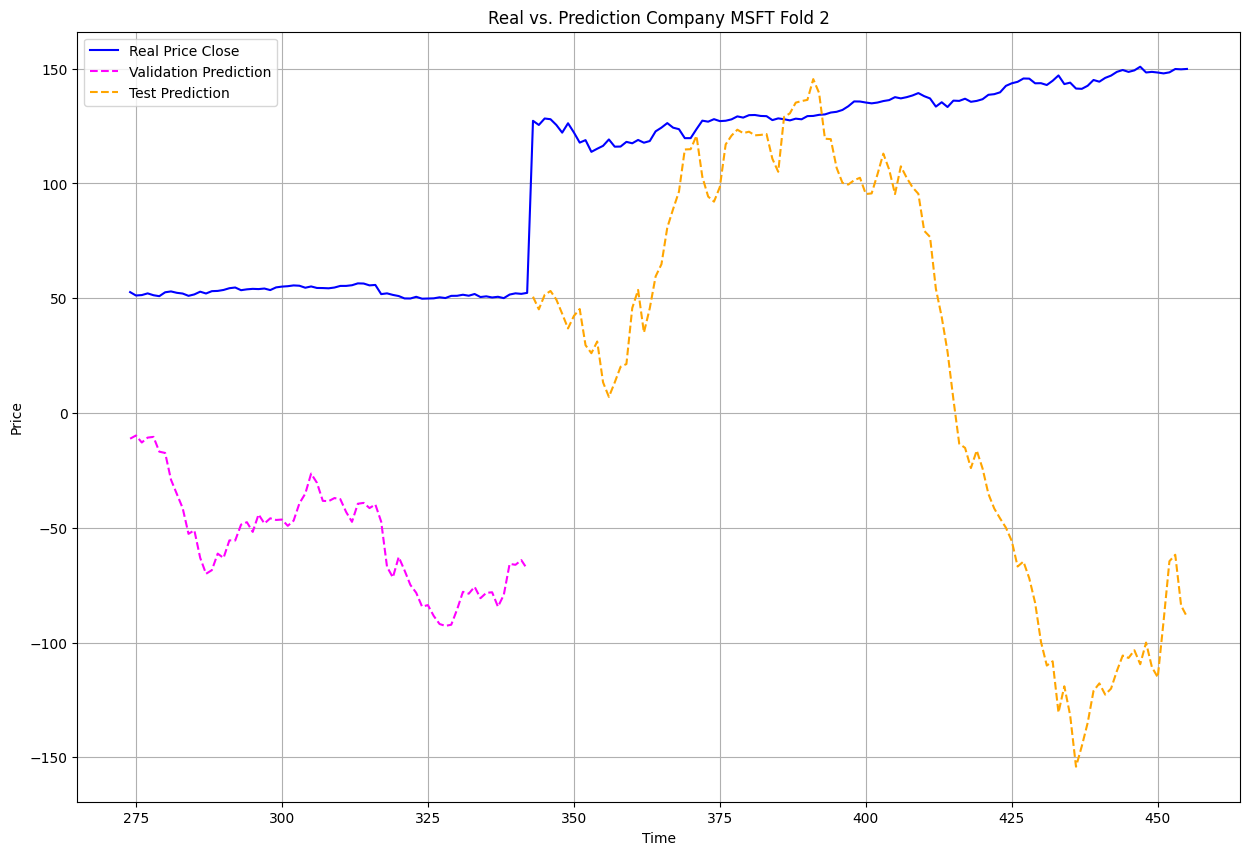

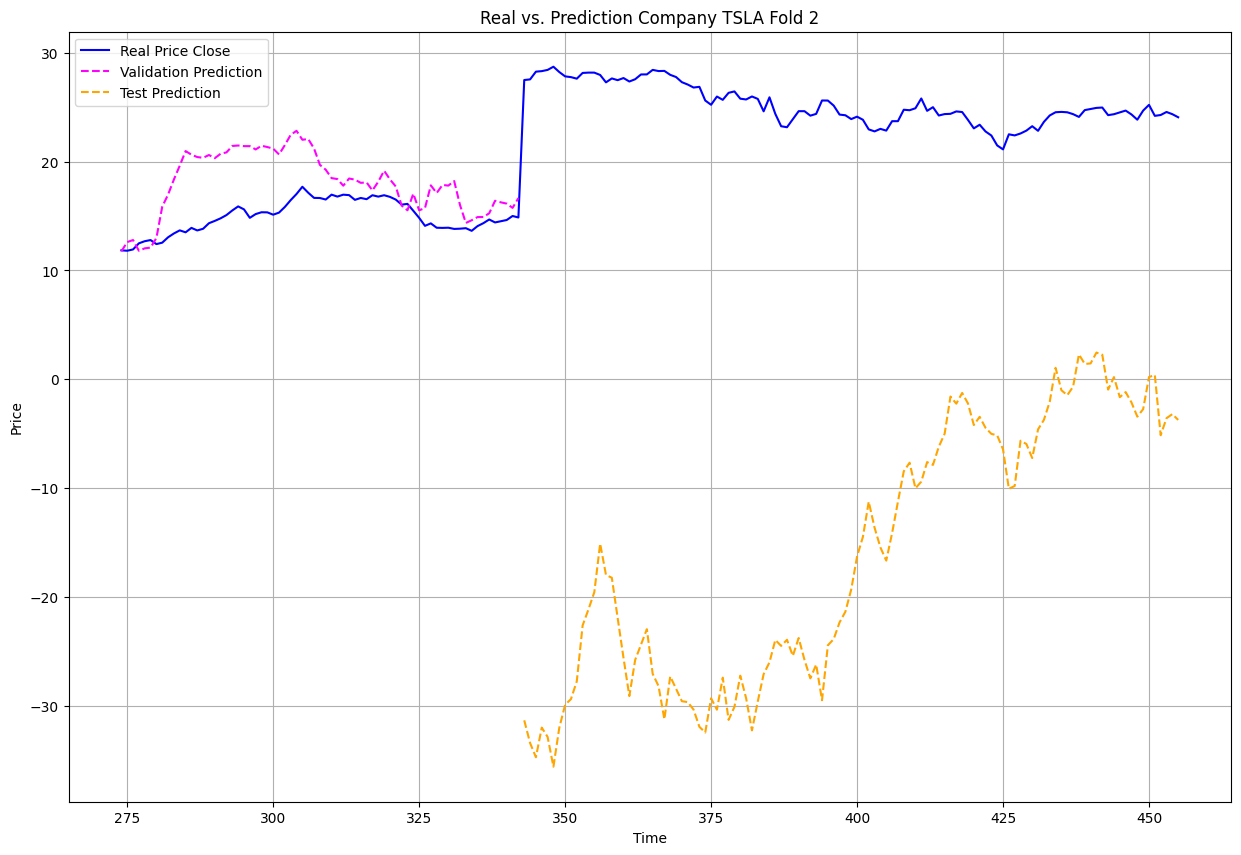

Fold_2 Done
Fold_3 Started


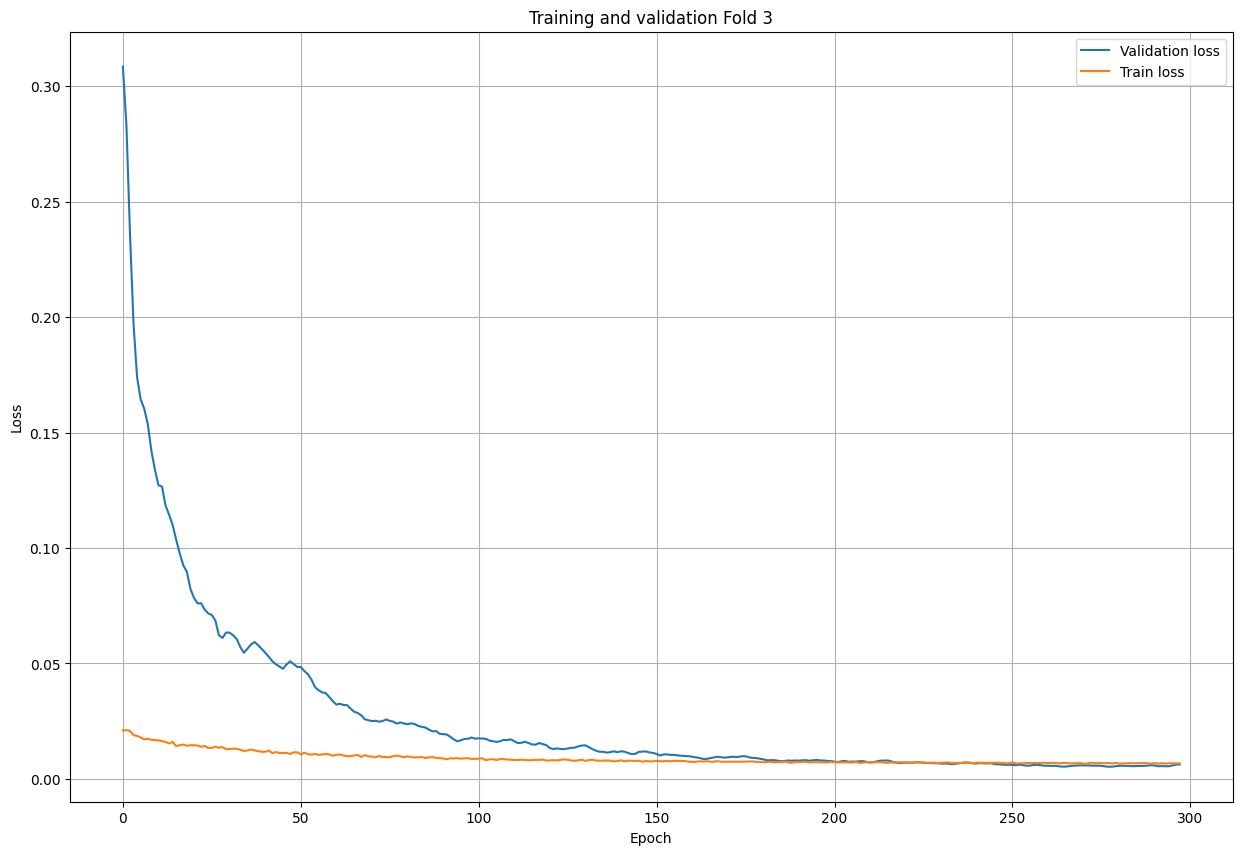

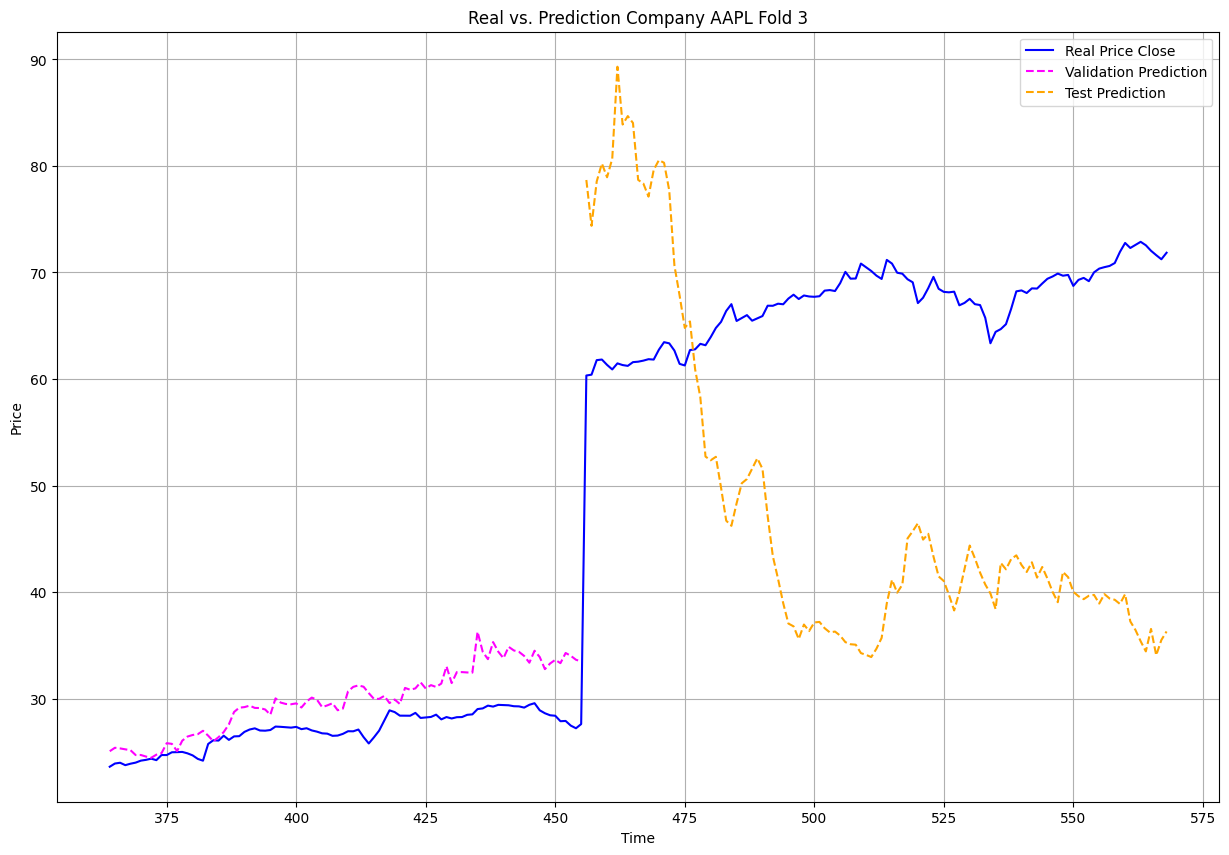

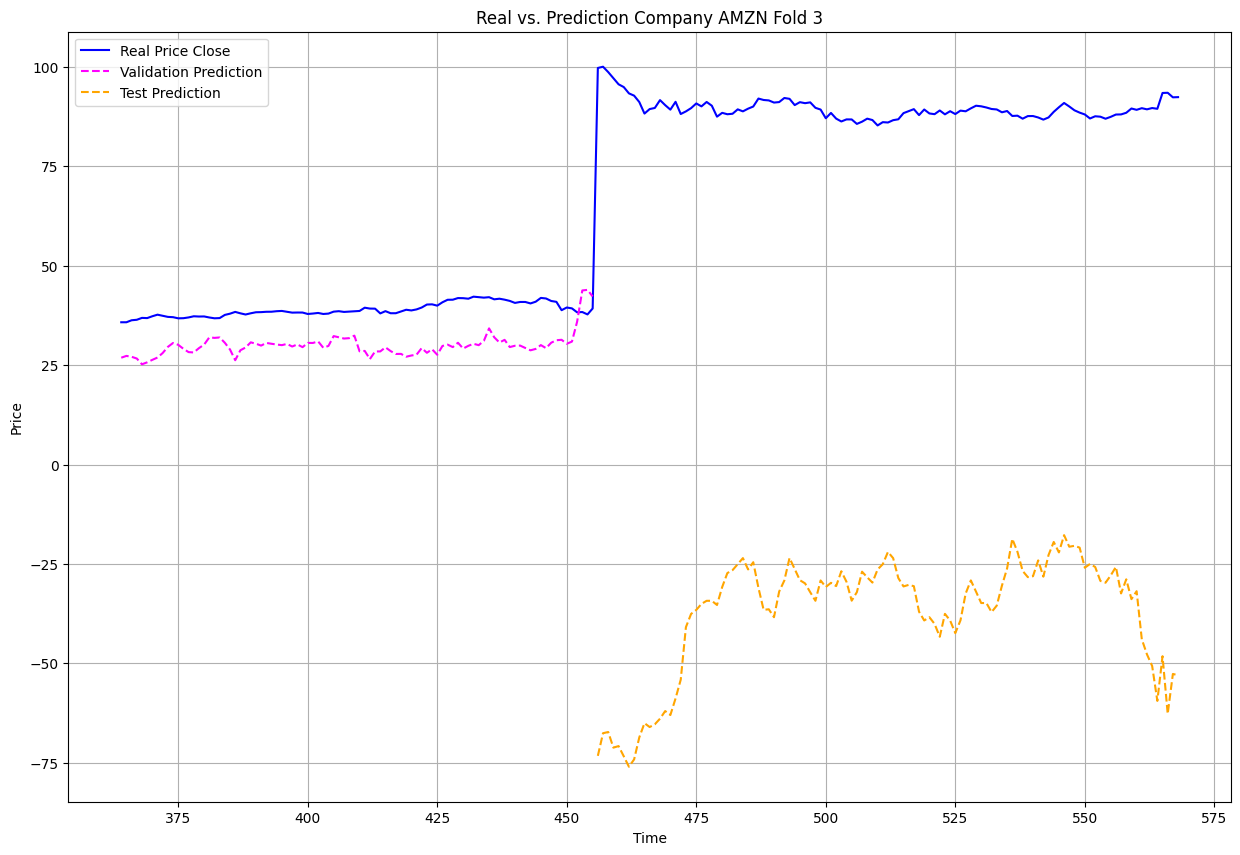

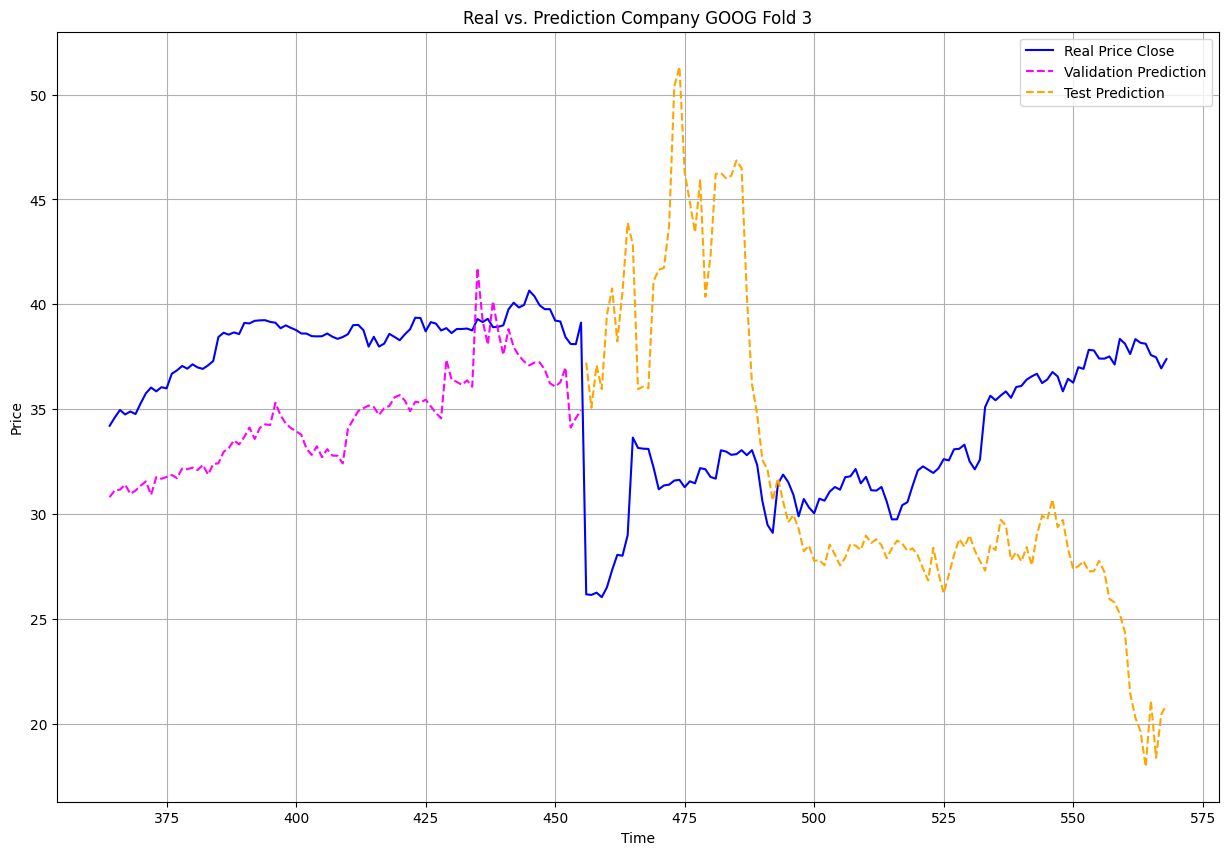

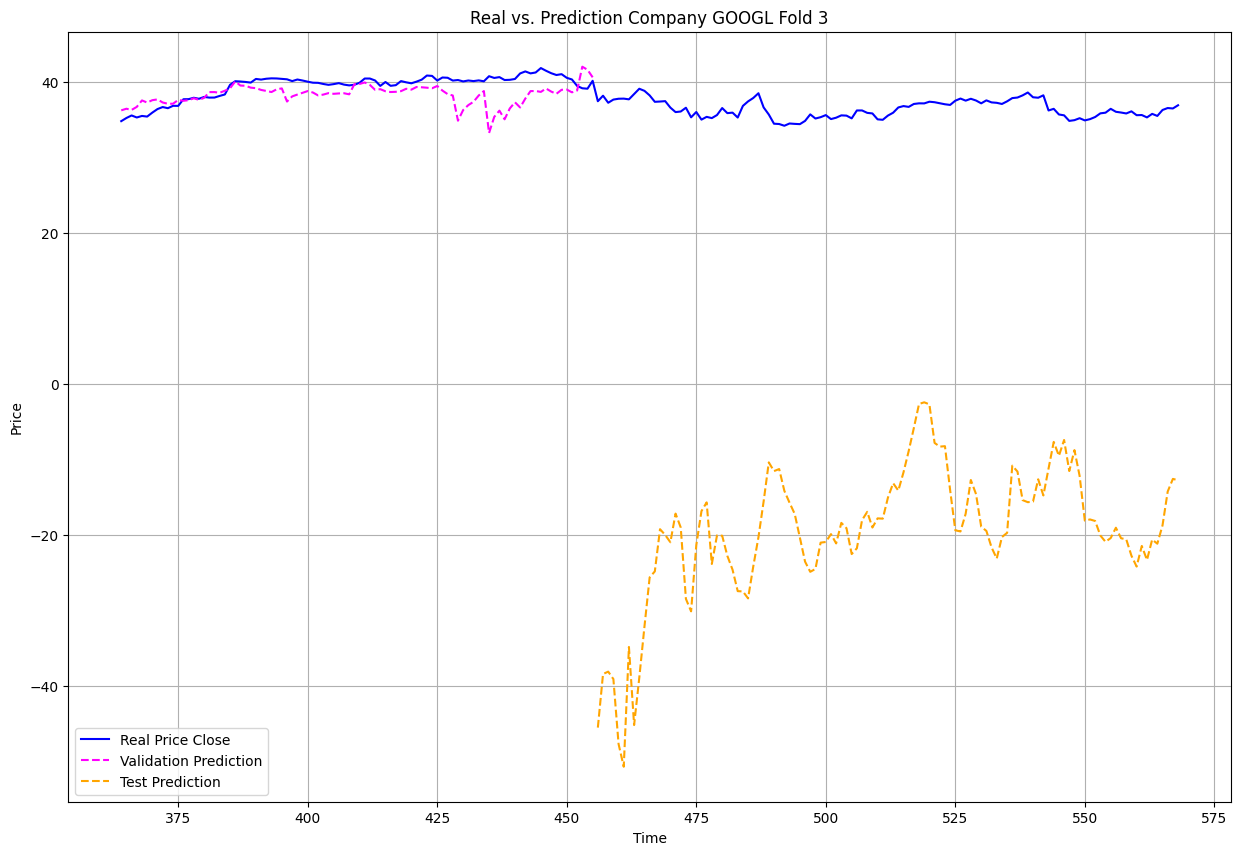

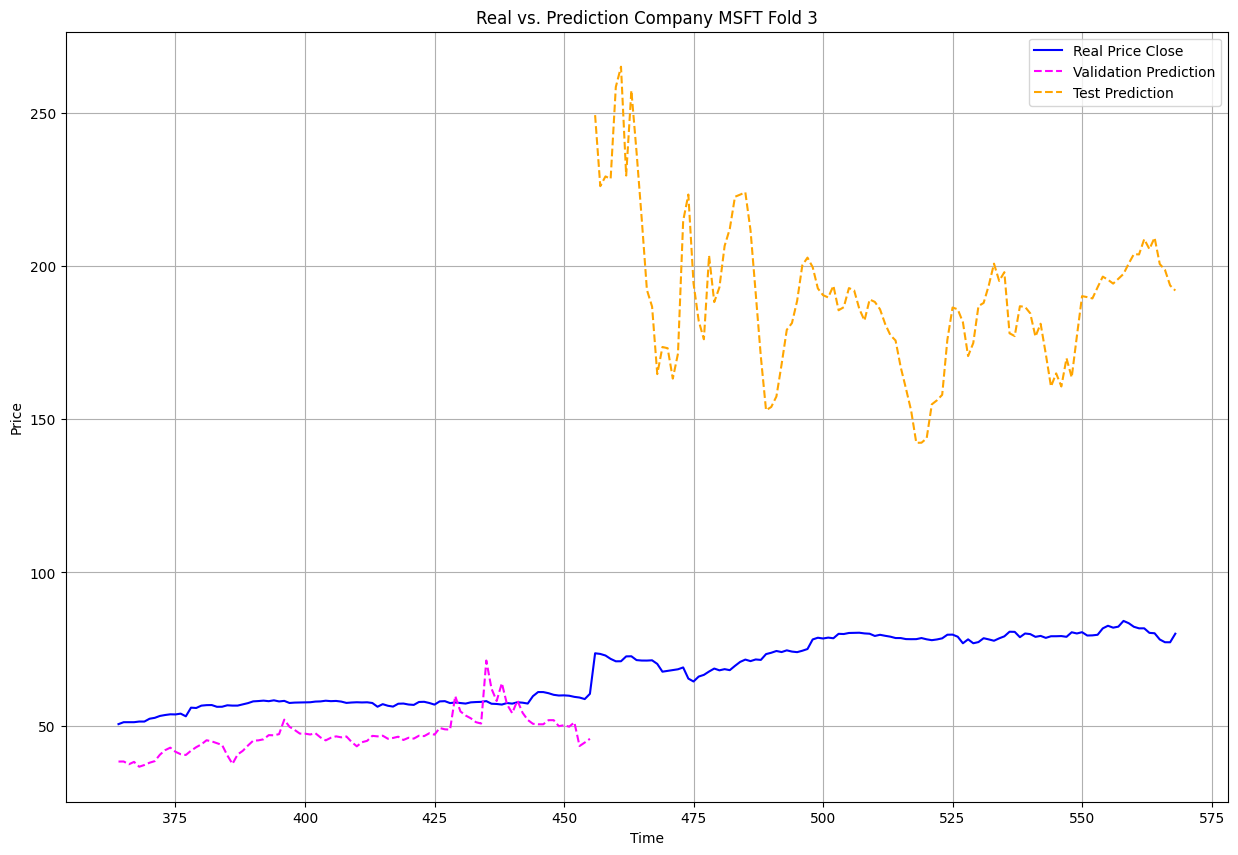

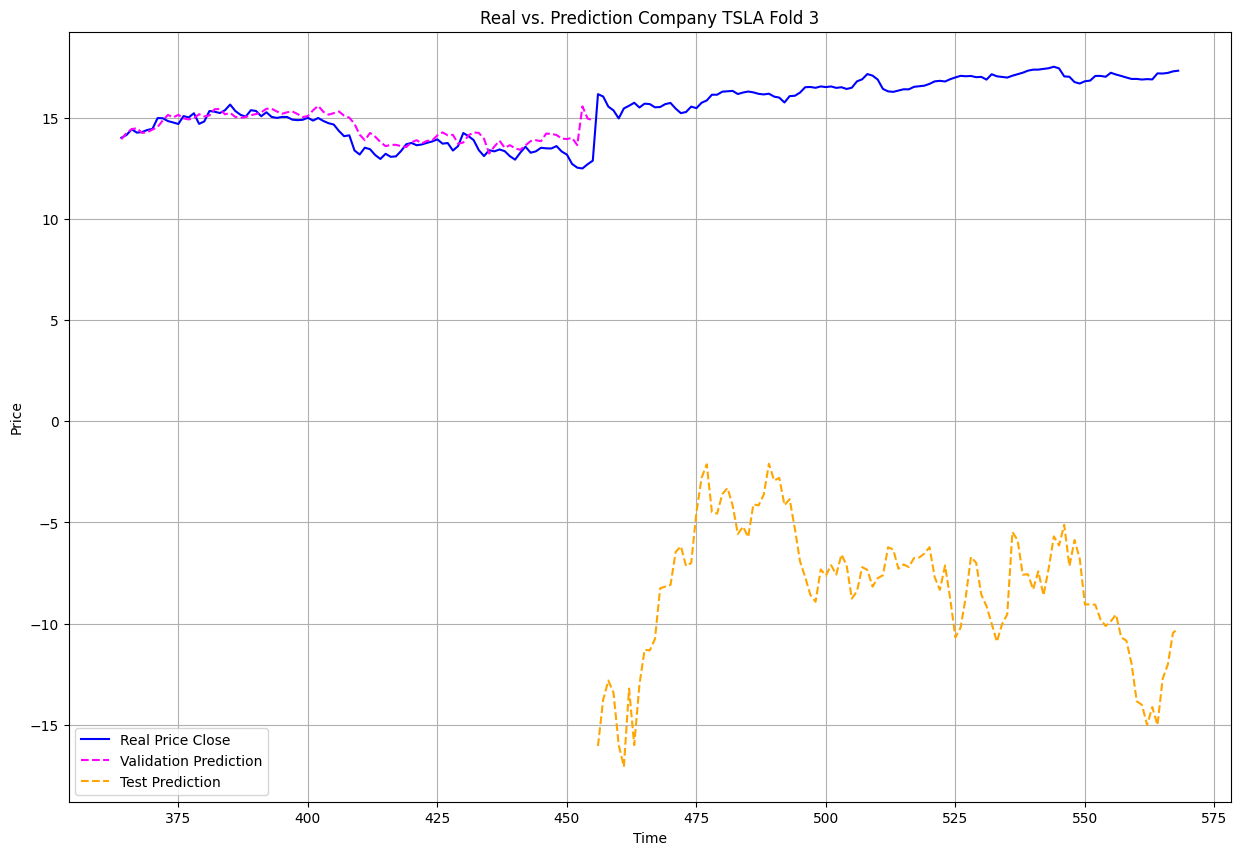

Fold_3 Done
Fold_4 Started


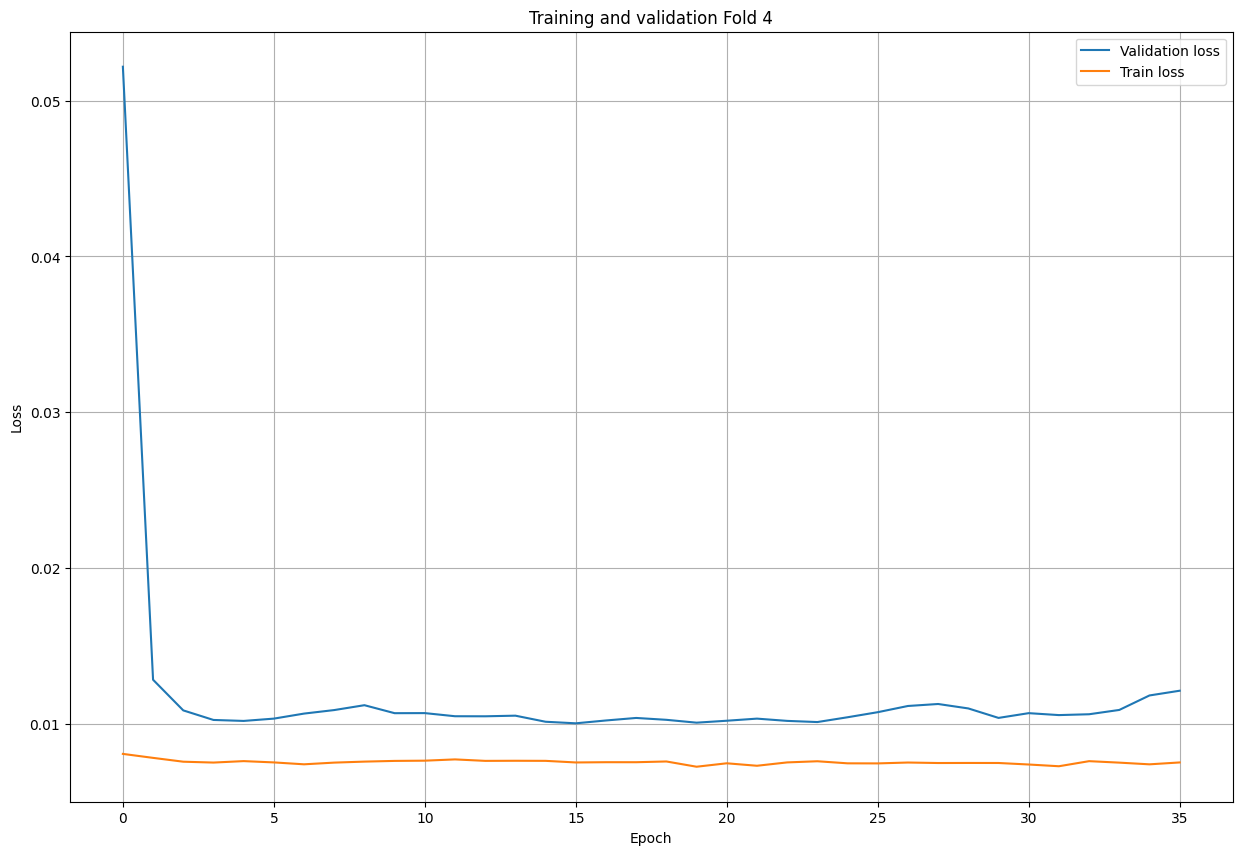

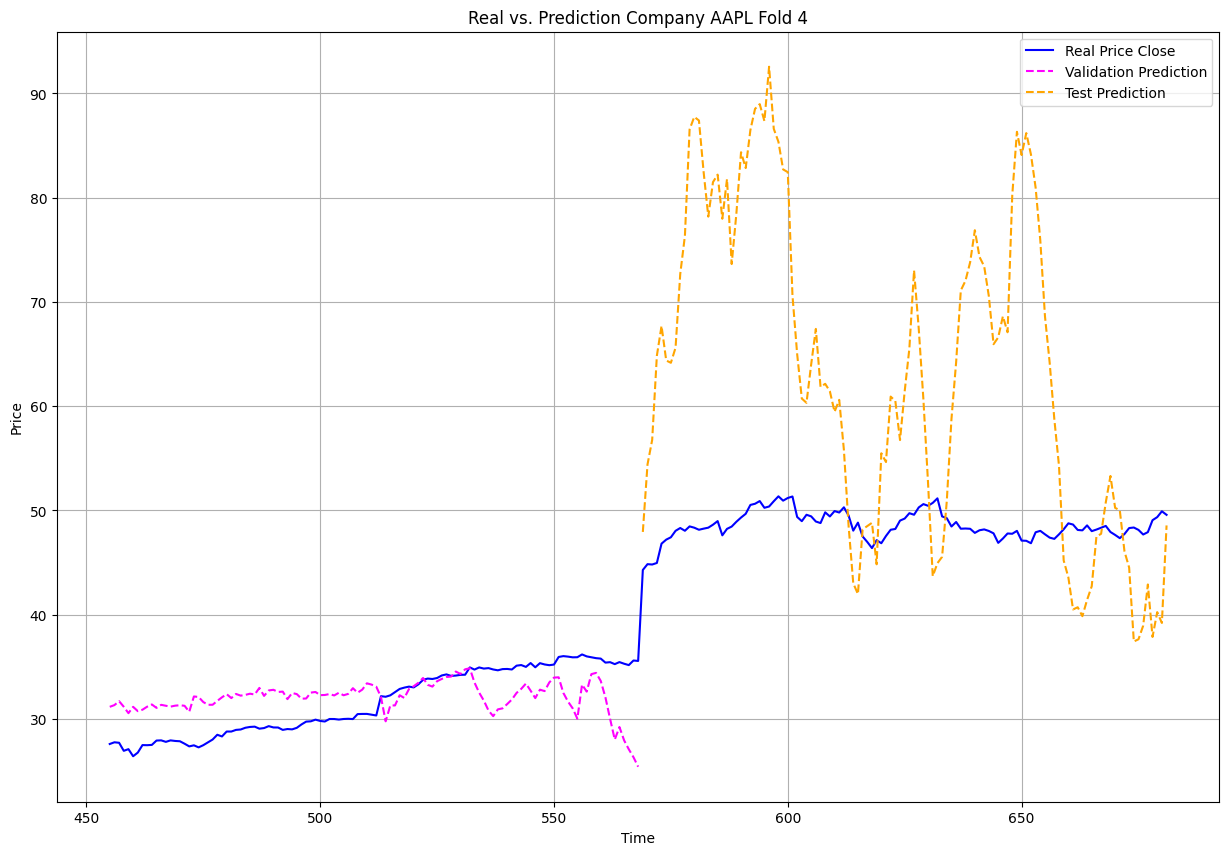

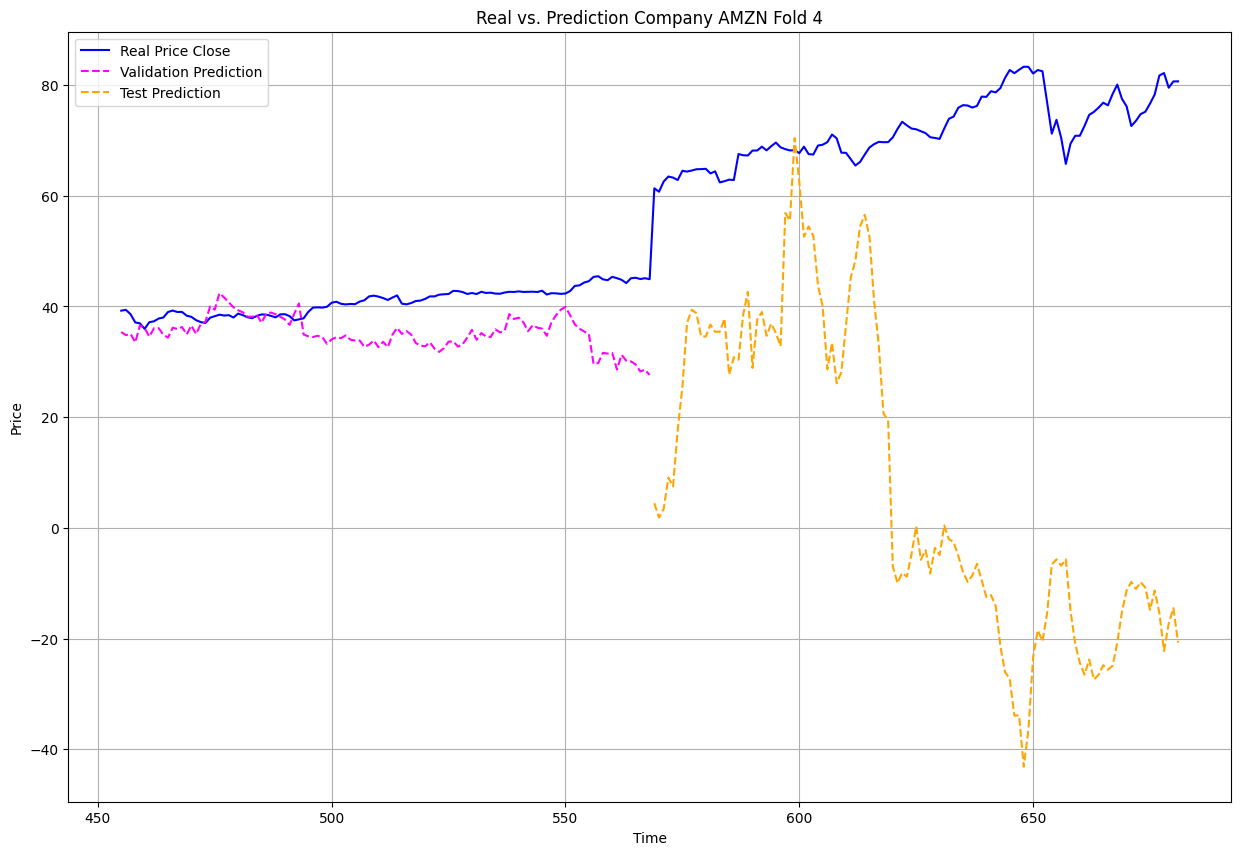

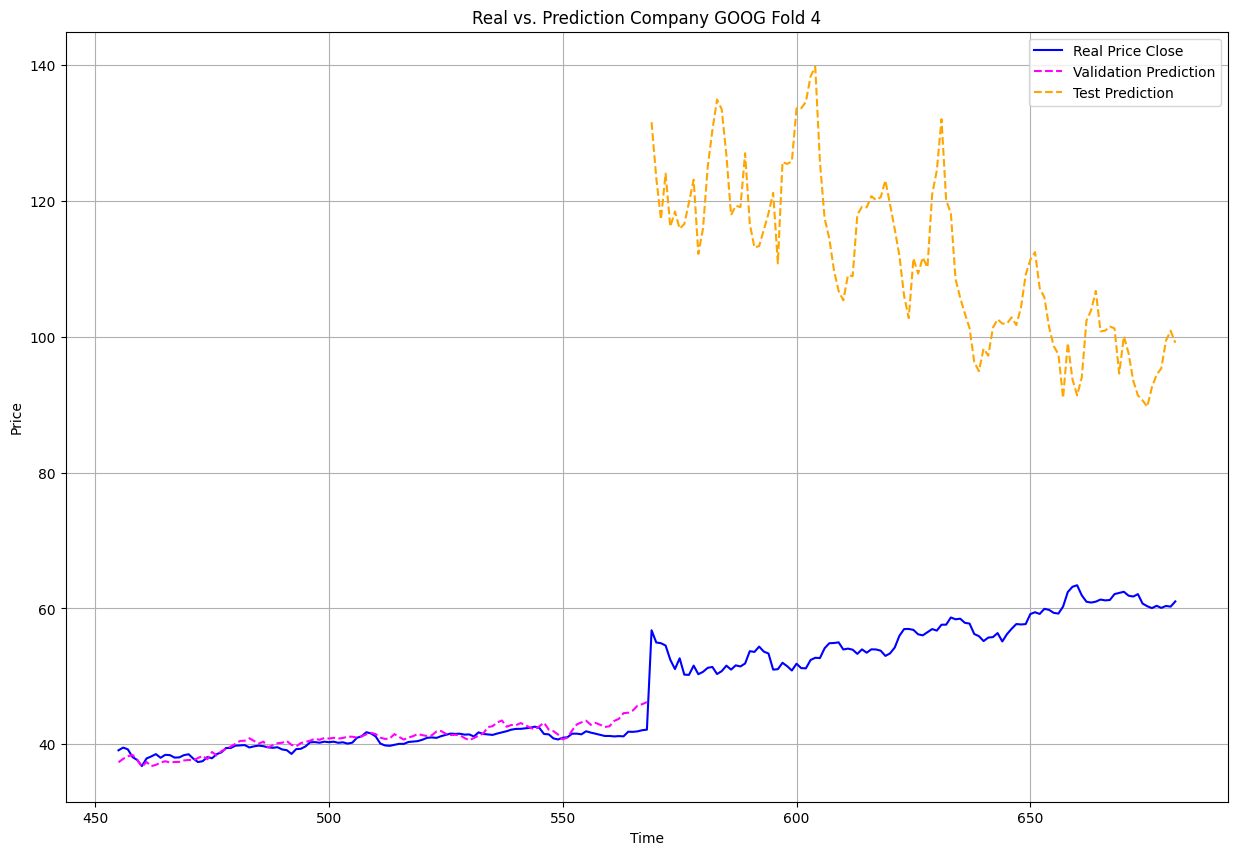

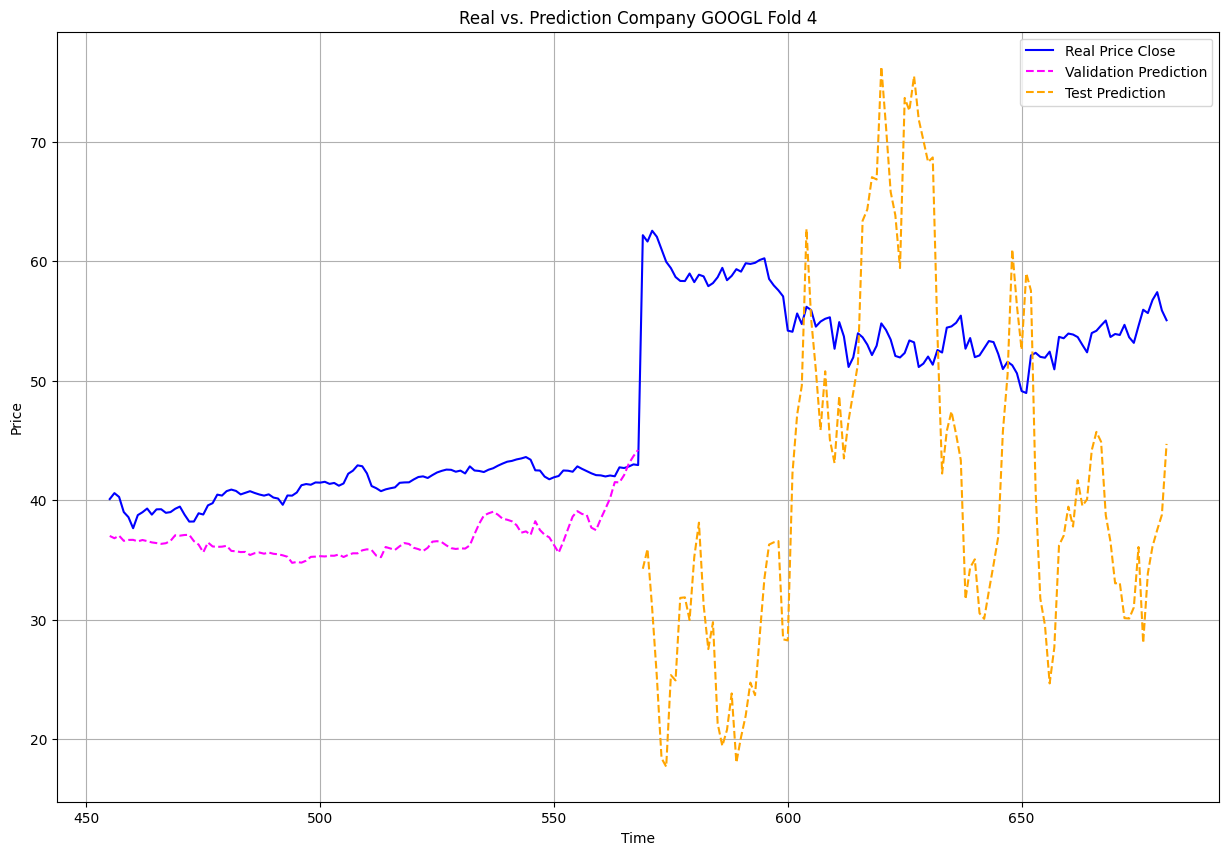

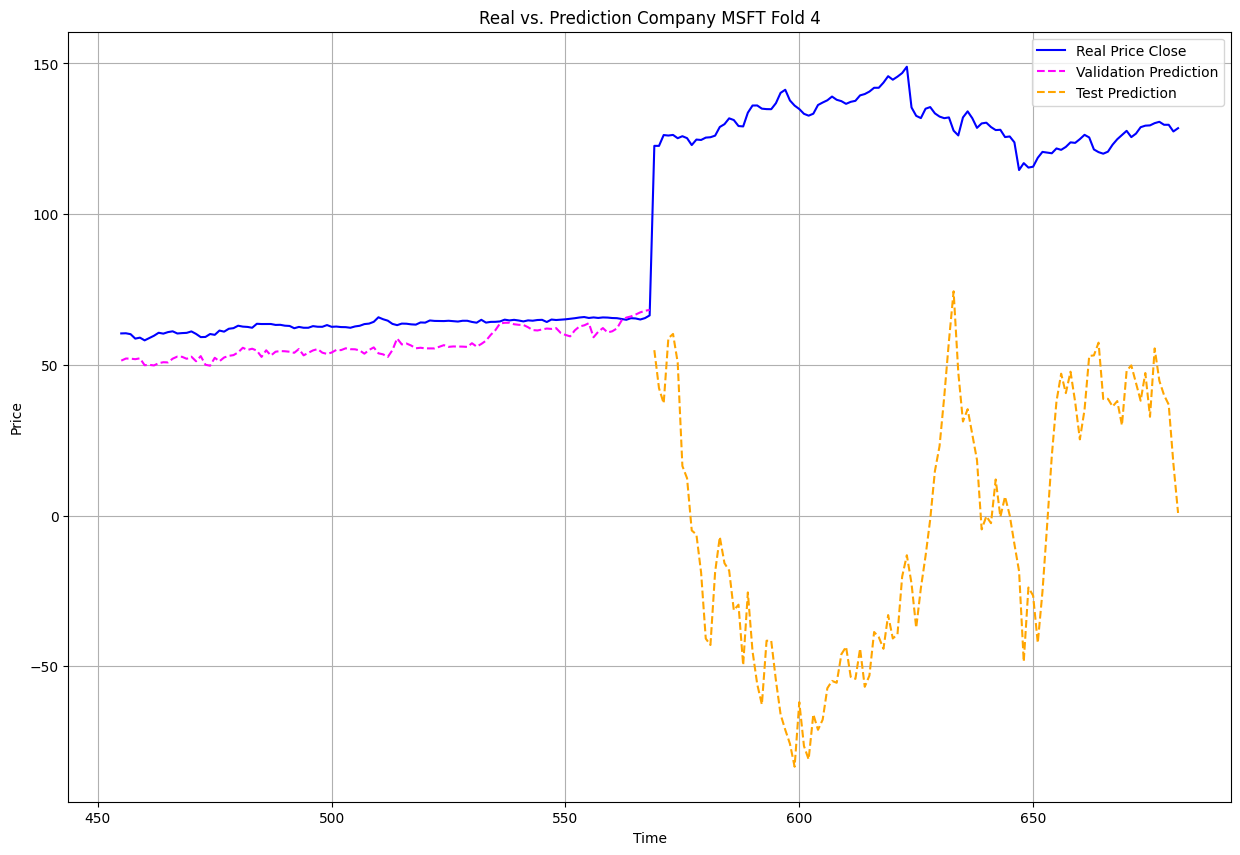

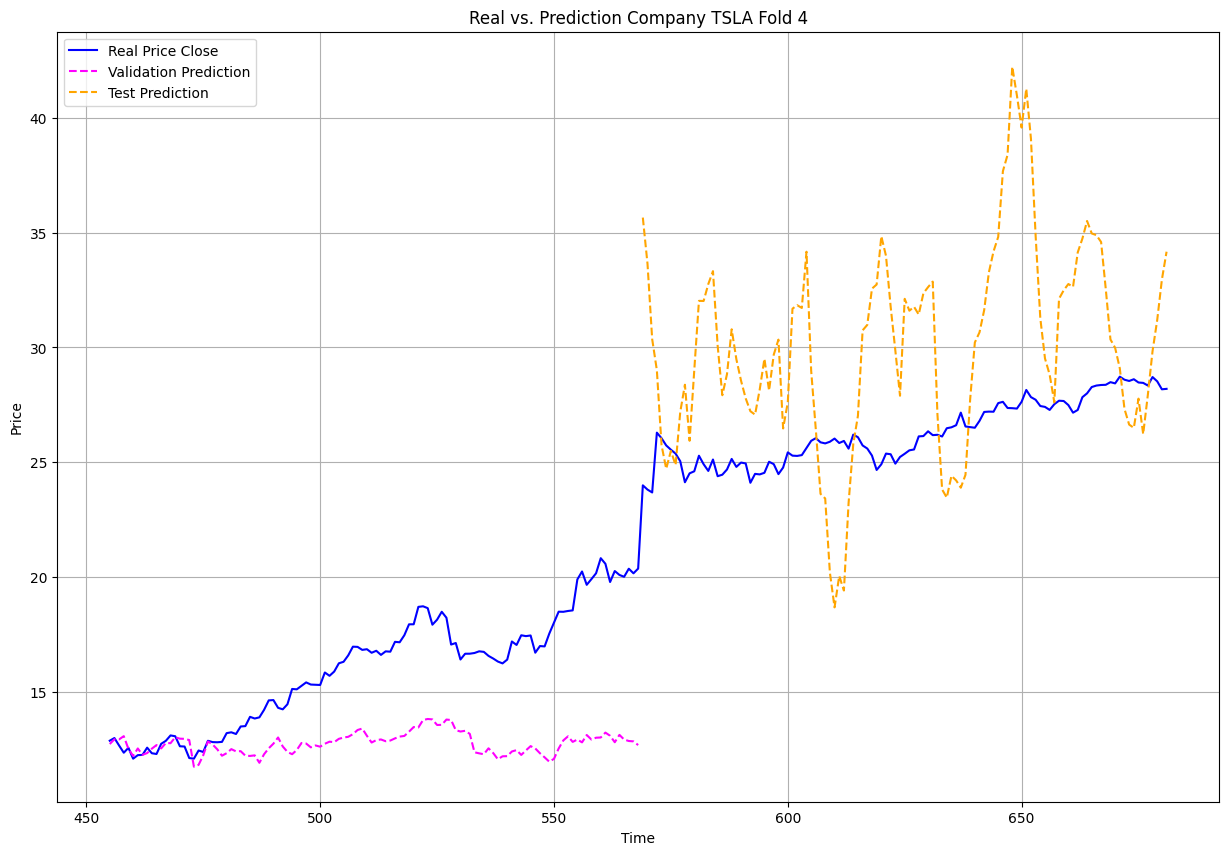

Fold_4 Done
Fold_5 Started


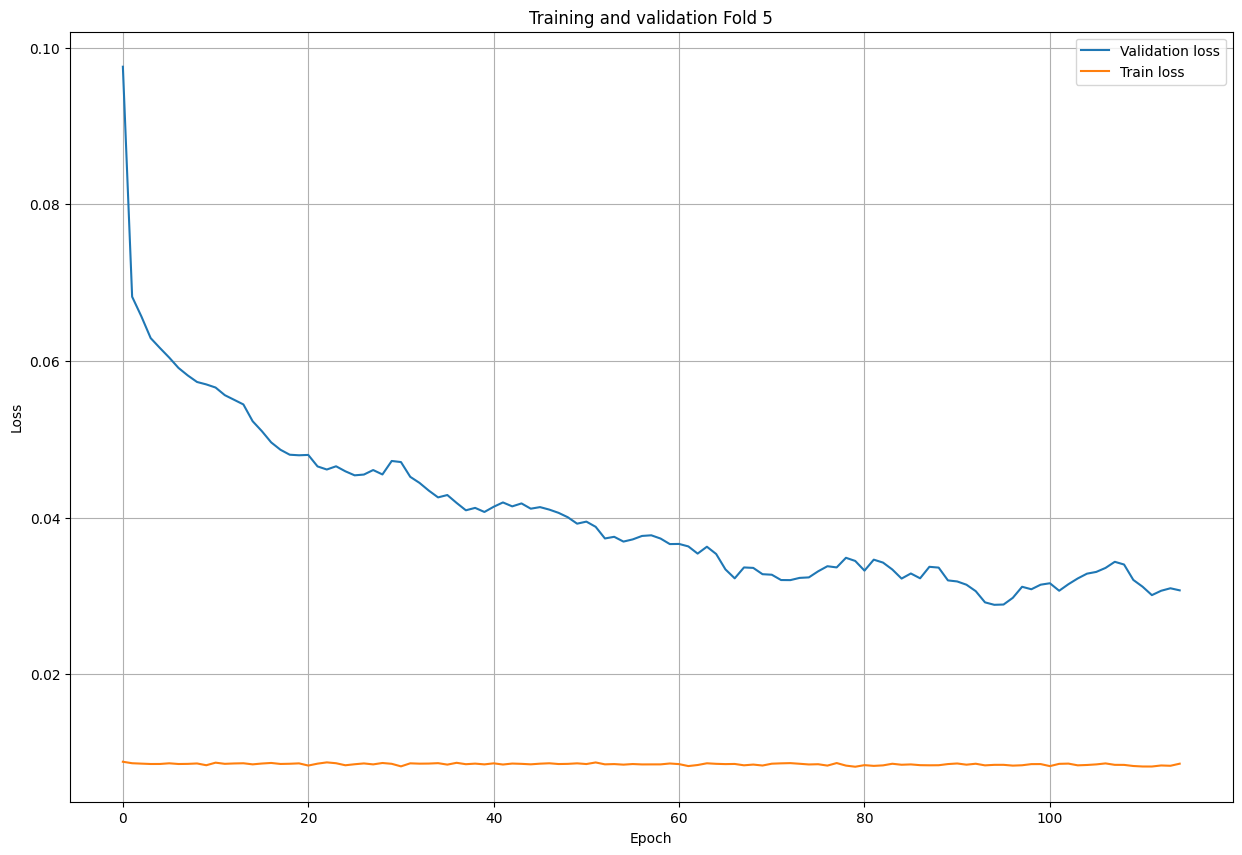

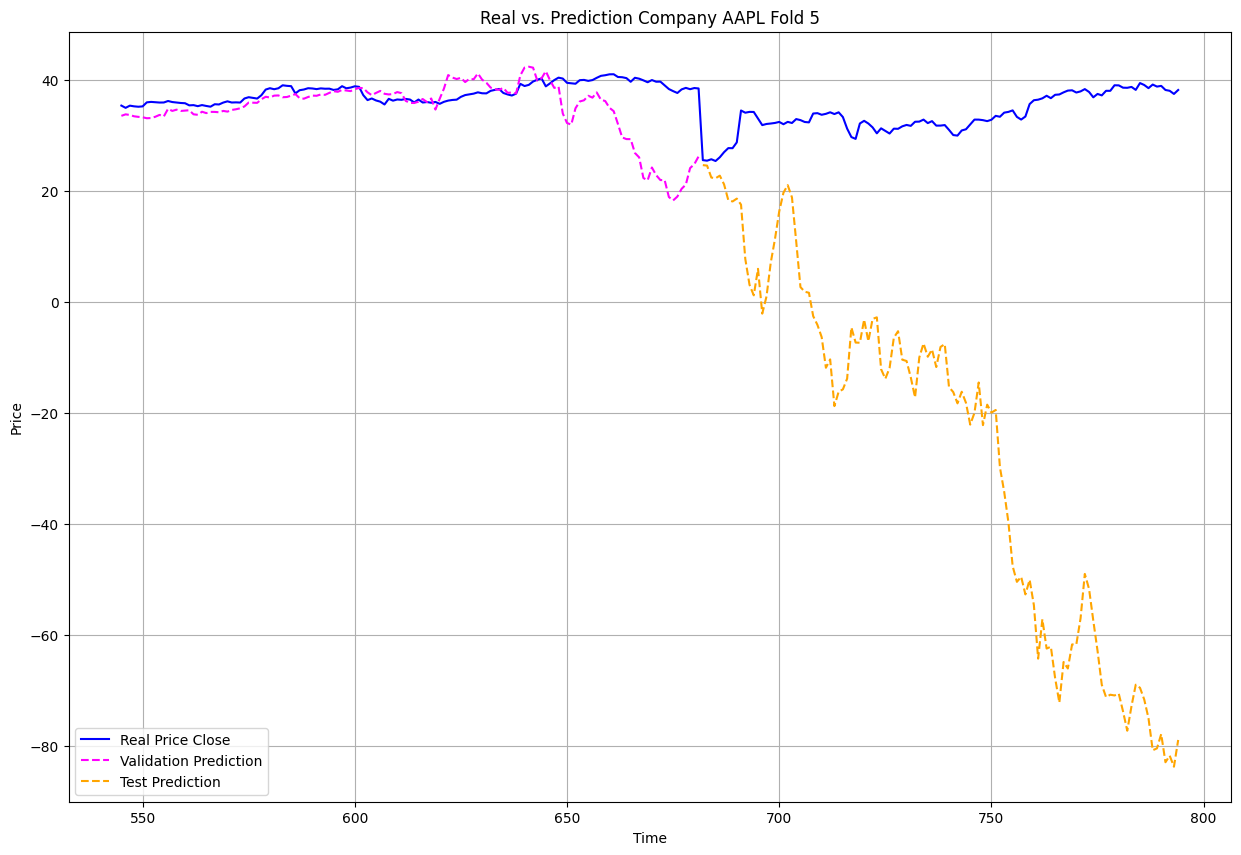

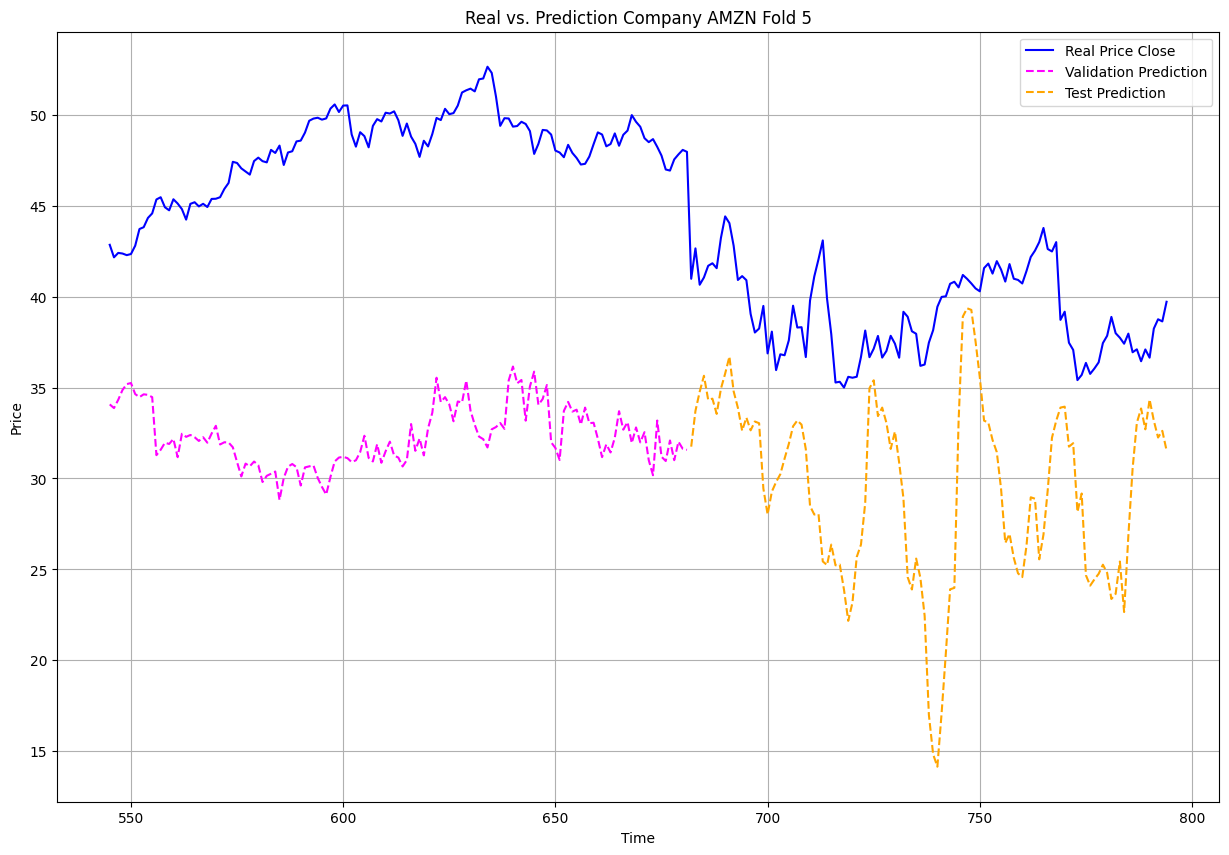

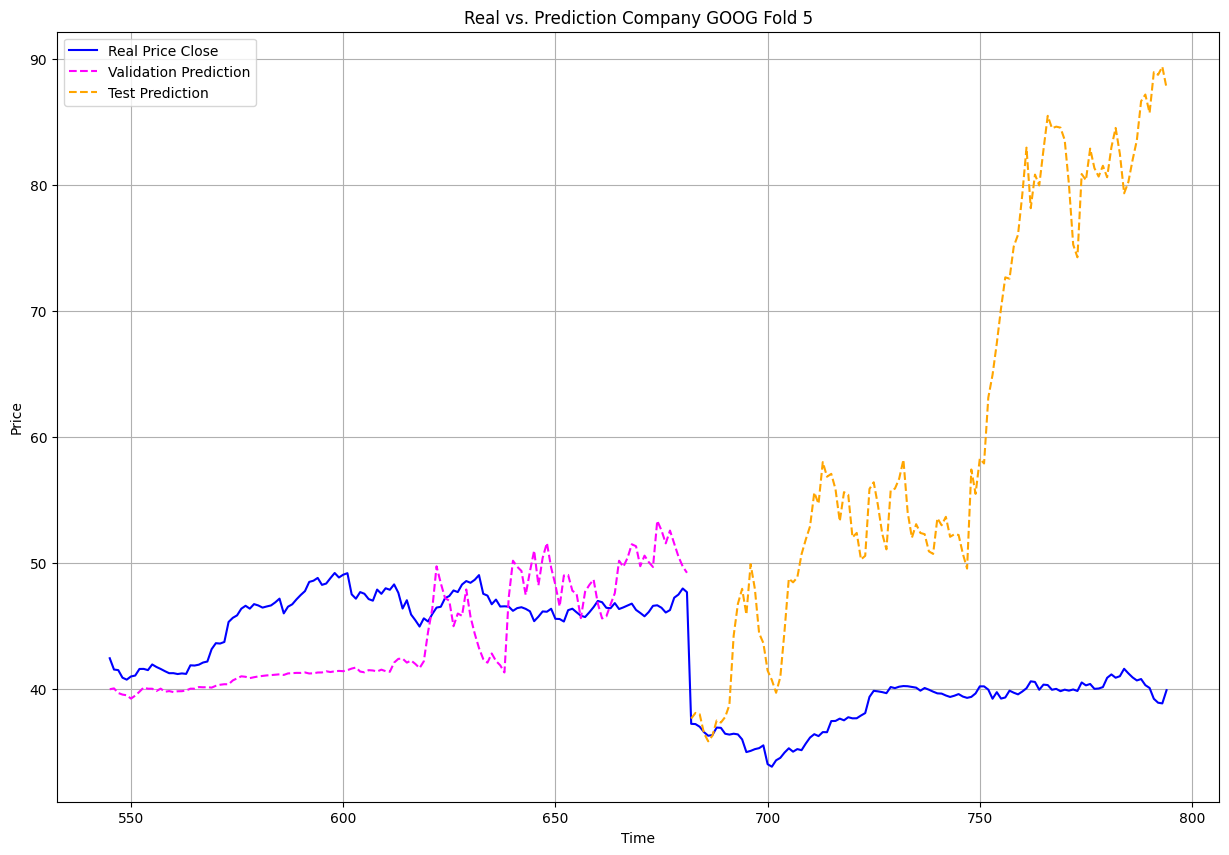

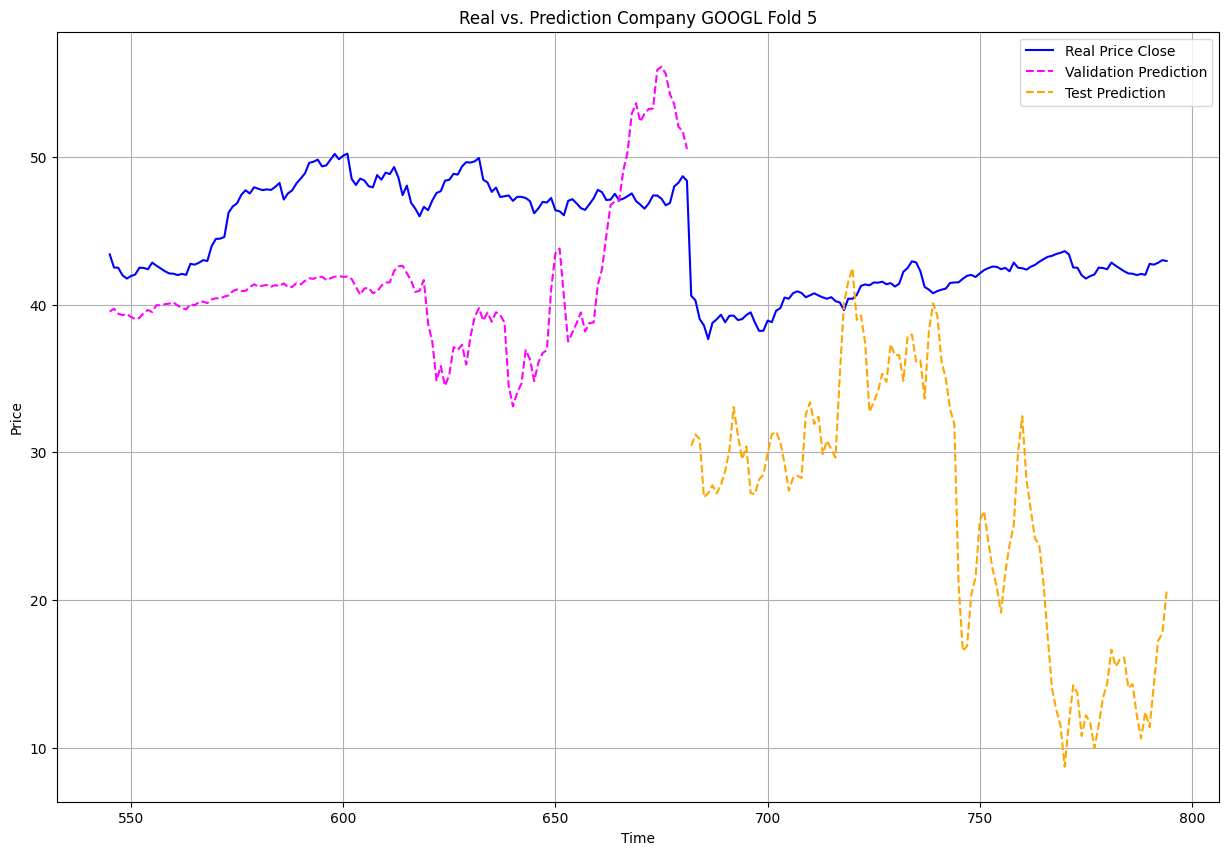

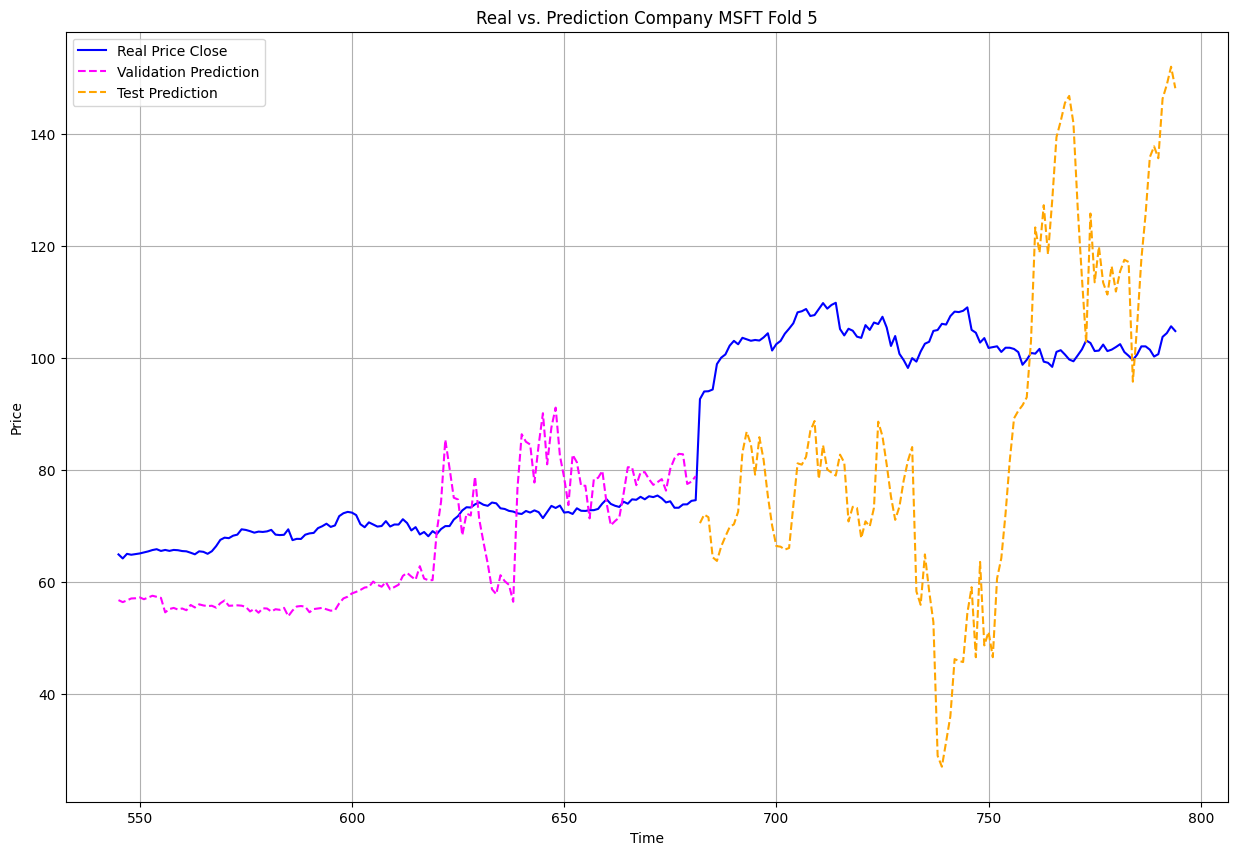

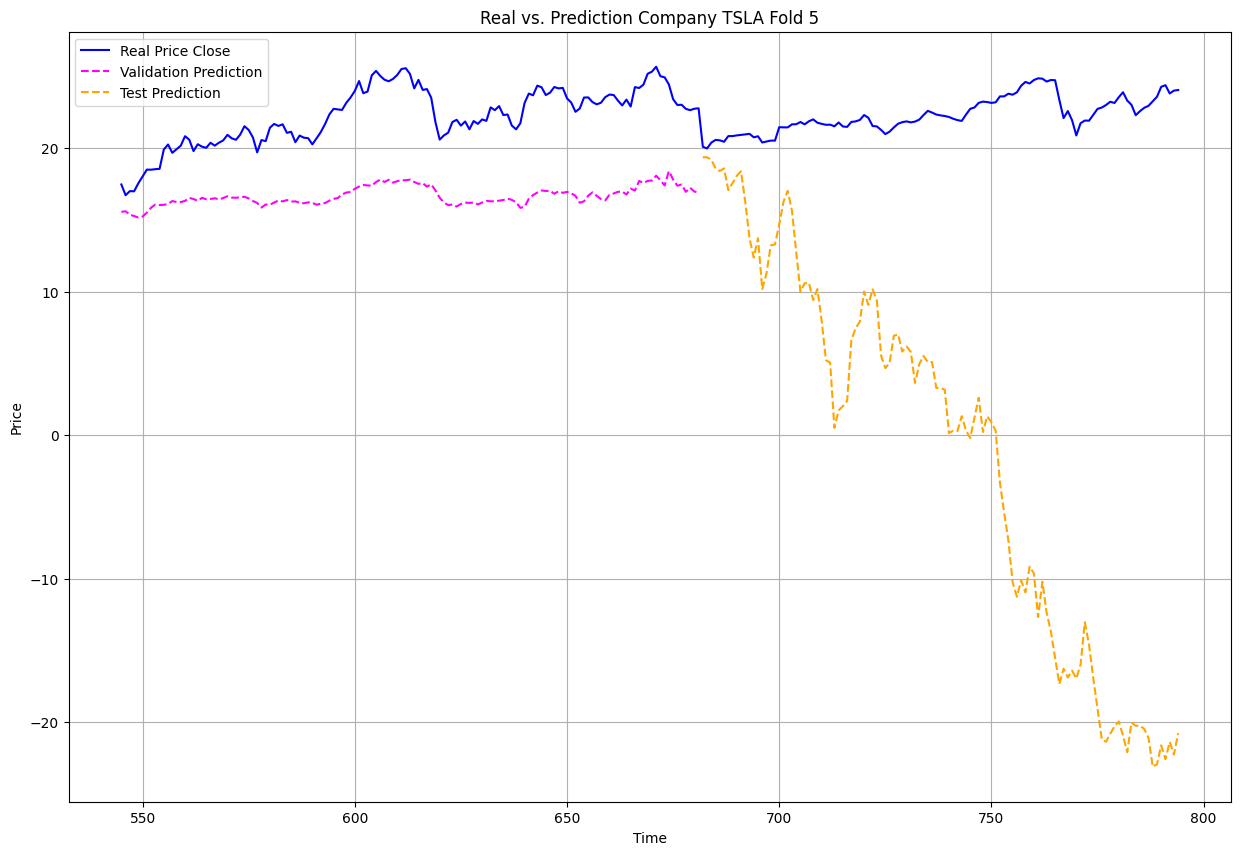

Fold_5 Done
Fold_6 Started


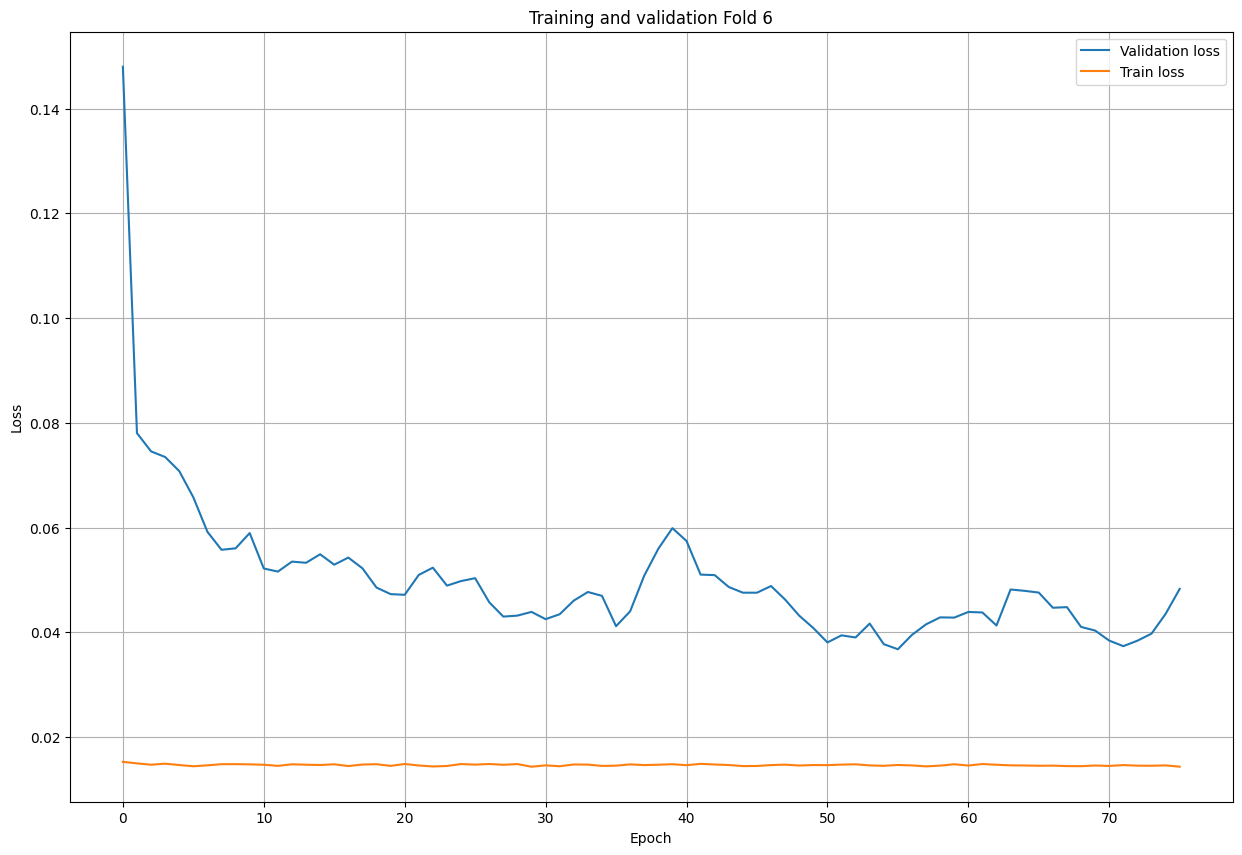

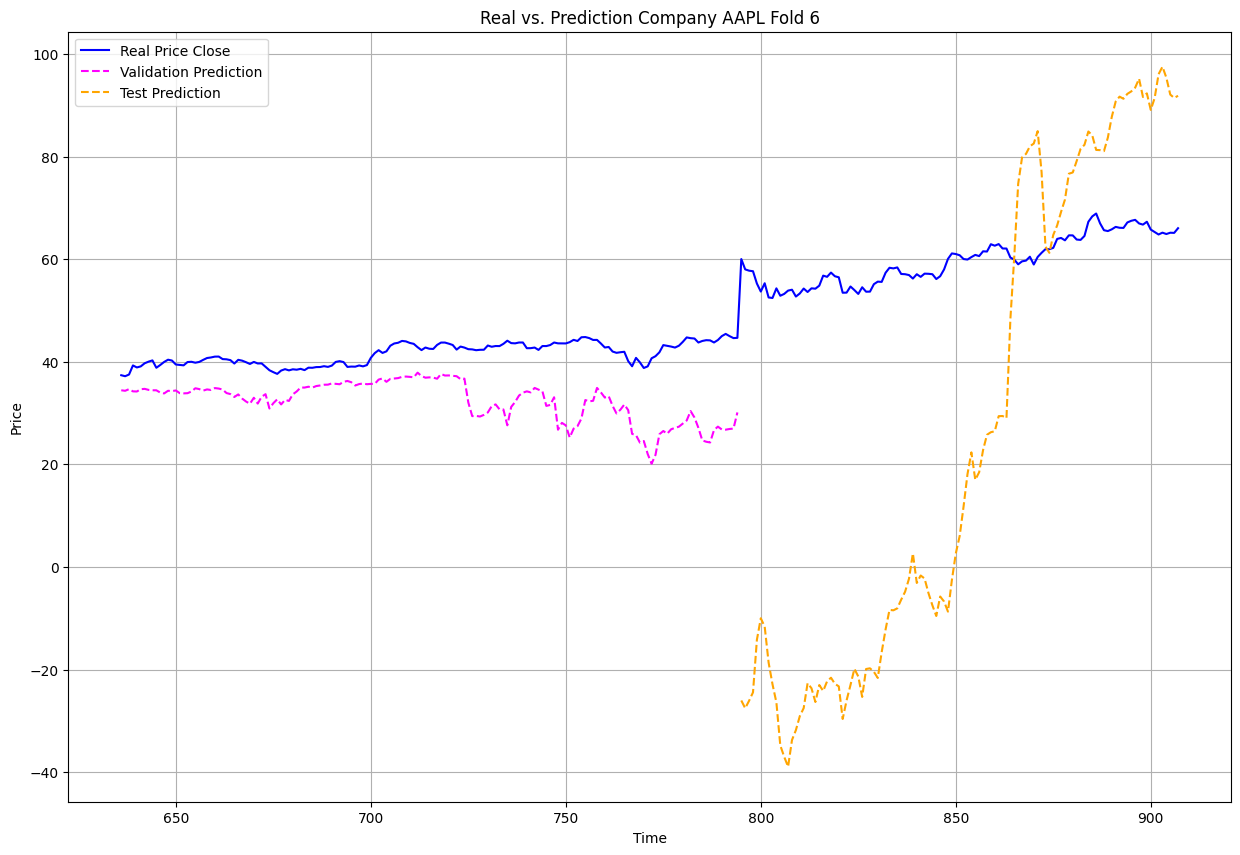

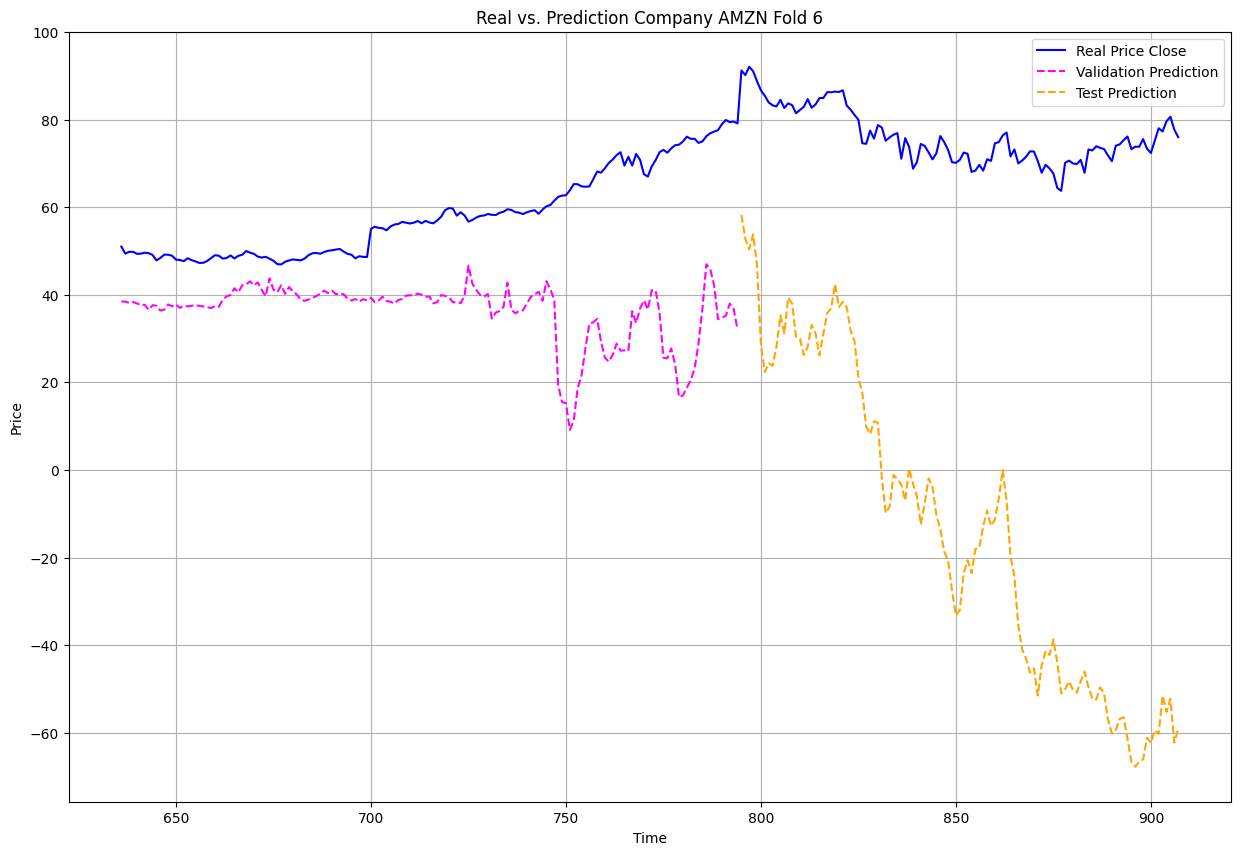

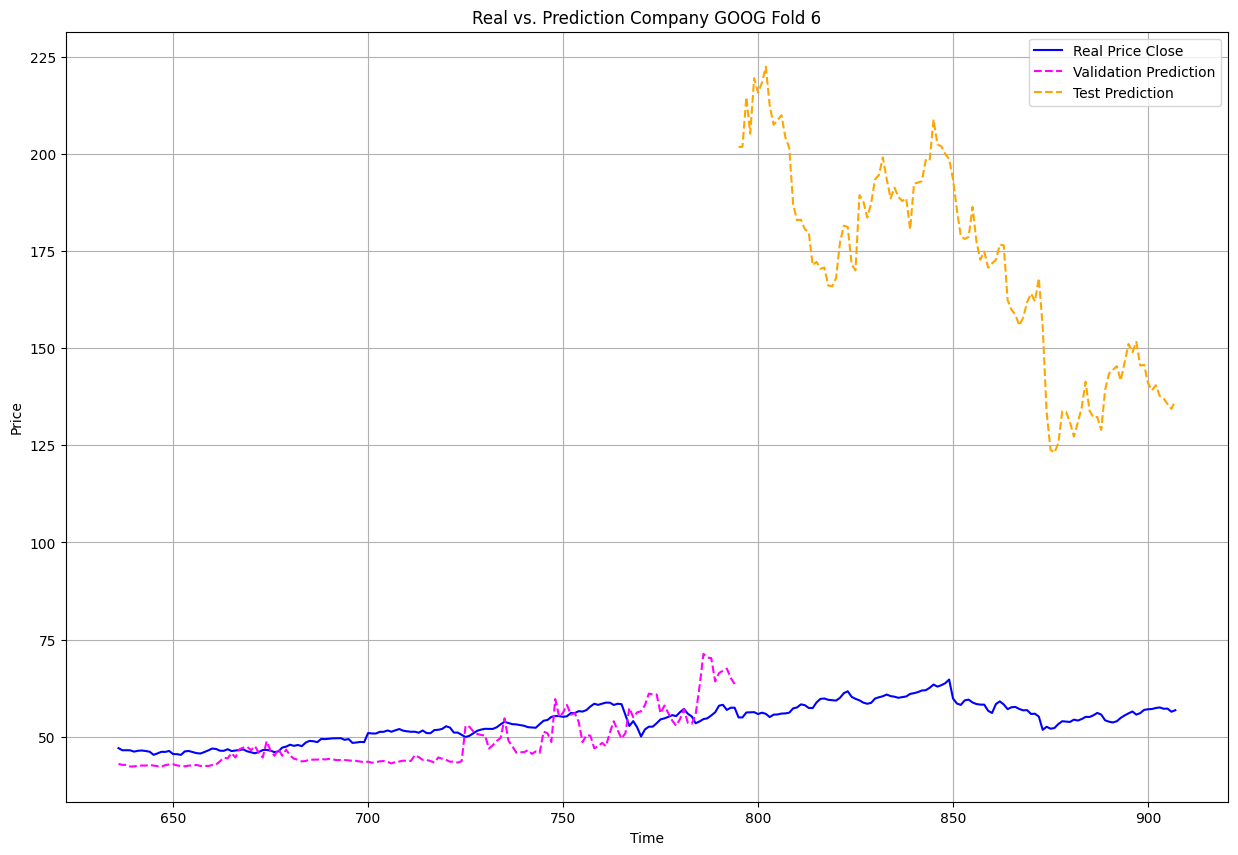

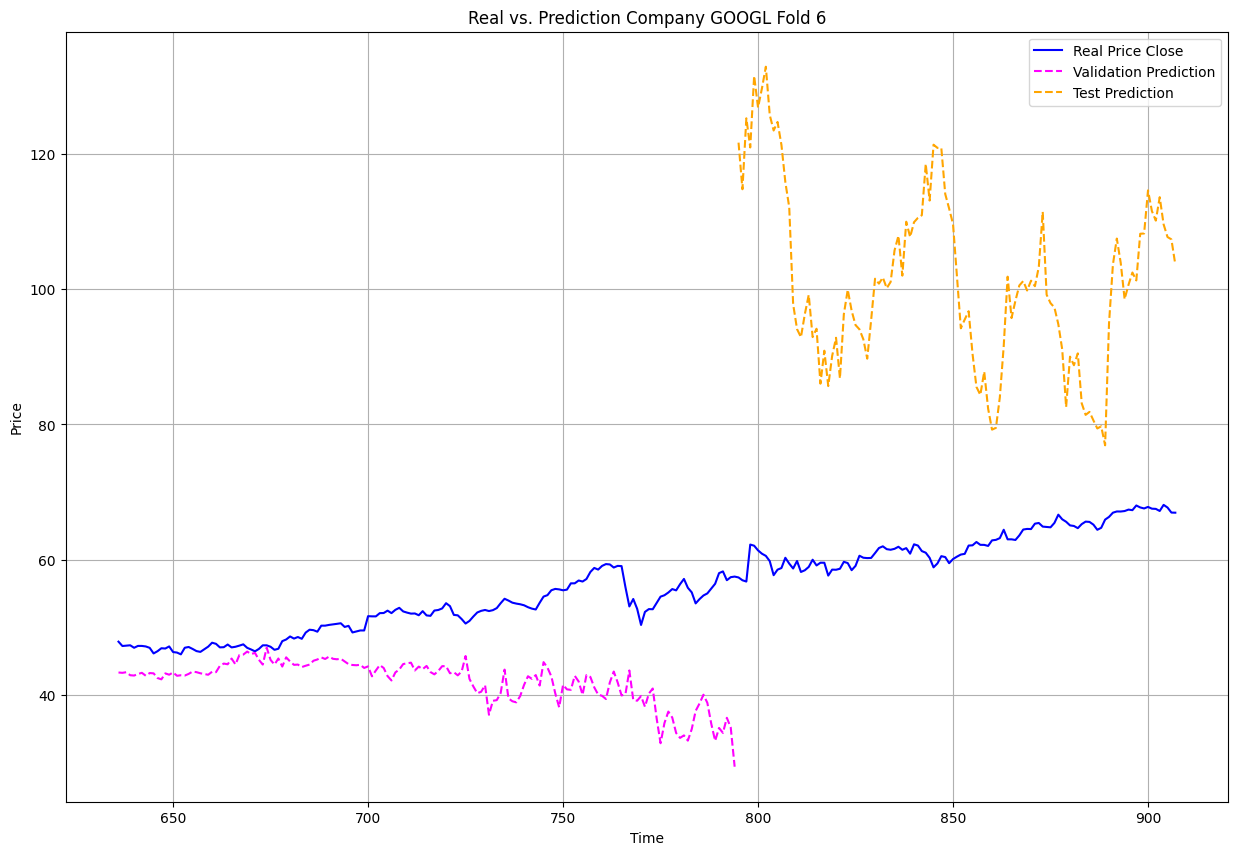

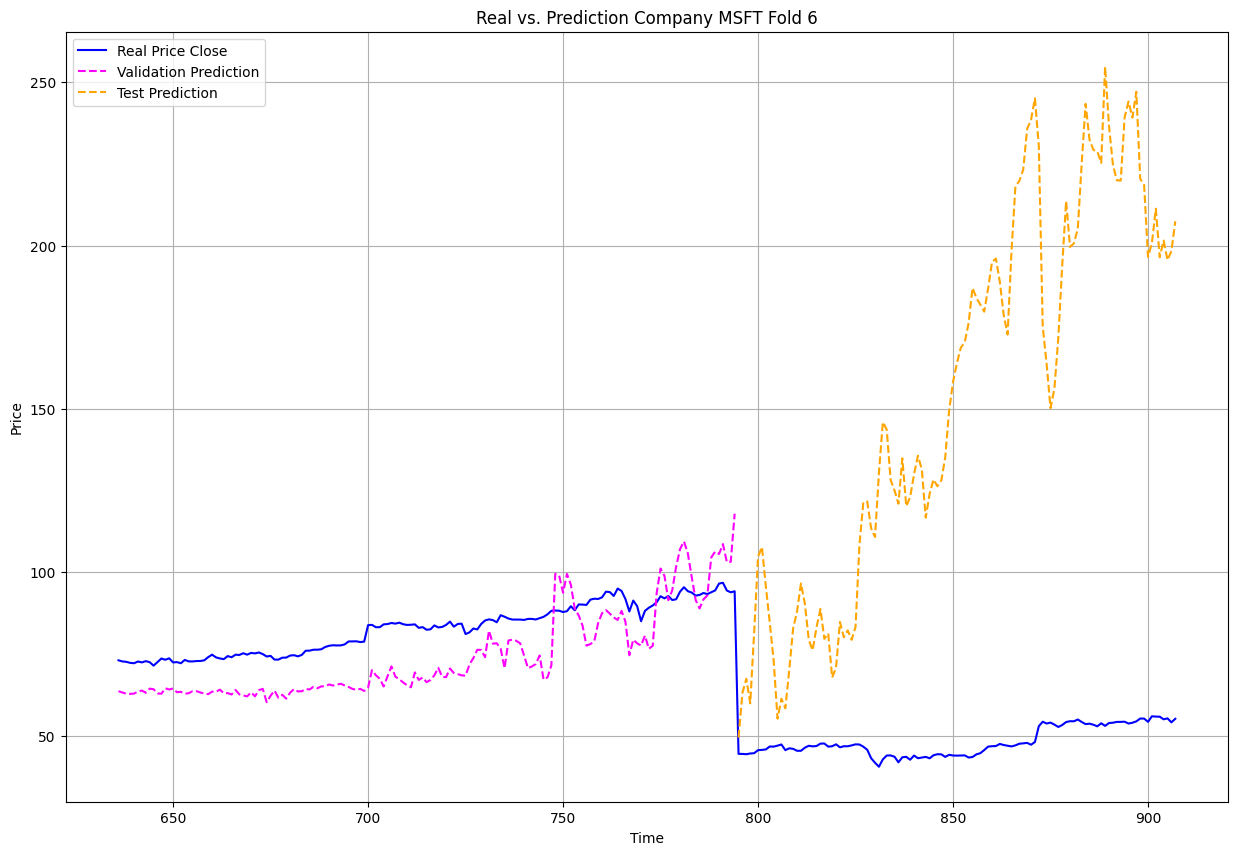

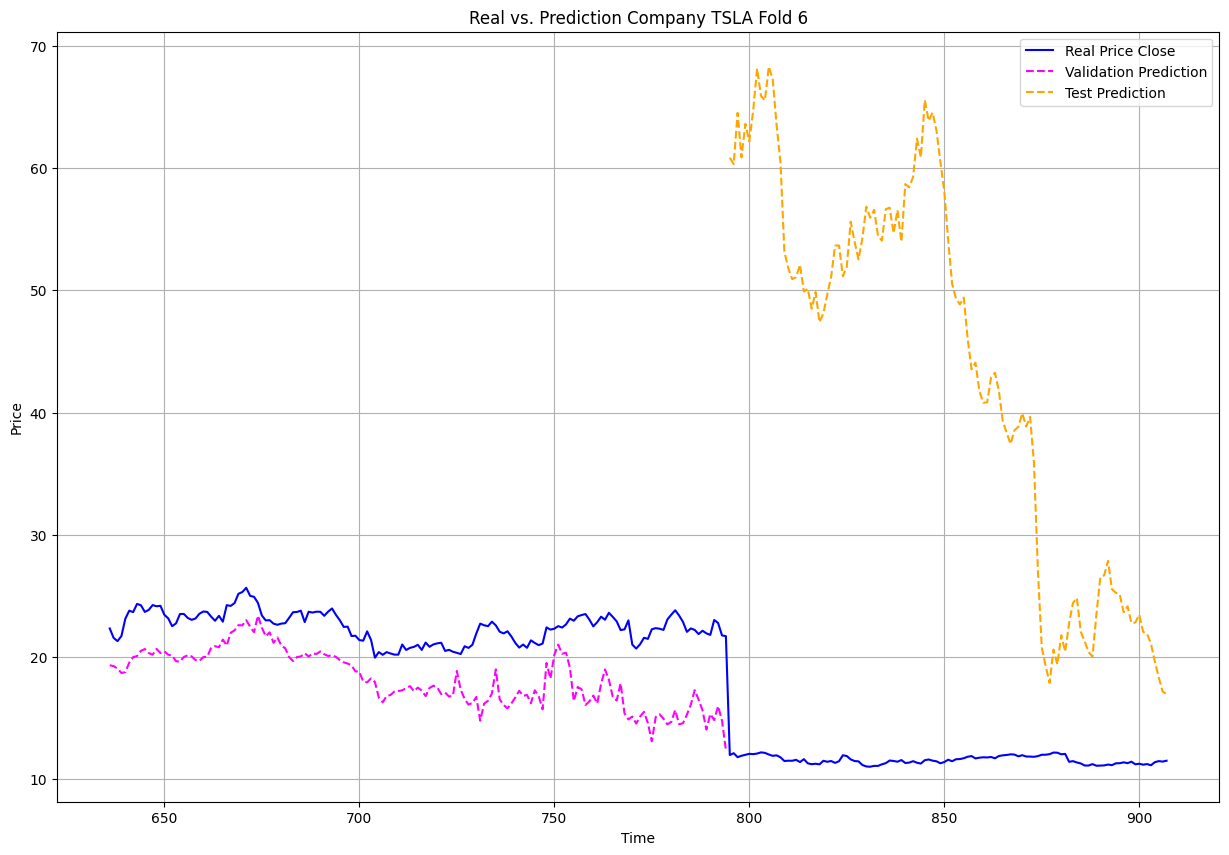

Fold_6 Done
Fold_7 Started


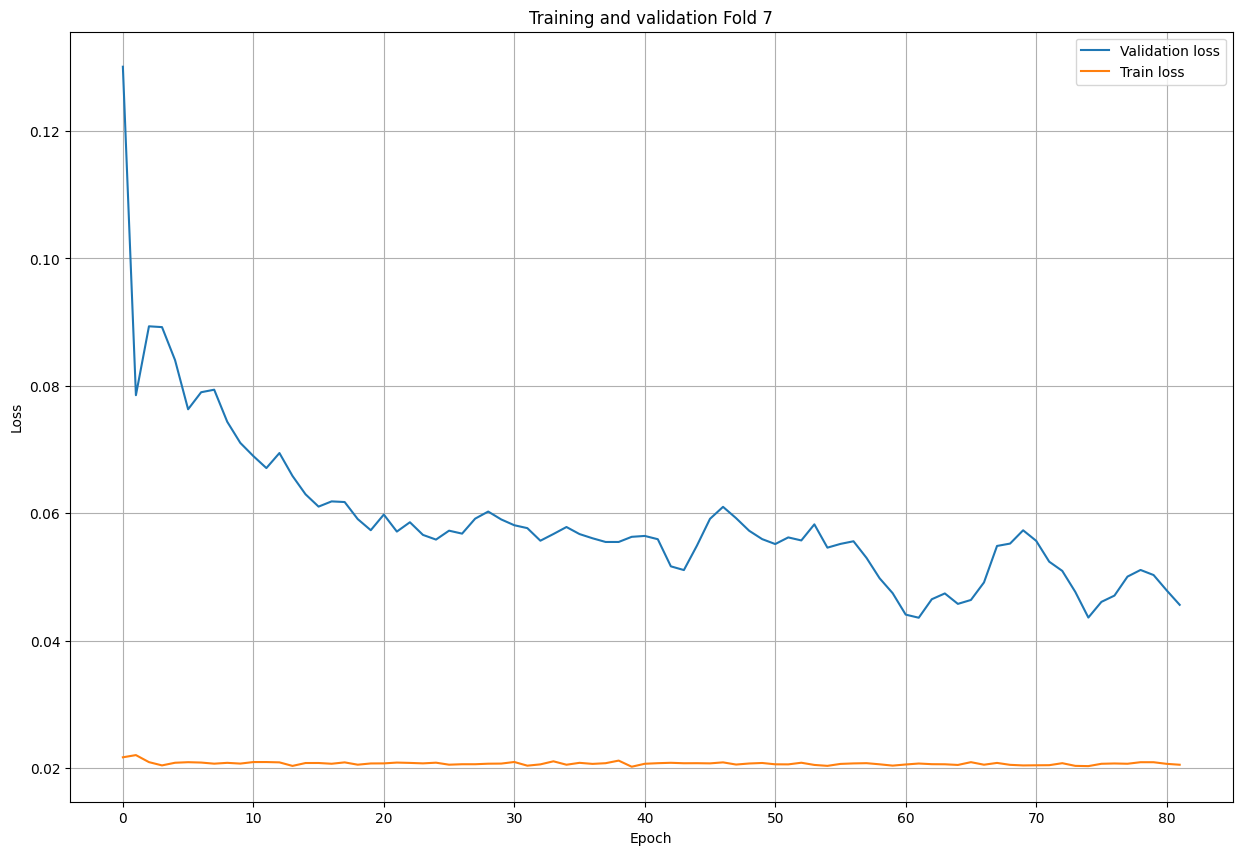

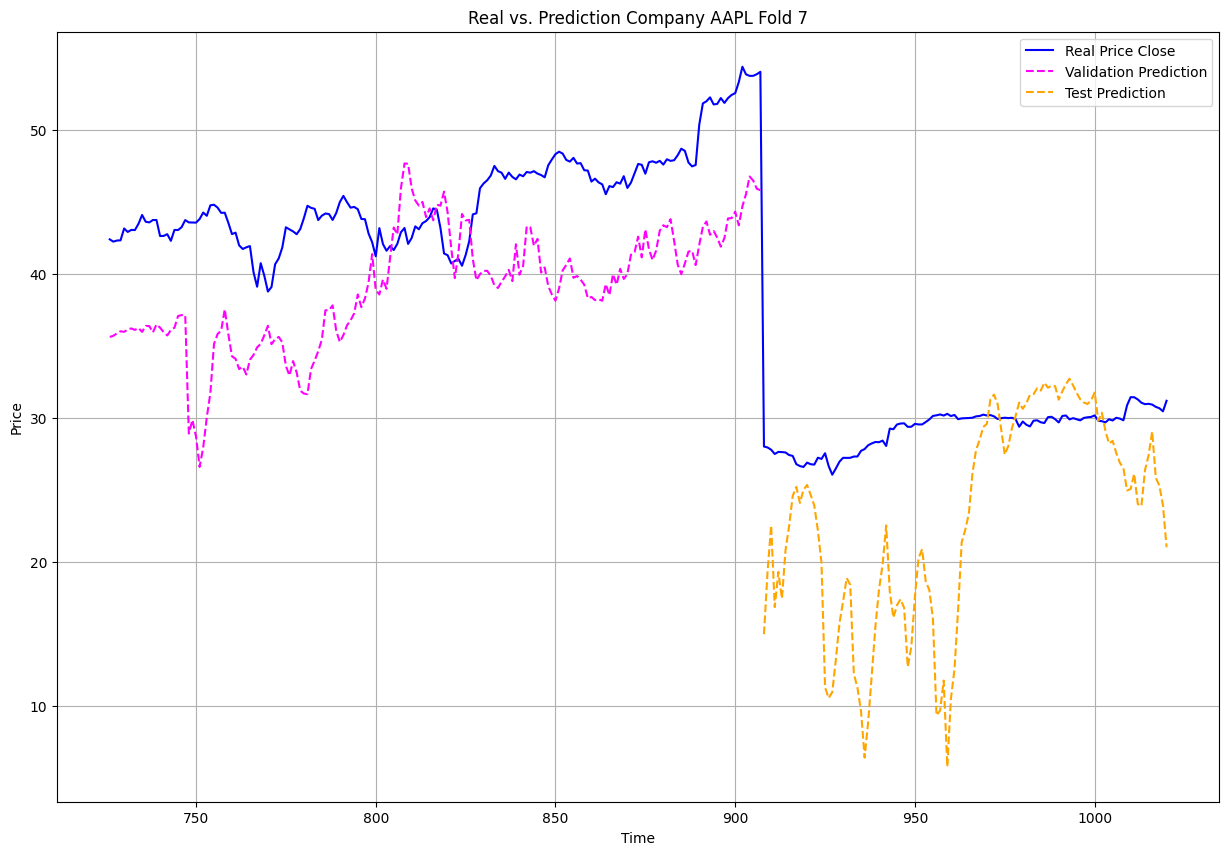

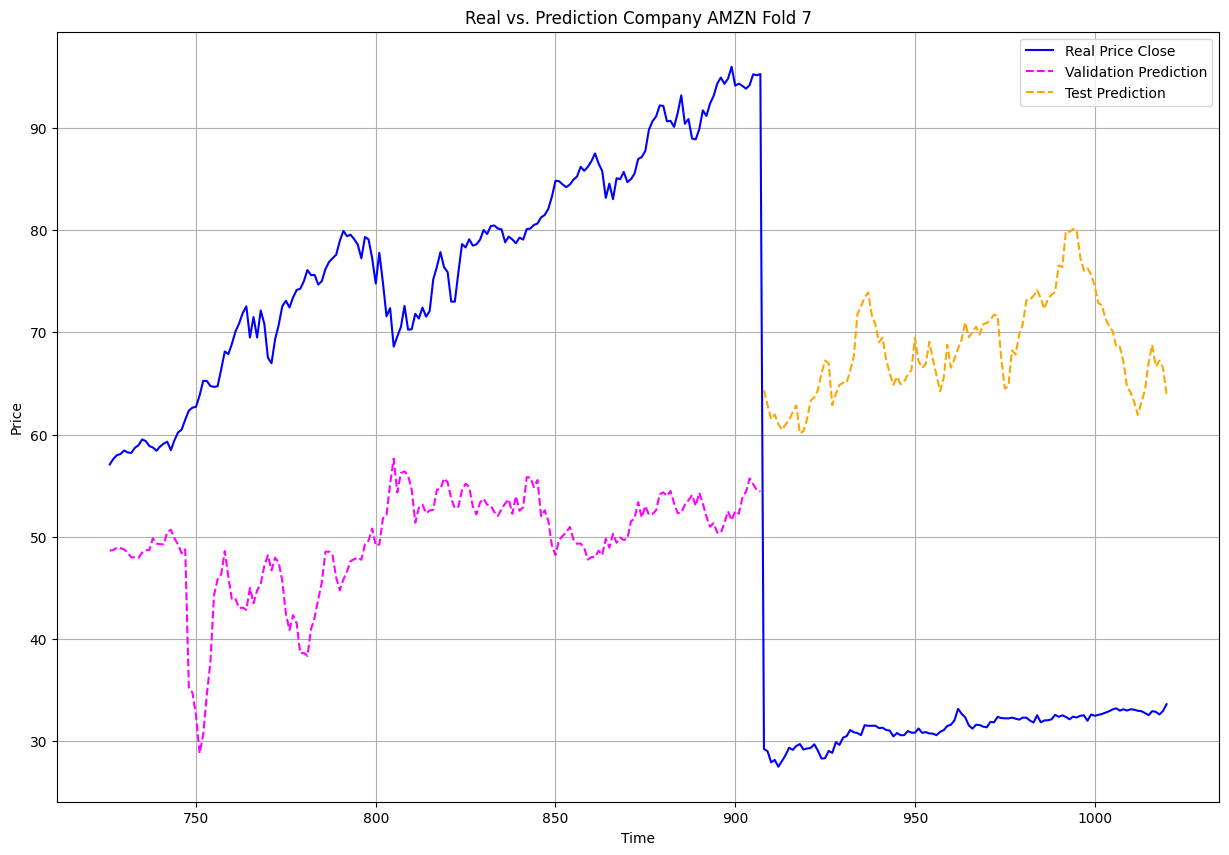

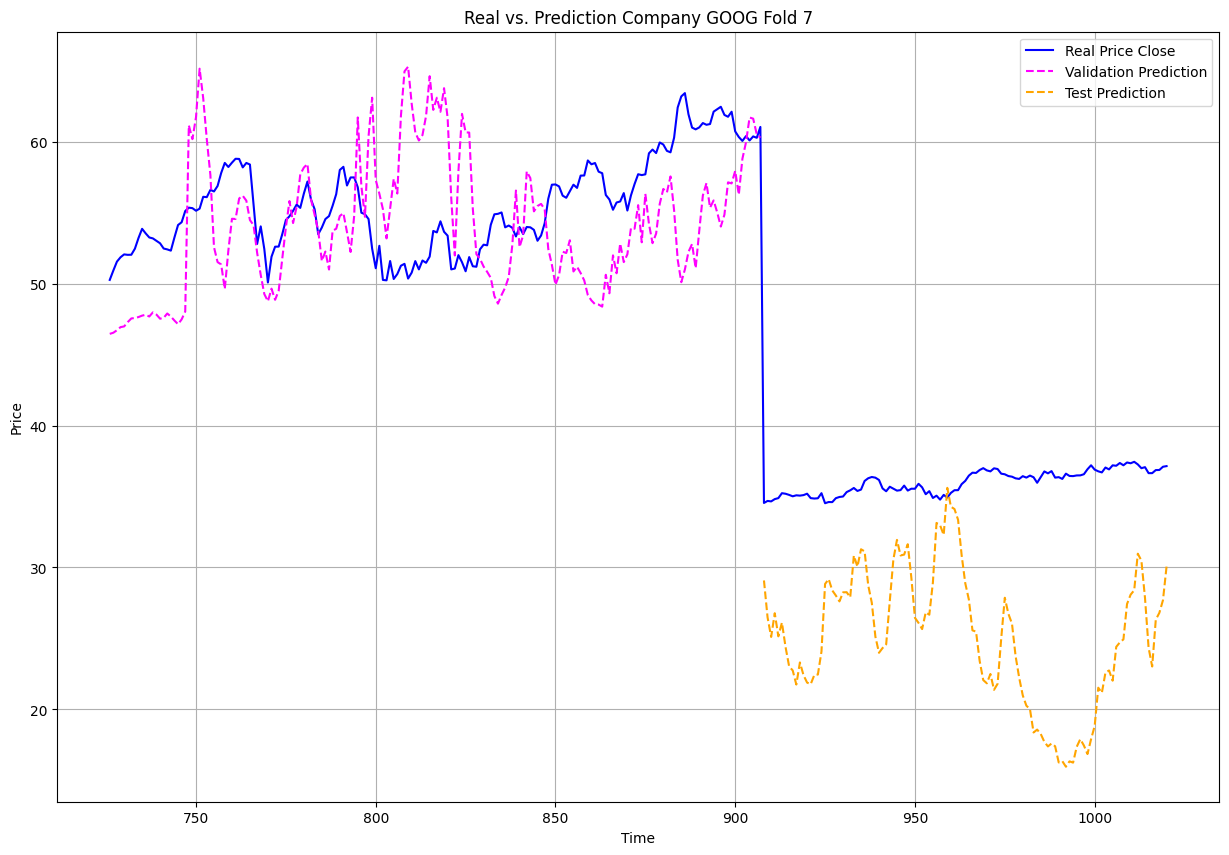

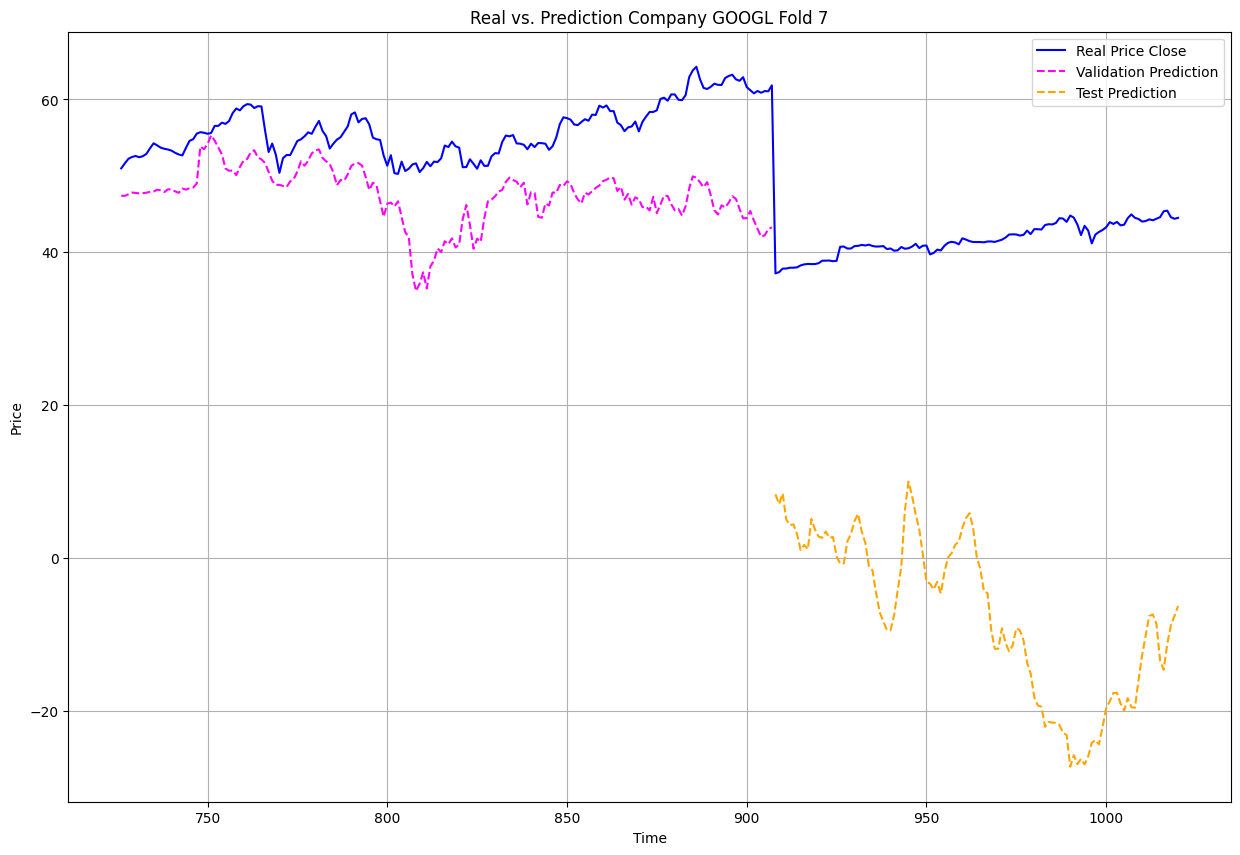

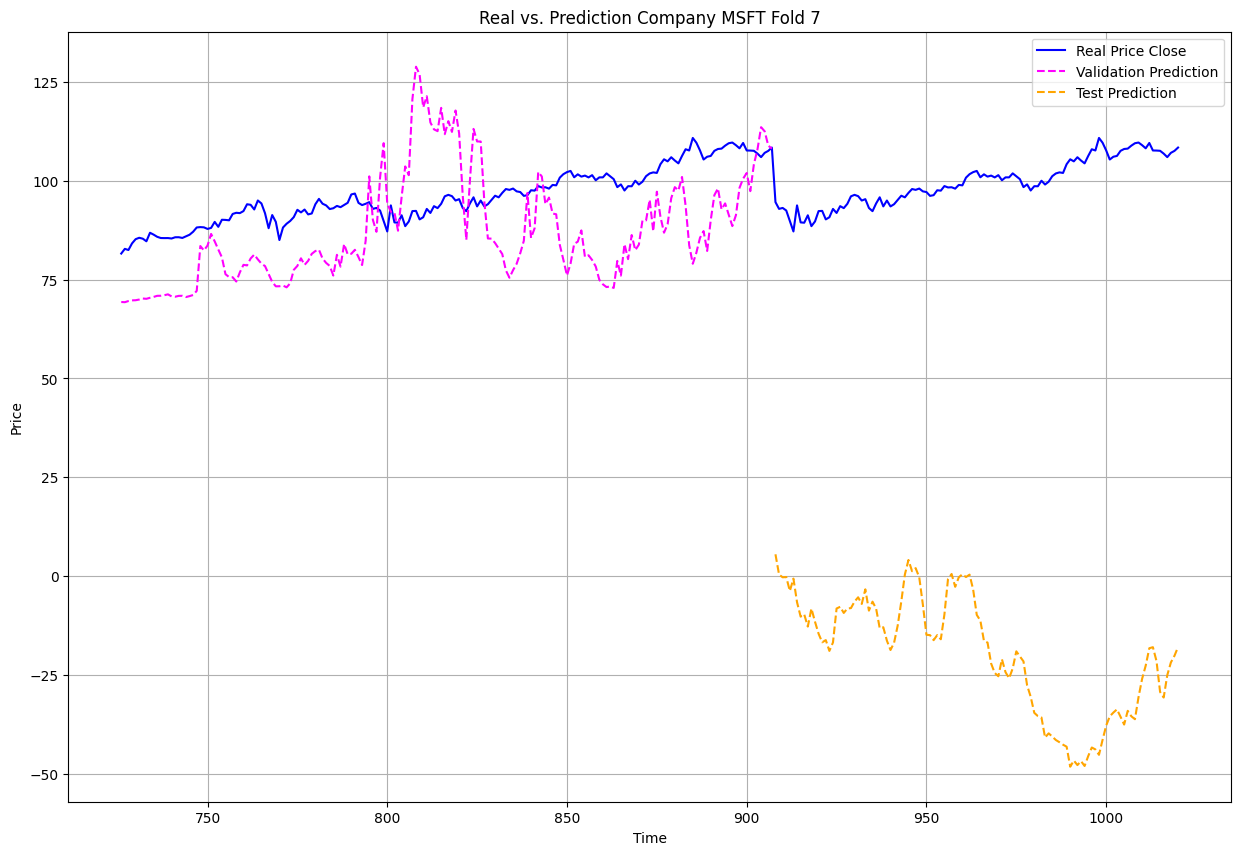

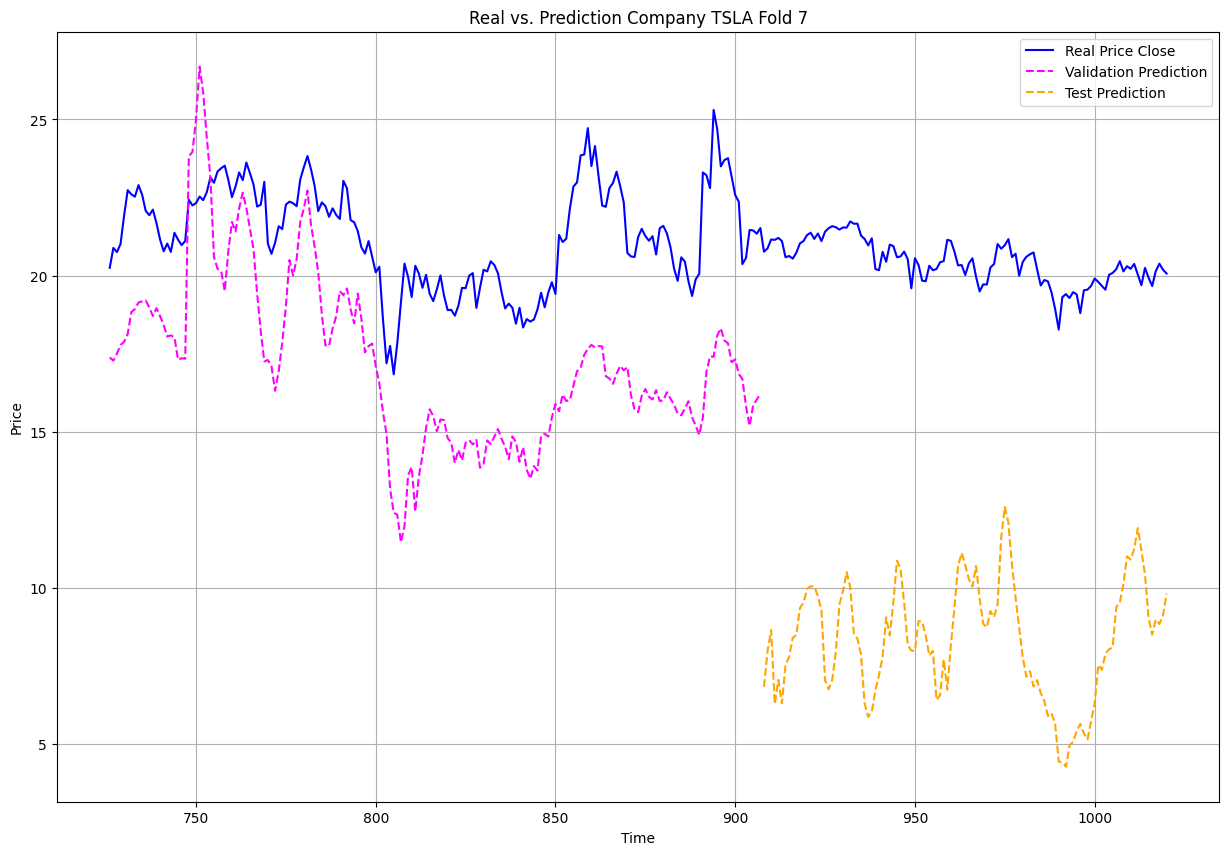

Fold_7 Done
Fold_8 Started


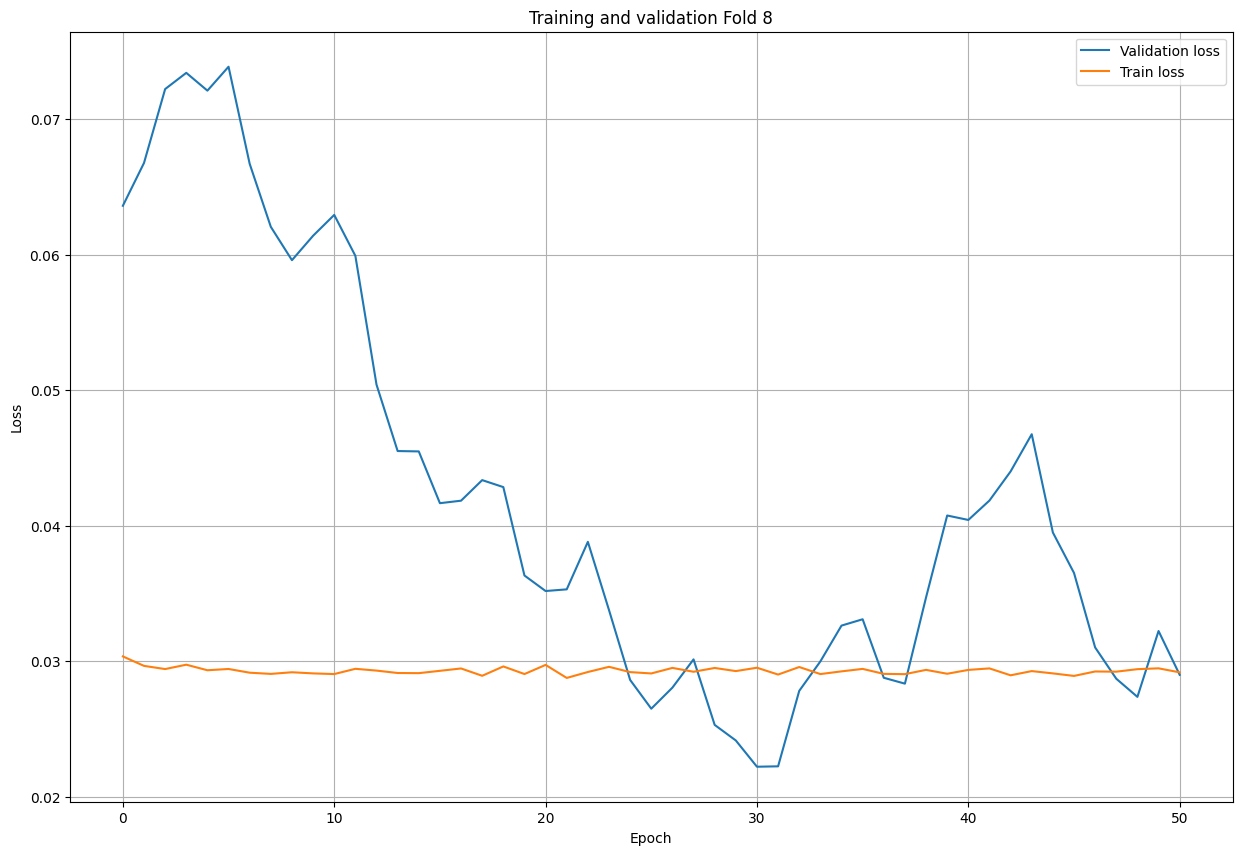

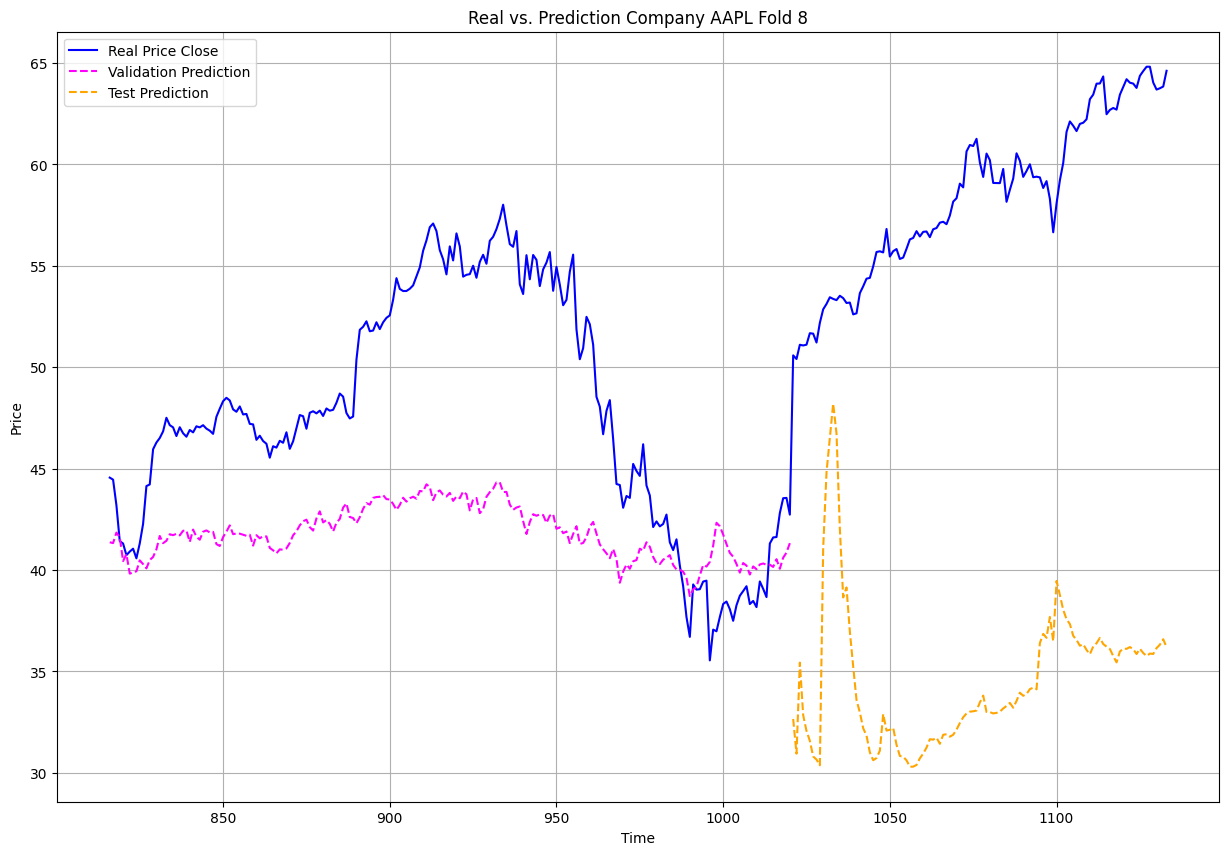

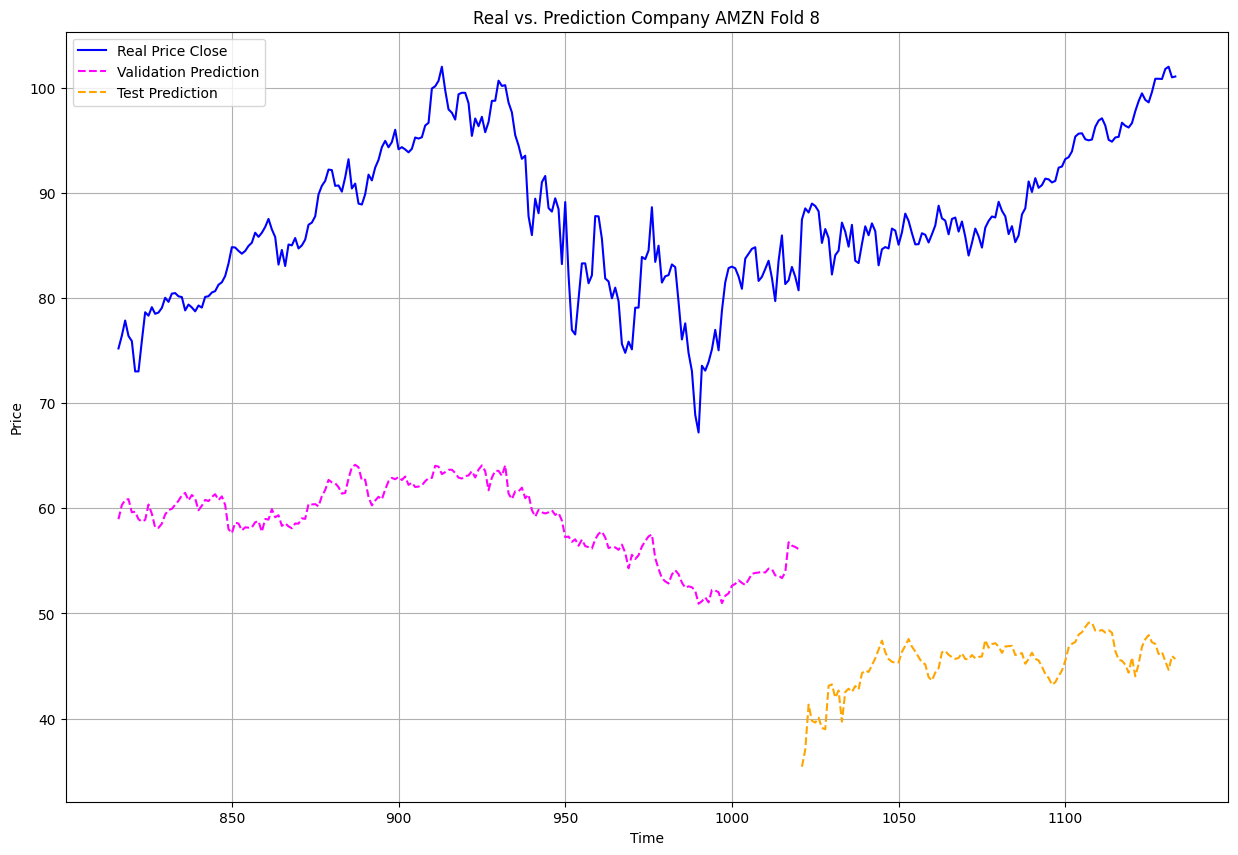

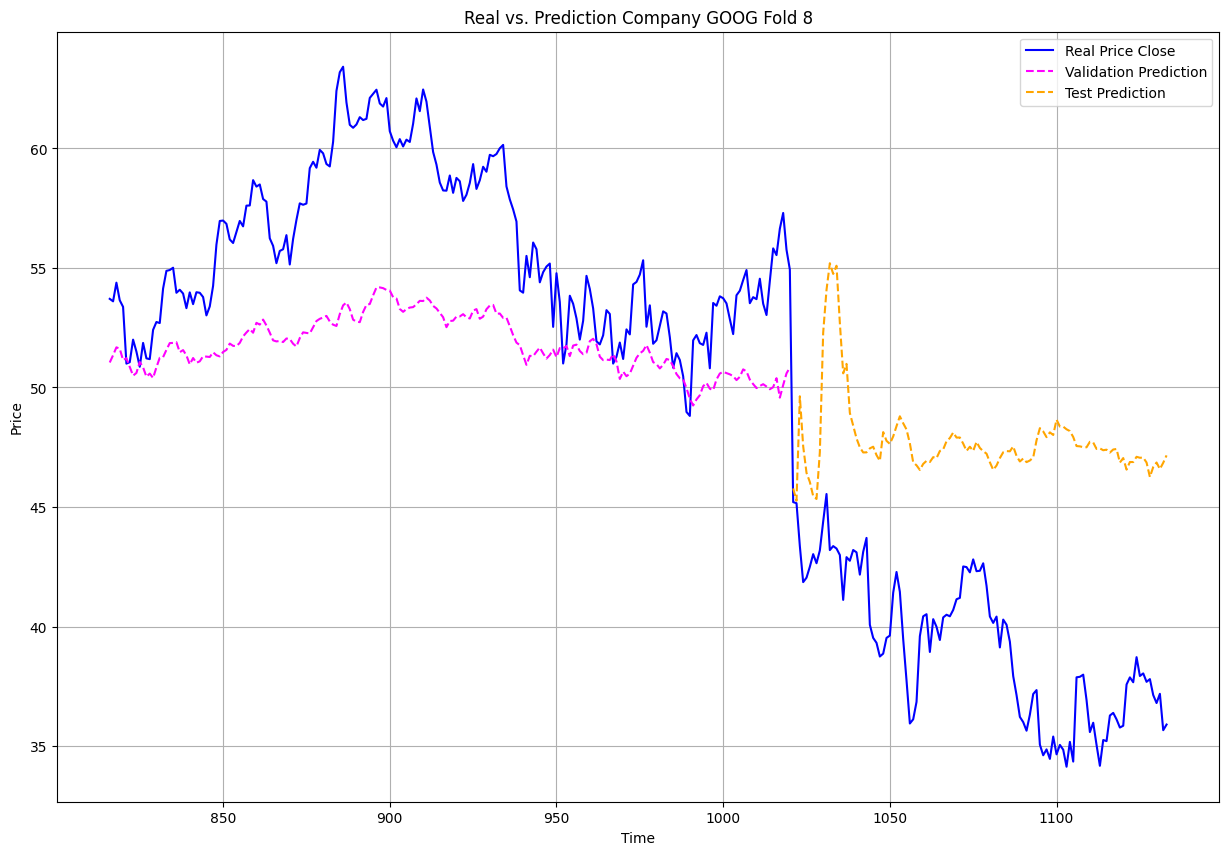

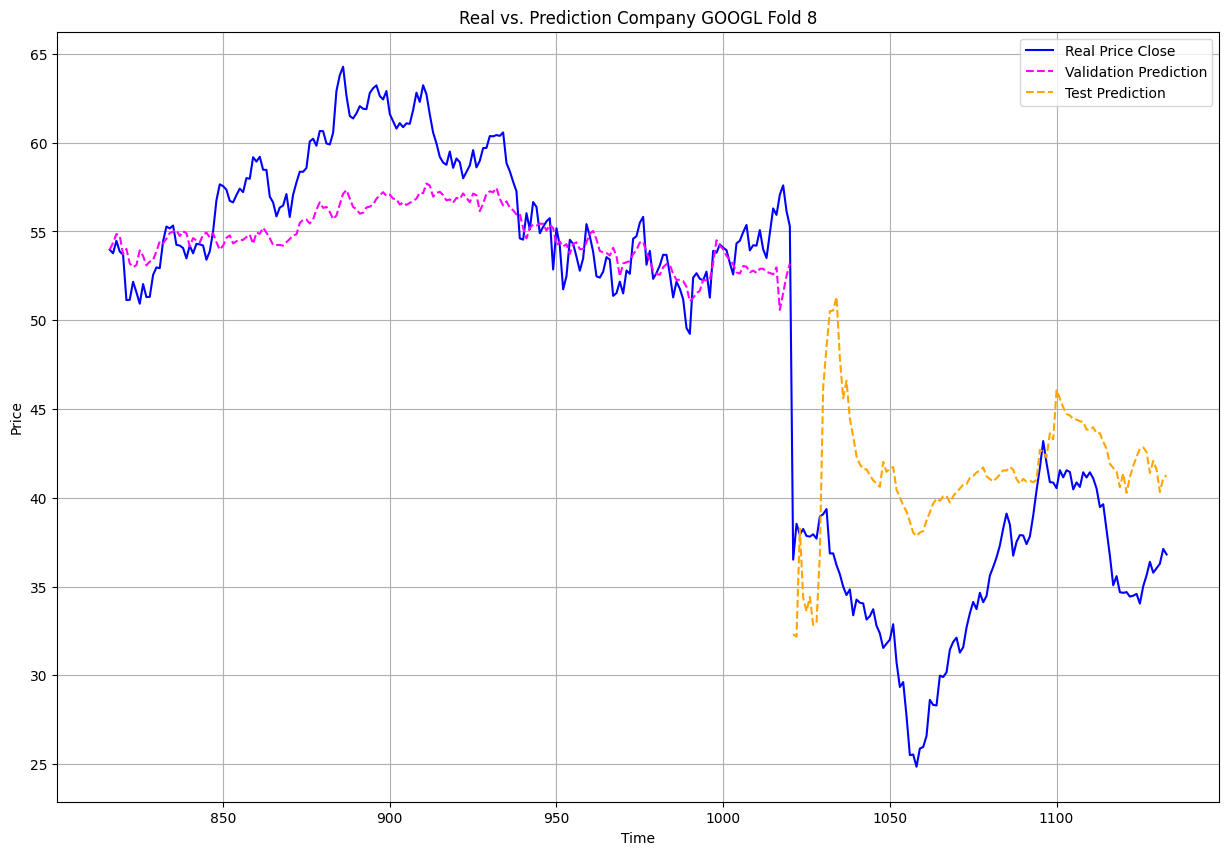

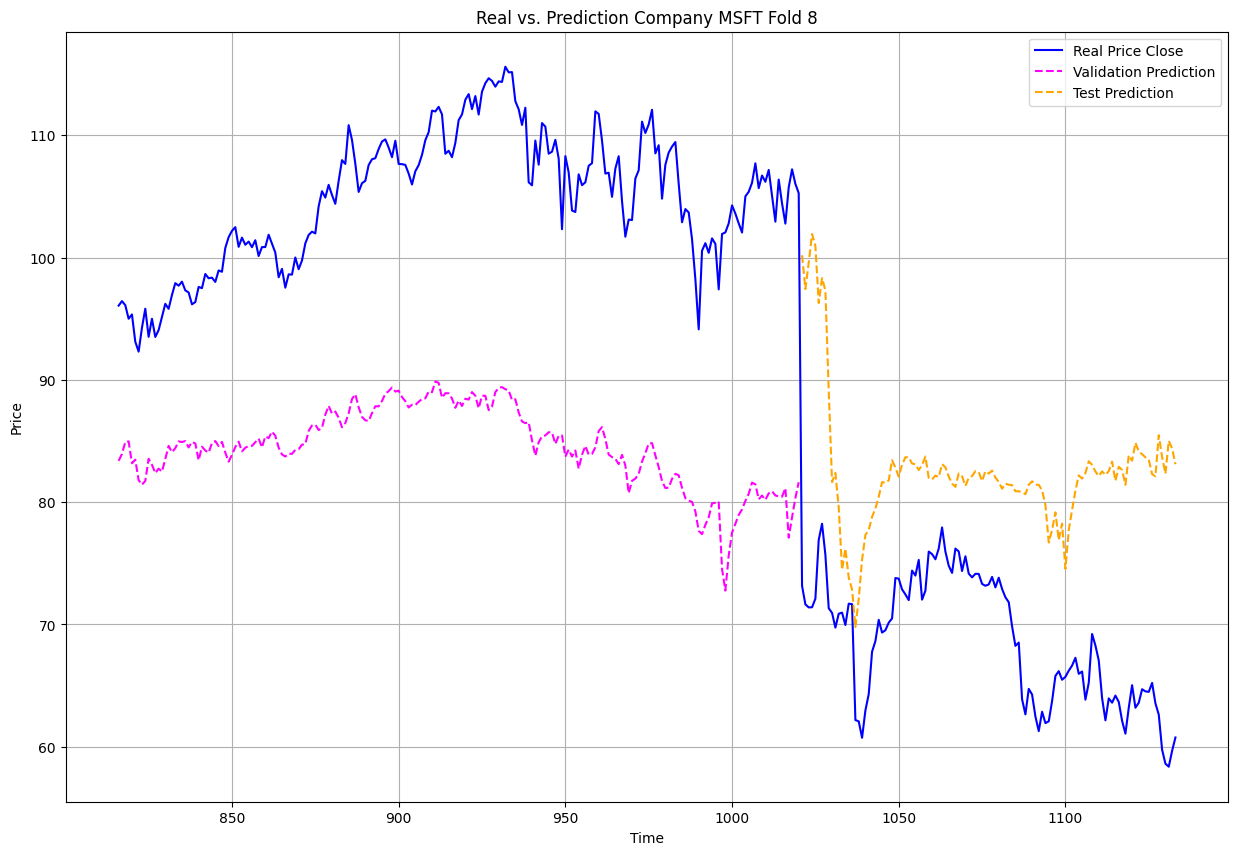

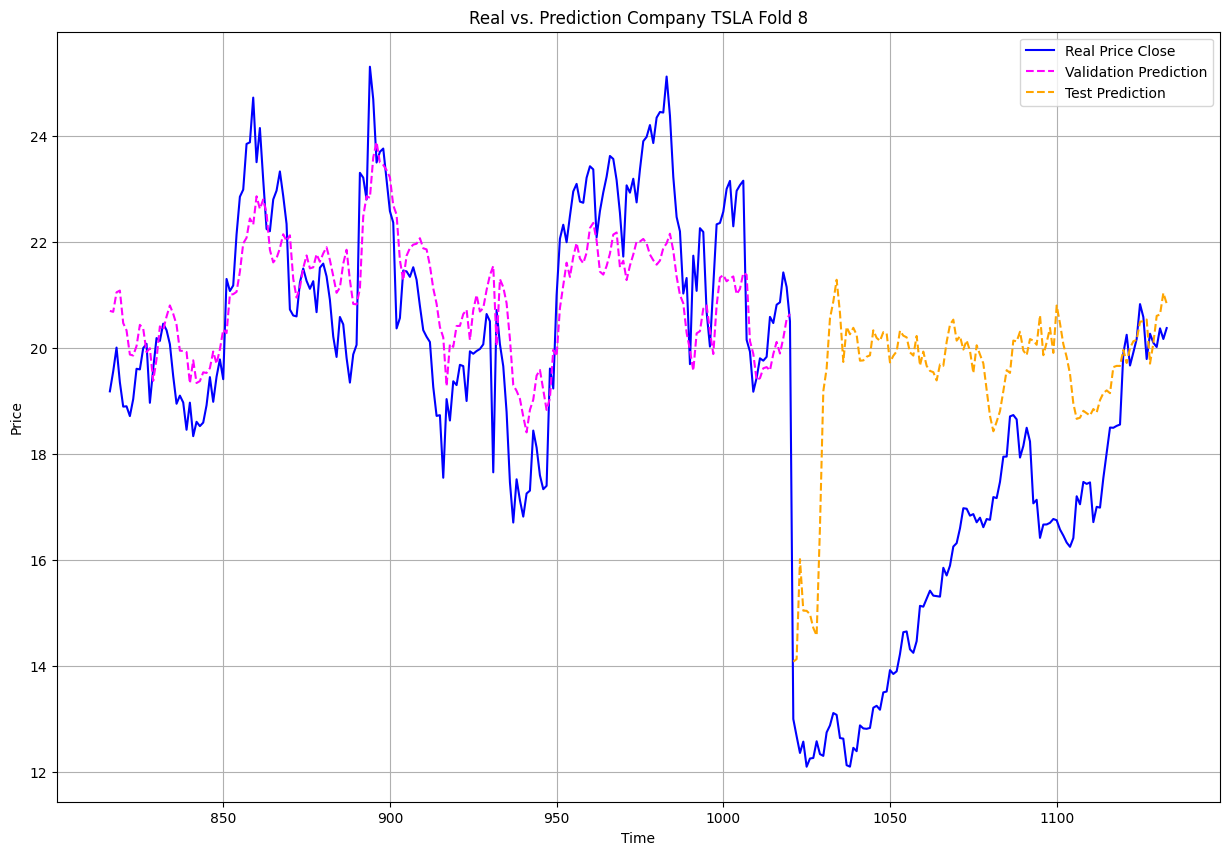

Fold_8 Done
Fold_9 Started


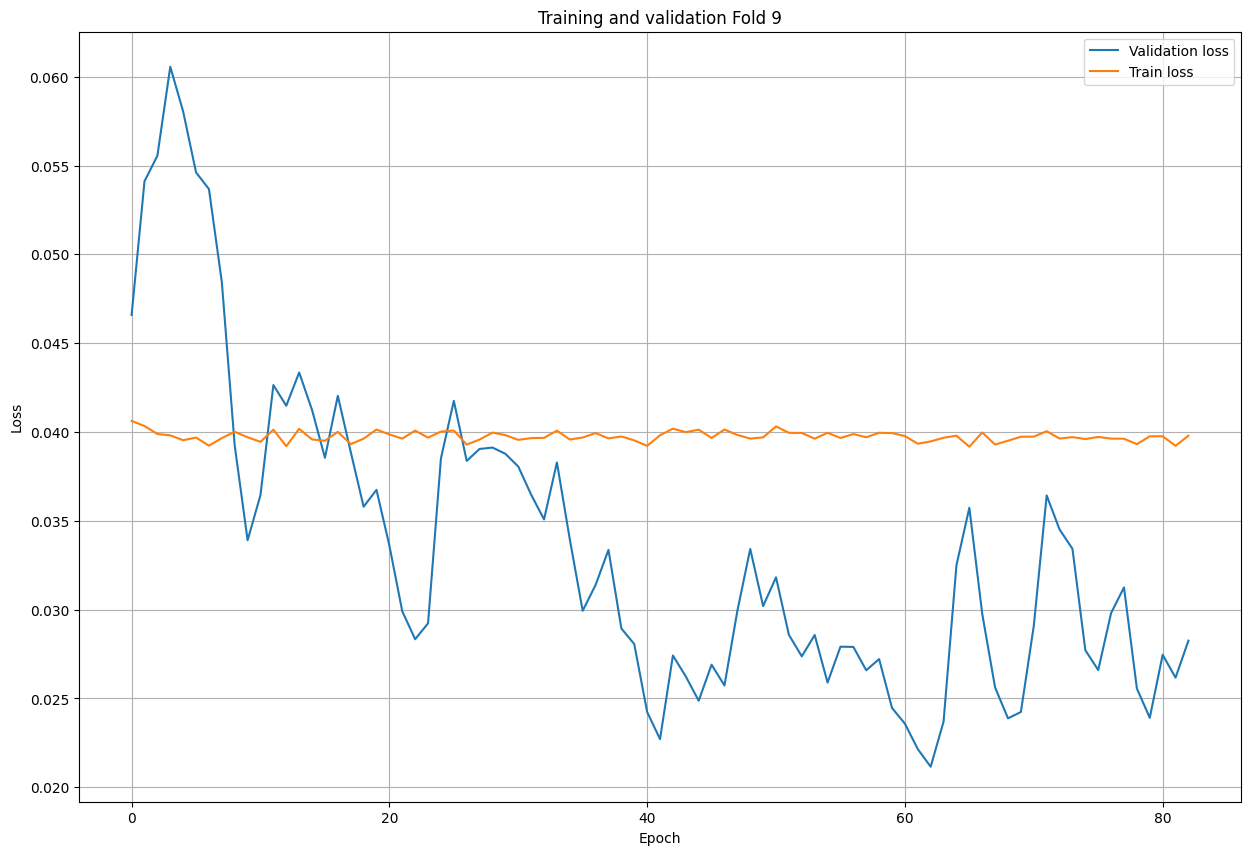

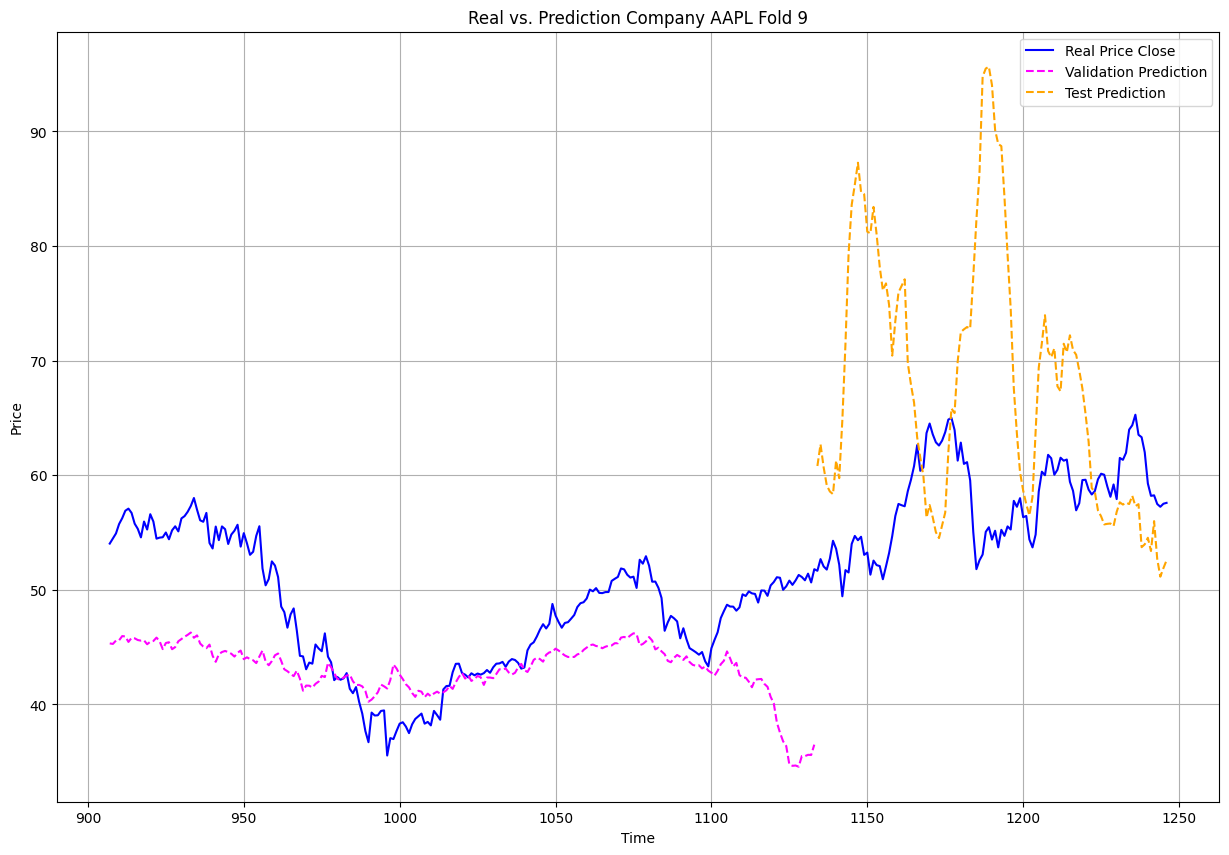

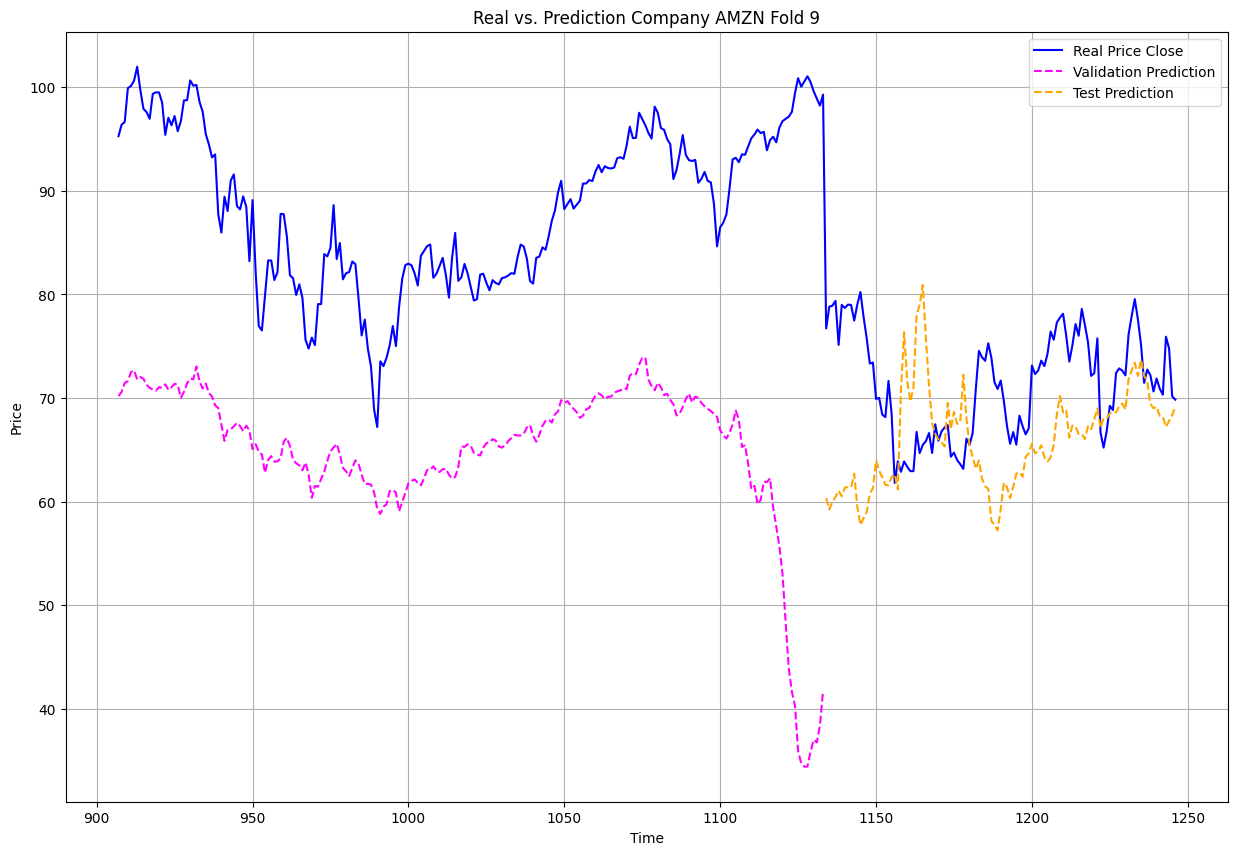

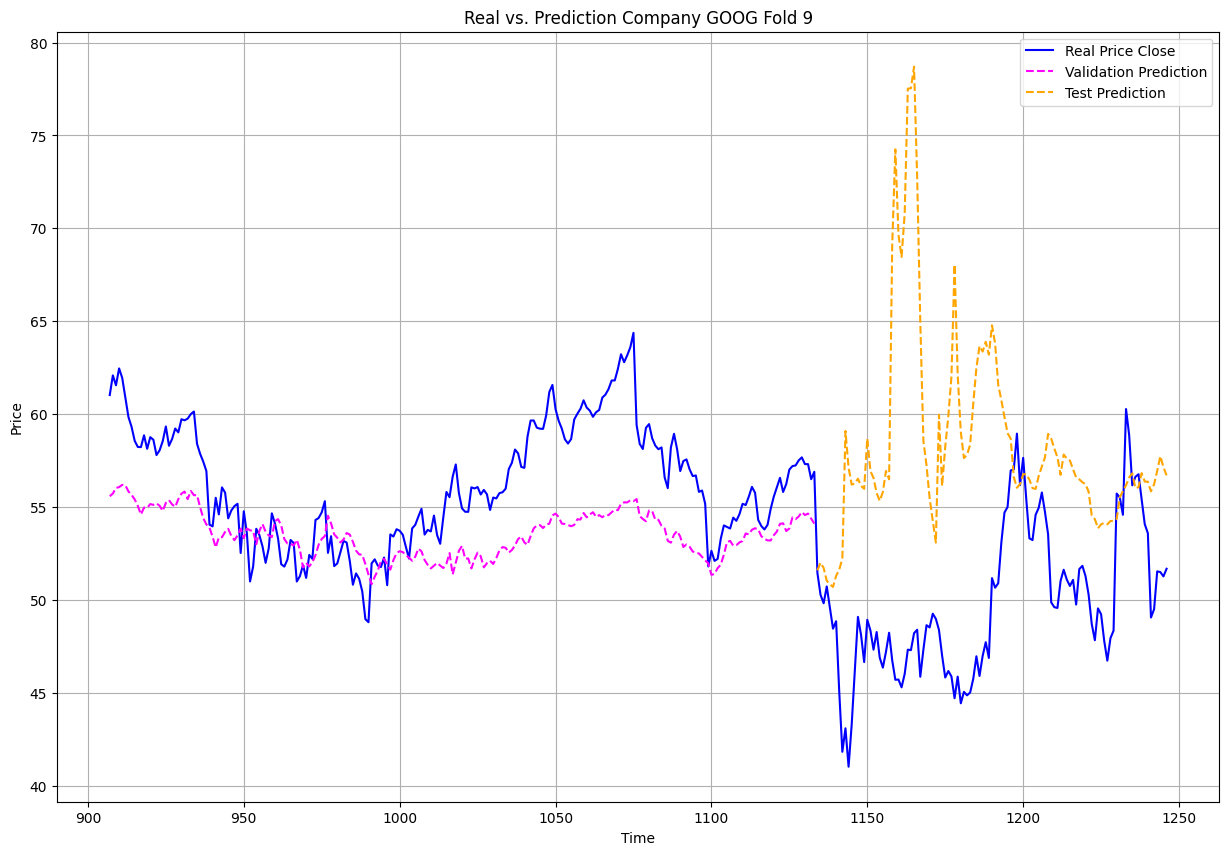

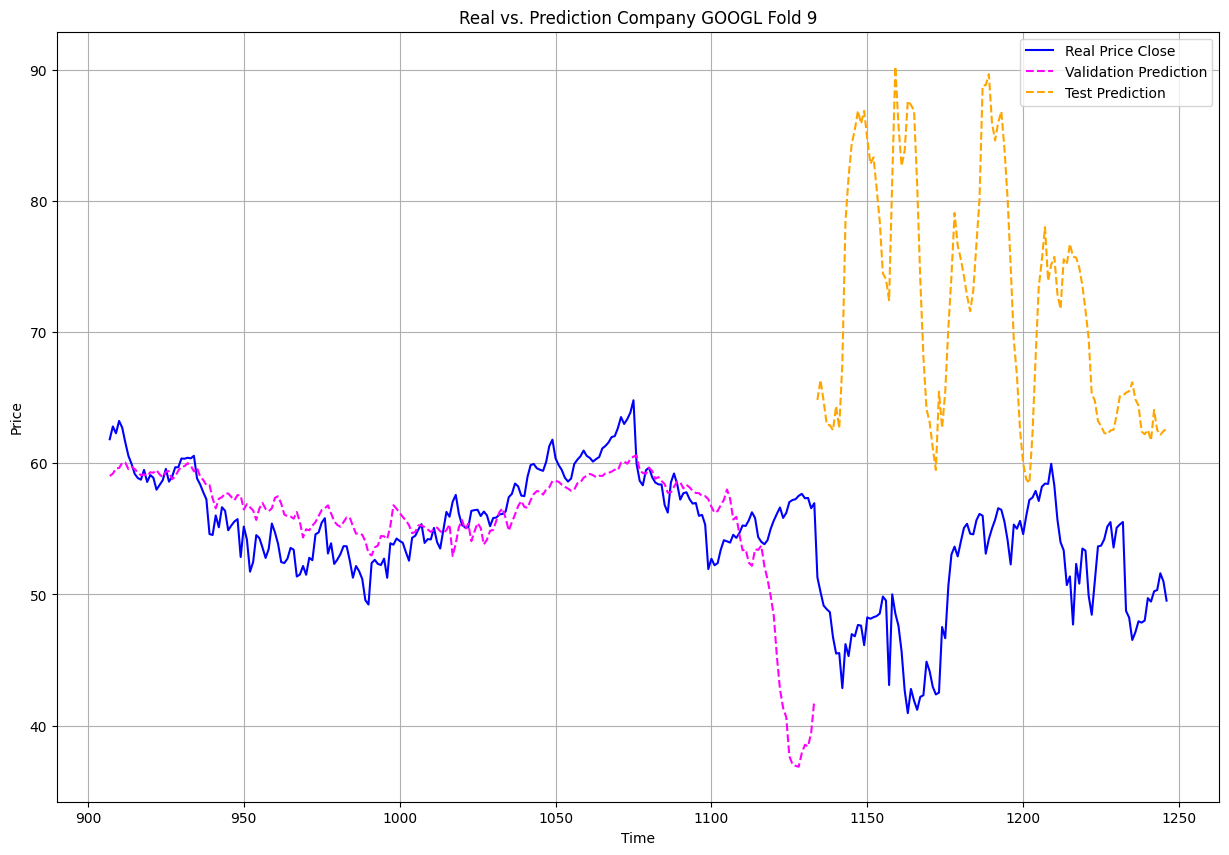

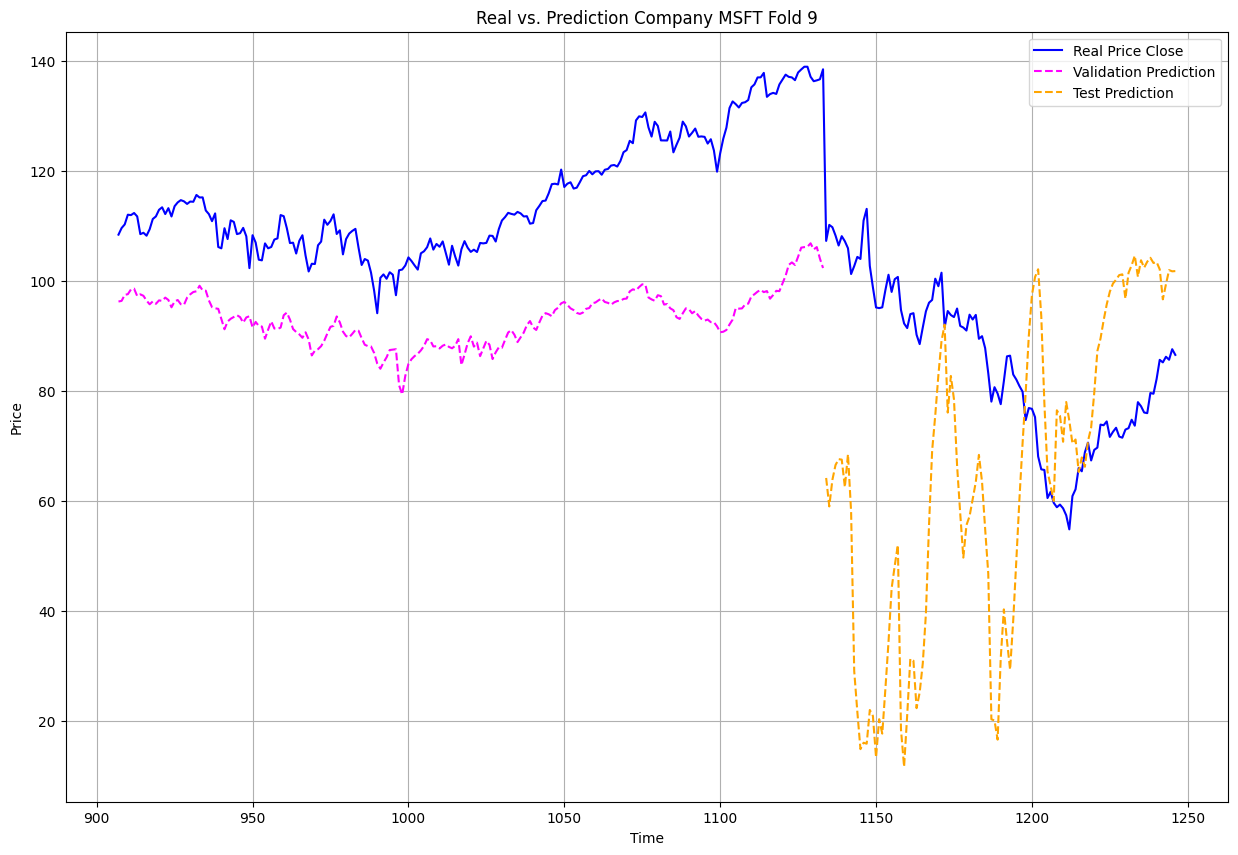

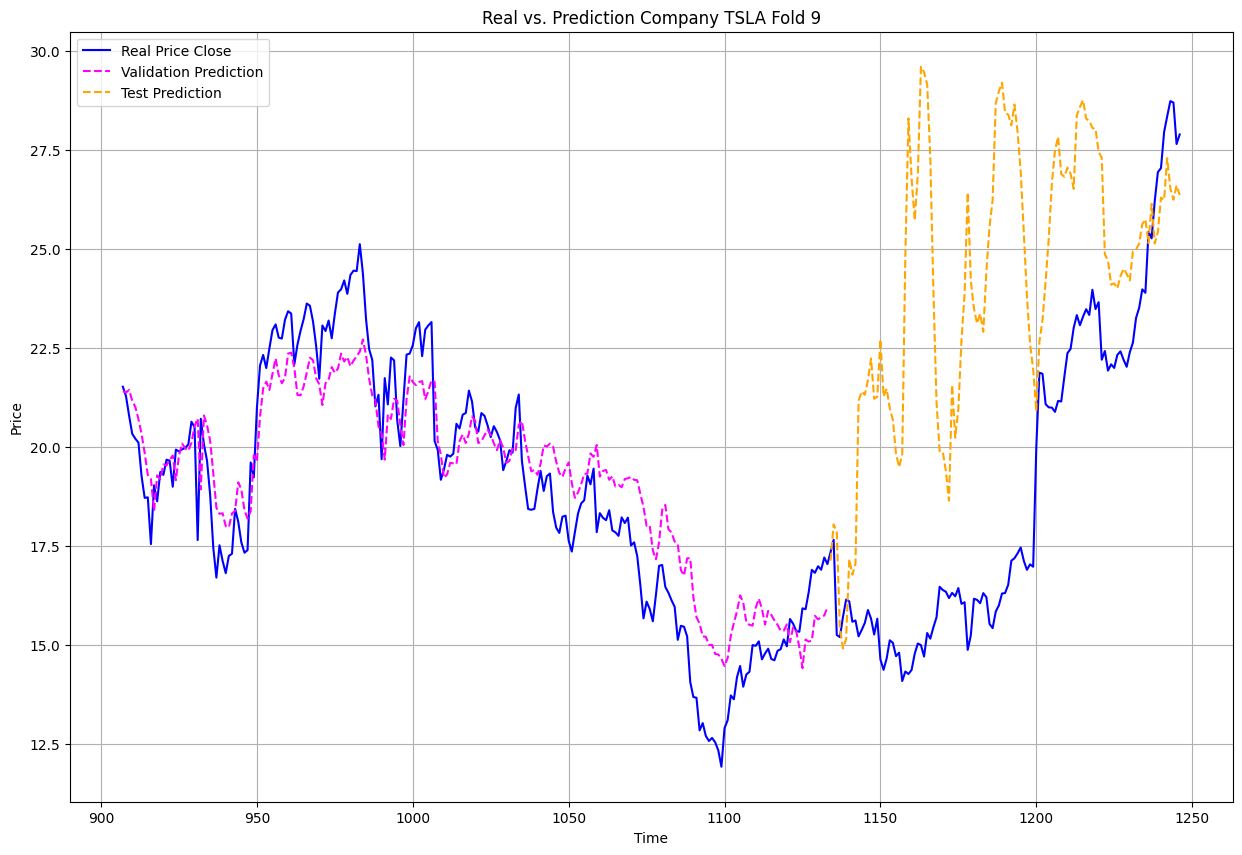

Fold_9 Done


In [17]:
val_losses=[]
train_losses=[]
history_ = []
model = tuner.hypermodel.build(best_hps)

# Reiniciar el índice de las capas en tu modelo
counter_fold=0
n_splits_CV=10

# Entrenar el modelo
for i in range(n_splits_CV):#cv (10)
    Fold = 'Fold_' + str(counter_fold)
    counter_fold += 1
    print(f'{Fold} Started')
    # Crear directorio para cada fold si no existe
    if not os.path.exists(os.path.join(dir, Fold)):
      os.makedirs(os.path.join(dir, Fold))

    history=model.fit(x_train_combined[i], y_train_combined[i], epochs=1000, validation_data=(x_val_combined[i], y_val_combined[i]), shuffle=False, callbacks=[early_stop], verbose=False)
    history_.append(history)
    val_losses.append(history.history['val_loss'])
    train_losses.append(history.history['loss'])
    plt.figure(figsize=(15,10))
    plt.plot(history.history['val_loss'], label=f'Validation loss')
    plt.plot(history.history['loss'],  label=f'Train loss')

    plt.title(f'Training and validation Fold {i}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.savefig(os.path.join(dir,Fold,f'training_validation_fold{i}.png'))
    plt.show()
    plt.close()

    y_test1 = []
    y_val1 = []
    y_val_pred = []
    y_pred = []
    y_val_pred_normal=[]
    y_pred_normal=[]
    num_channels = 6
    y_val_pred_per_channel = [] # predicciones separadas por canal
    y_pred_per_channel = []

    for j in range(len(y_testA_[i])):
        y_test_channel = np.repeat(y_testA_[i][j], X_channels[0].shape[2], axis=1)
        y_test_channel_ = scalers[j].inverse_transform(y_test_channel)[:, -1]
        y_test1.append(y_test_channel_)

    for j in range(len(y_val_[i])):
        y_val_channel = np.repeat(y_val_[i][j], X_channels[0].shape[2], axis=1)
        y_val_channel_ = scalers[j].inverse_transform(y_val_channel)[:, -1]
        y_val1.append(y_val_channel_)

    #Predicciones
    y_val_pred.append(model.predict(x_val_combined[i], verbose=False))
    y_pred.append(model.predict(x_testA_combined[i], verbose=False))

    # Dividir la muestra en partes correspondientes a cada canal
    for sample in y_val_pred:
        y_val_pred_per_channel.append(tf.split(sample, num_channels, axis=1))

    for sample in y_pred:
        y_pred_per_channel.append(tf.split(sample, num_channels, axis=1))

    for xvc in range(len(y_val_pred_per_channel[0])):
      y_val_pred_channel = np.repeat(y_val_pred_per_channel[0][xvc], X_channels[0].shape[2], axis=1)
      y_val_pred_channel_=scalers[xvc].inverse_transform(y_val_pred_channel)[:, -1]
      y_val_pred_normal.append(y_val_pred_channel_)

    for ypc in range(len(y_pred_per_channel[0])):
      y_pred_channel = np.repeat(y_pred_per_channel[0][ypc], X_channels[0].shape[2], axis=1)
      y_pred_channel_= scalers[ypc].inverse_transform(y_pred_channel)[:, -1]
      y_pred_normal.append(y_pred_channel_)

    # Cálculo de métricas
    for k in range(len(y_test1)):
      t_mse = mse(y_pred_normal[k], y_test1[k])
      t_mses.append(t_mse)
      v_mse = mse(y_val_pred_normal[k], y_val1[k])
      v_mses.append(v_mse)

      t_mae = mae(y_pred_normal[k], y_test1[k])
      t_maes.append(t_mae)
      v_mae = mae(y_val_pred_normal[k], y_val1[k])
      v_maes.append(v_mae)

      t_mape = mape(y_pred_normal[k], y_test1[k])
      t_mapes.append(t_mape)
      v_mape = mape(y_val_pred_normal[k], y_val1[k])
      v_mapes.append(v_mape)

      t_rmse = rmse(y_pred_normal[k], y_test1[k])
      t_rmses.append(t_rmse)
      v_rmse = rmse(y_val_pred_normal[k], y_val1[k])
      v_rmses.append(v_rmse)

      t_mpe = mpe(y_pred_normal[k], y_test1[k])
      t_mpes.append(t_mpe)
      v_mpe = mpe(y_val_pred_normal[k], y_val1[k])
      v_mpes.append(v_mpe)

      mse_t_p.append(t_mse)
      mse_v_p.append(v_mse)
      mae_t_p.append(t_mae)
      mae_v_p.append(v_mae)
      mape_t_p.append(t_mape)
      mape_v_p.append(v_mape)
      rmse_t_p.append(t_rmse)
      rmse_v_p.append(v_rmse)
      mpe_t_p.append(t_mpe)
      mpe_v_p.append(v_mpe)

      names_dict = {0: 'AAPL', 1: 'AMZN', 2: 'GOOG', 3: 'GOOGL', 4: 'MSFT', 5: 'TSLA'}
      names = names_dict.get(k, 'Unknown')

      v_time=range(x_train_[i][0].shape[0],x_train_[i][0].shape[0]+len(y_val1[k]))
      t_time=range(x_train_[i][0].shape[0]+len(y_val1[k]),x_train_[i][0].shape[0]+len(y_val1[k])+len(y_test1[k]))
      r_time=range(x_train_[i][0].shape[0],x_train_[i][0].shape[0]+len(y_val1[k])+len(y_test1[k]))

      real=np.concatenate((y_val1[k],y_test1[k]))
      plt.figure(figsize=(15,10))
      plt.plot(r_time,real,label='Real Price Close',color='blue',linestyle='-')
      plt.plot(v_time,y_val_pred_normal[k],label='Validation Prediction',color='magenta',linestyle='--')
      plt.plot(t_time,y_pred_normal[k], label='Test Prediction',color='orange',linestyle='--')
      plt.legend()

      plt.title(f'Real vs. Prediction Company {names} Fold {i}')
      plt.ylabel('Price')
      plt.xlabel('Time')
      plt.grid()
      plt.savefig(os.path.join(dir,Fold,f'real_vs_pred_company_{names}.png'))
      plt.show()
      plt.close()

    if counter_fold==10:
        model.save_weights(f'/content/drive/MyDrive/Price_Prediction/Modelos/Weights/model_{arch}_{ticker}.h5')
    print(f'{Fold} Done')

In [30]:
y_pred_normal[0]

array([60.811344, 62.70076 , 60.697826, 59.120804, 58.58484 , 58.35282 ,
       61.286964, 59.75069 , 64.811874, 71.46492 , 79.33569 , 83.59702 ,
       85.36495 , 87.273384, 84.71729 , 84.52447 , 81.259926, 81.11554 ,
       83.41937 , 81.001144, 78.17004 , 76.13846 , 76.74617 , 74.85081 ,
       70.44209 , 73.47293 , 75.9427  , 76.5234  , 77.1032  , 69.77717 ,
       67.93268 , 66.35191 , 63.306854, 61.54157 , 59.940395, 56.30591 ,
       57.40868 , 56.329166, 55.03277 , 54.51644 , 55.632305, 56.749092,
       62.010845, 65.83122 , 65.4292  , 69.93911 , 72.49367 , 72.7368  ,
       72.936035, 72.79948 , 77.36334 , 82.27785 , 86.440544, 94.7833  ,
       95.490776, 95.65165 , 94.04639 , 90.13447 , 88.907684, 88.72591 ,
       84.29116 , 79.24484 , 74.55526 , 67.58565 , 63.60081 , 60.25894 ,
       58.663506, 57.480717, 56.493748, 58.1277  , 63.832203, 69.38996 ,
       71.533165, 73.96883 , 70.84387 , 70.30881 , 71.07441 , 67.76287 ,
       67.32444 , 71.47886 , 70.735405, 72.21655 , 

In [31]:
t_mse2 = mse(y_pred_normal[0], y_test1[0])
t_mse2

288.1192206687826

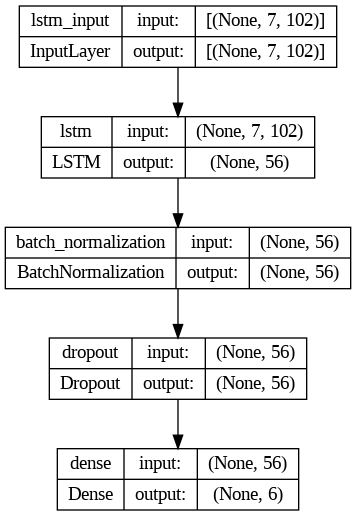

In [18]:
plot_model(model, to_file='model.png',show_shapes=True, show_layer_names=True)

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 56)                35616     
                                                                 
 batch_normalization (Batch  (None, 56)                224       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 56)                0         
                                                                 
 dense (Dense)               (None, 6)                 342       
                                                                 
Total params: 36182 (141.34 KB)
Trainable params: 36070 (140.90 KB)
Non-trainable params: 112 (448.00 Byte)
_________________________________________________________________


In [21]:
from pandas import concat
dfhistory = pd.DataFrame()

for i in range(len(history_)):
    # historial de entrenamiento del modelo actual
    history_data = pd.DataFrame(history_[i].history)
    history_data['fold'] = i
    dfhistory = concat([dfhistory, history_data], ignore_index=True)

dfhistory.to_csv(project_path+f'/Resultados/{arch}_historyComplete.csv',index=False)

In [51]:
max_train_epochs = max(len(losses) for losses in train_losses)
max_train_epochs

298

Promedio de la perdida de entrenamiento y validacion

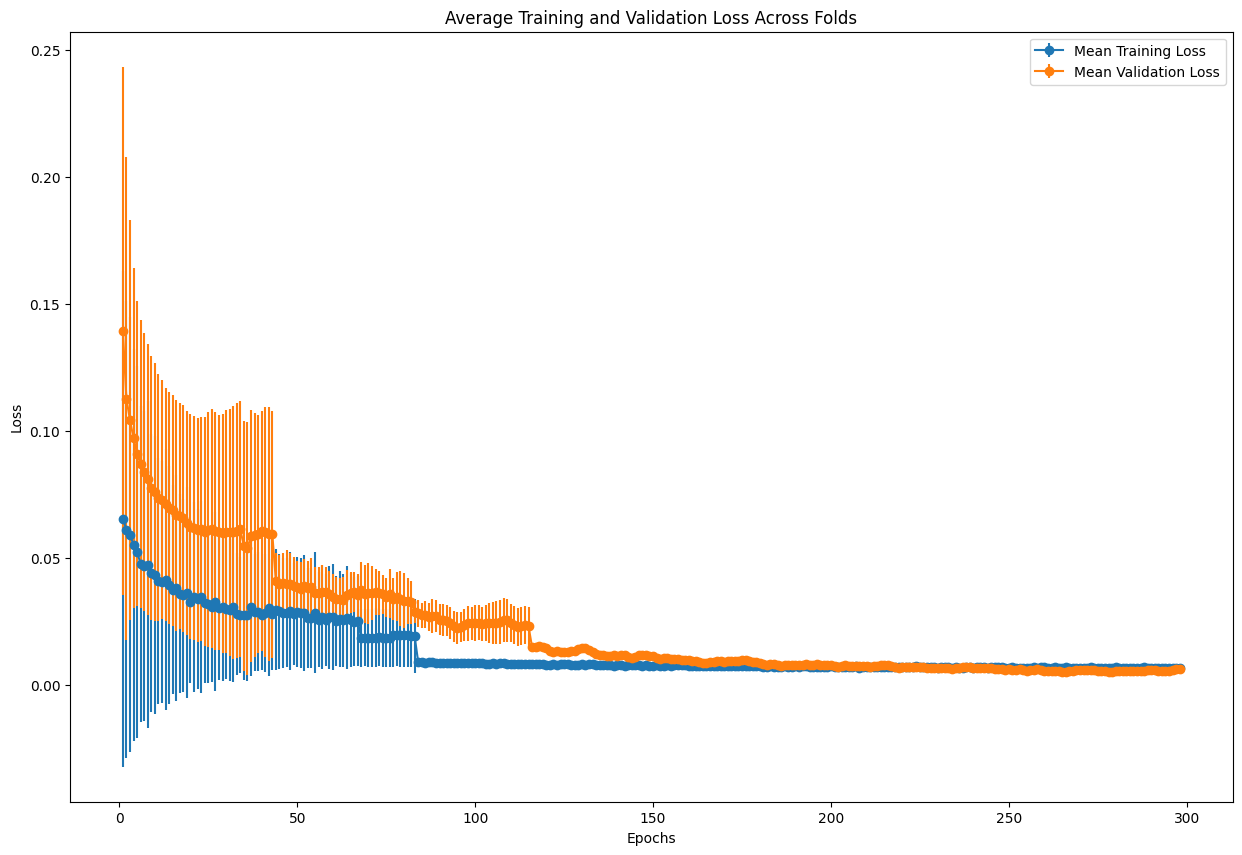

['0', '1', '2', '3', '4', '5'] done


In [22]:
max_train_epochs = max(len(losses) for losses in train_losses)
max_val_epochs = max(len(losses) for losses in val_losses)

padded_train_losses = [np.pad(losses, (0, max_train_epochs - len(losses)), mode='constant', constant_values=np.nan)
                    for losses in train_losses]

padded_val_losses = [np.pad(losses, (0, max_val_epochs - len(losses)), mode='constant', constant_values=np.nan)
                    for losses in val_losses]

mean_train_loss = np.nanmean(padded_train_losses, axis=0)
std_train_loss = np.nanstd(padded_train_losses, axis=0)

overall_mse_train.append(np.mean(mean_train_loss))
overall_std_train.append(np.std(mean_train_loss))

mean_val_loss = np.nanmean(padded_val_losses, axis=0)
std_val_loss = np.nanstd(padded_val_losses, axis=0)

overall_mse_val.append(np.mean(mean_val_loss))
overall_std_val.append(np.std(mean_val_loss))

plt.figure(figsize=(15,10))
plt.errorbar(range(1, max_train_epochs + 1), mean_train_loss, yerr=std_train_loss, label='Mean Training Loss', marker='o')
plt.errorbar(range(1, max_val_epochs + 1), mean_val_loss, yerr=std_val_loss, label='Mean Validation Loss', marker='o')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Average Training and Validation Loss Across Folds')

plt.legend()
plt.savefig(os.path.join(dir,'mean_loss.png'))
plt.show()
plt.close()


In [46]:
def split_list(lst, chunk_size):
    return [lst[i:i+chunk_size] for i in range(0, len(lst), chunk_size)]

# Dividir cada lista en sublistas de 6, cada una con 10 elementos
t_mses_c = split_list(t_mses, 10)
v_mses_c = split_list(v_mses, 10)
t_maes_c = split_list(t_maes, 10)
v_maes_c = split_list(v_maes, 10)
t_mapes_c = split_list(t_mapes, 10)
v_mapes_c = split_list(v_mapes, 10)
t_rmses_c = split_list(t_rmses, 10)
v_rmses_c = split_list(v_rmses, 10)
t_mpes_c = split_list(t_mpes, 10)
v_mpes_c = split_list(v_mpes, 10)

all_metrics = []  # Lista para almacenar todas las métricas
all_metrics_std=[]
# Iterar sobre las sublistas y calcular las métricas
for i in range(len(t_mses_c)):
    metrics = []
    metrics_std=[]

    Taverage_mse = np.mean(t_mses_c[i])
    metrics.append(Taverage_mse)
    Vaverage_mse = np.mean(v_mses_c[i])
    metrics.append(Vaverage_mse)
    Taverage_mae = np.mean(t_maes_c[i])
    metrics.append(Taverage_mae)
    Vaverage_mae = np.mean(v_maes_c[i])
    metrics.append(Vaverage_mae)
    Taverage_mape = np.mean(t_mapes_c[i])
    metrics.append(Taverage_mape)
    Vaverage_mape = np.mean(v_mapes_c[i])
    metrics.append(Vaverage_mape)
    Taverage_rmse = np.mean(t_rmses_c[i])
    metrics.append(Taverage_rmse)
    Vaverage_rmse = np.mean(v_rmses_c[i])
    metrics.append(Vaverage_rmse)
    Taverage_mpe = np.mean(t_mpes_c[i])
    metrics.append(Taverage_mpe)
    Vaverage_mpe = np.mean(v_mpes_c[i])
    metrics.append(Vaverage_mpe)
    all_metrics.append(metrics)  # Agregar las métricas de esta iteración a la lista de todas las métricas

    Tstd_mse=np.std(t_mses_c[i])
    metrics_std.append(Tstd_mse)
    Vstd_mse=np.std(v_mses_c[i])
    metrics_std.append(Vstd_mse)
    Tstd_mae=np.std(t_maes_c[i])
    metrics_std.append(Tstd_mae)
    Vstd_mae=np.std(v_maes_c[i])
    metrics_std.append(Vstd_mae)
    Tstd_mape=np.std(t_mapes_c[i])
    metrics_std.append(Tstd_mape)
    Vstd_mape=np.std(v_mapes_c[i])
    metrics_std.append(Vstd_mape)
    Tstd_rmse=np.std(t_rmses_c[i])
    metrics_std.append(Tstd_rmse)
    Vstd_rmse=np.std(v_rmses_c[i])
    metrics_std.append(Vstd_rmse)
    Tstd_mpe=np.std(t_mpes_c[i])
    metrics_std.append(Tstd_mpe)
    Vstd_mpe=np.std(v_mpes_c[i])
    metrics_std.append(Vstd_mpe)
    all_metrics_std.append(metrics_std)
    # std_metrics=[Tstd_mse,Tstd_mae,Tstd_mape,Tstd_rmse,Vstd_mse,Vstd_mae,Vstd_mape,Vstd_rmse,Tstd_mpe,Vstd_mpe]
    # std_metrics_df[ticker_symbol]=std_metrics

# Convertir la lista de todas las métricas en un DataFrame
all_metrics_df = pd.DataFrame(all_metrics, columns=['Taverage_mse', 'Vaverage_mse', 'Taverage_mae', 'Vaverage_mae', 'Taverage_mape', 'Vaverage_mape', 'Taverage_rmse', 'Vaverage_rmse', 'Taverage_mpe', 'Vaverage_mpe'])
all_metrics_std_df = pd.DataFrame(all_metrics_std, columns=['Taverage_mse', 'Vaverage_mse', 'Taverage_mae', 'Vaverage_mae', 'Taverage_mape', 'Vaverage_mape', 'Taverage_rmse', 'Vaverage_rmse', 'Taverage_mpe', 'Vaverage_mpe'])

# Guardar el DataFrame como un archivo CSV
all_metrics_df.to_csv(project_path+f'/Resultados/metricas/{arch}_metrics.csv', index=False)

all_metrics_std_df.to_csv(project_path+f'/Resultados/metricas/{arch}_std_metrics.csv',index=False)


print(f'{ticker} done')

df_ps = pd.DataFrame({
    'MSE': mse_t_p,
    'MAE': mae_t_p,
    'MAPE': mape_t_p,
    'RMSE': rmse_t_p,
    'MPE': mpe_t_p
})

# Guardar el DataFrame en un archivo CSV
df_ps.to_csv(project_path + f'/Resultados/metricas/{arch}_hypothesis.csv', index=False)

# Crear un DataFrame para las pérdidas
df_loss = pd.DataFrame({
    'Training Loss': overall_mse_train,
    'Training Std': overall_std_train,
    'Validation Loss': overall_mse_val,
    'Validation Std': overall_std_val
})

# Guardar el DataFrame en un archivo CSV
df_loss.to_csv(project_path + f'/Resultados/metricas/{arch}_loss.csv', index=False)


['0', '1', '2', '3', '4', '5'] done


Actividad detallada del modelo MILSTM

In [23]:
# lista de capas del modelo
capas = model.layers
for capa in capas:
    print(f"Capa: {capa.name}")

    # Verificar si la capa tiene pesos entrenables
    if capa.trainable:
        # Obtener pesos de la capa
        weights = capa.get_weights()

        # detalles de los pesos
        for i, peso in enumerate(weights):
            print(f"Peso {i + 1}:")
            print(peso.shape)
            print(peso)
    else:
        print("Esta capa no tiene pesos entrenables")
    print()

Capa: lstm
Peso 1:
(102, 224)
[[ 0.09718722 -0.05390733 -0.1393532  ... -0.12230733 -0.02966867
  -0.12593296]
 [-0.04266918 -0.06596944 -0.0253458  ...  0.06404238 -0.04940673
  -0.08975315]
 [ 0.12603153 -0.06666391 -0.09980106 ... -0.00820288 -0.08477814
  -0.07373601]
 ...
 [ 0.10734364  0.07355077 -0.13225922 ... -0.15865132 -0.1605443
   0.04846708]
 [ 0.07732858 -0.11670936  0.04066061 ...  0.01278026 -0.06454974
   0.03245053]
 [-0.11128893 -0.07549632 -0.03868258 ...  0.0557417   0.06446238
   0.13289084]]
Peso 2:
(56, 224)
[[ 0.0014149  -0.00042999 -0.01059106 ... -0.01466076 -0.08082495
  -0.03853045]
 [-0.01336094  0.00236655  0.0332287  ... -0.03957641 -0.03187917
   0.01700271]
 [-0.05051133  0.07220803 -0.2481781  ...  0.02962199  0.00774757
   0.01286045]
 ...
 [-0.01525743  0.02658059  0.01520783 ... -0.06278016  0.00635362
   0.00608514]
 [ 0.05725406  0.09985097 -0.03700197 ... -0.03294107 -0.0214856
   0.10633307]
 [ 0.00986109 -0.03685675  0.03056155 ... -0.0914355

Graficas generales de perdida de entrenamiento y validacion por cada fold

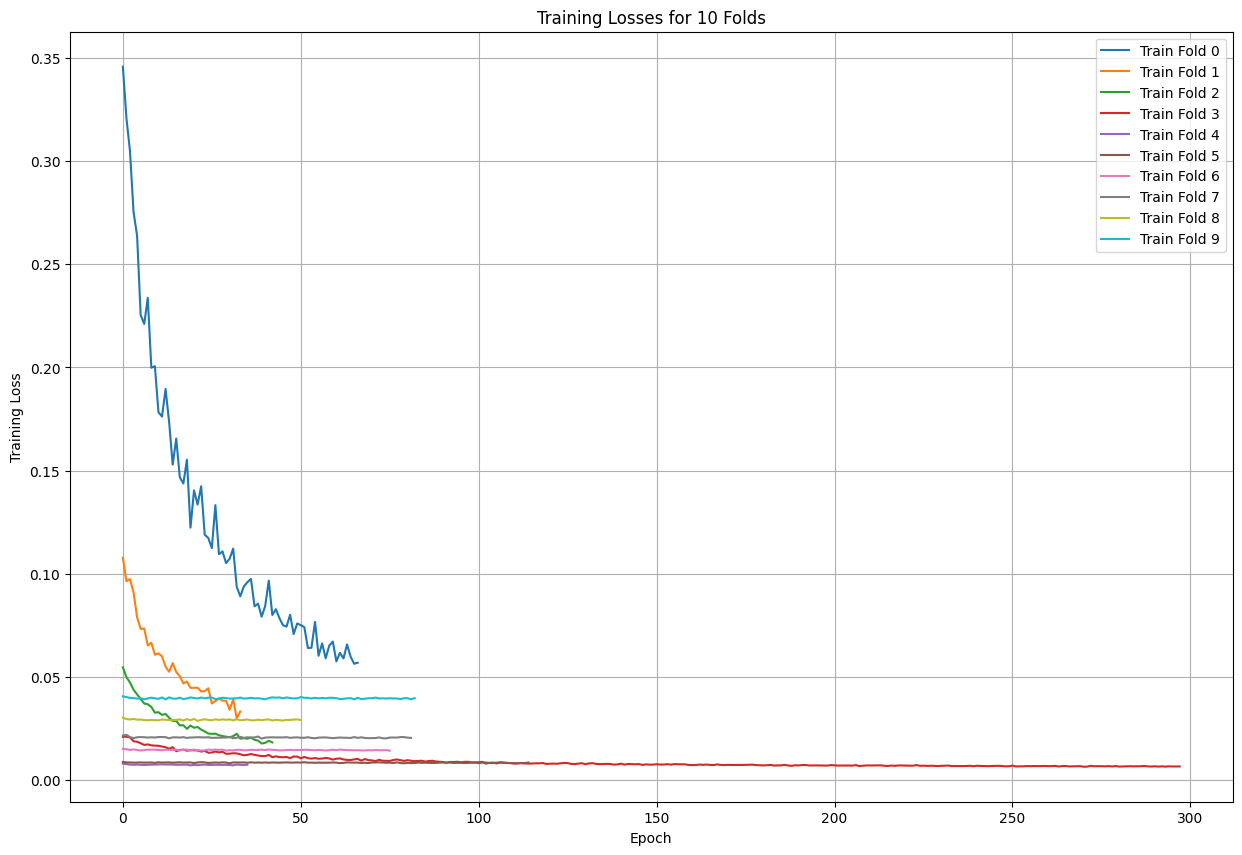

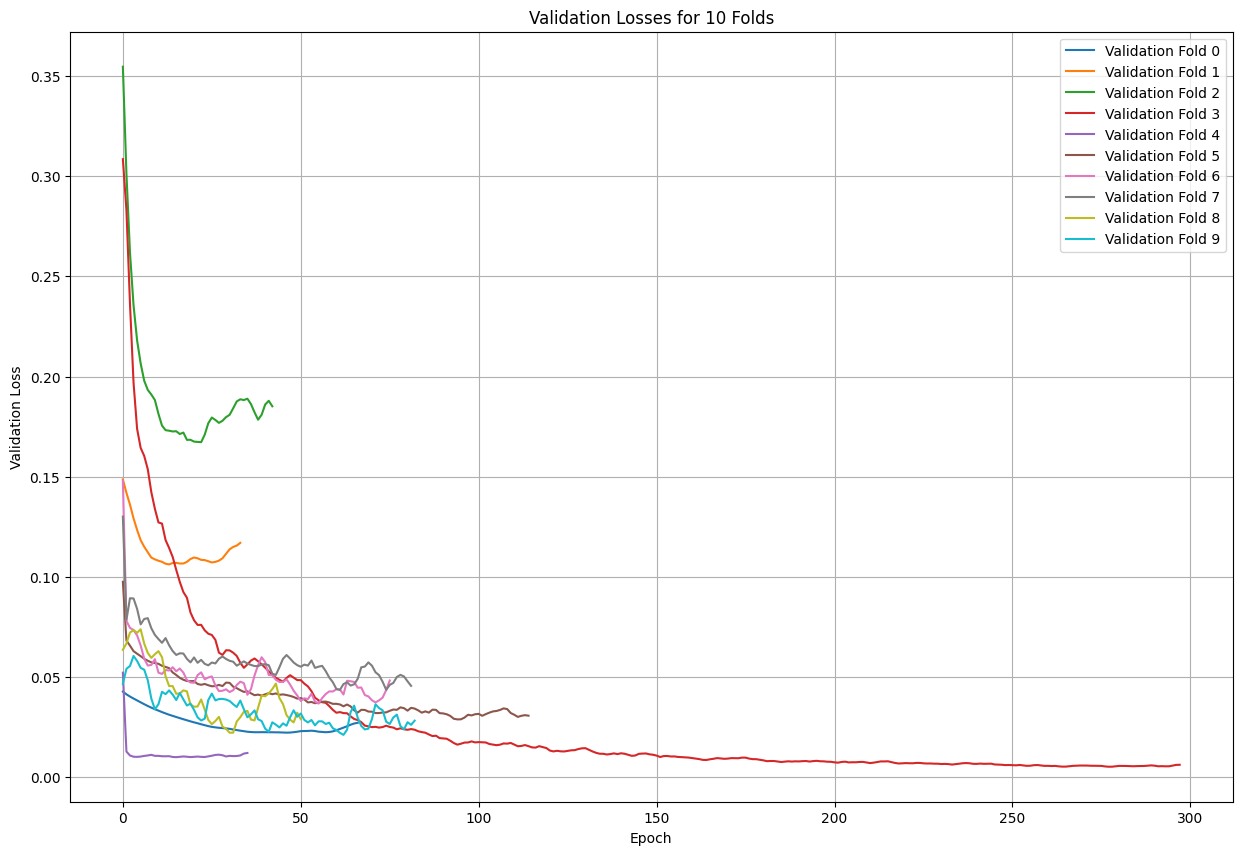

In [52]:
plt.figure(figsize=(15, 10))
for i in range(10):
    plt.plot(train_losses[i], label=f'Train Fold {i}')

plt.title('Training Losses for 10 Folds')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(15, 10))
for i in range(10):
    plt.plot(val_losses[i], label=f'Validation Fold {i}')

plt.title('Validation Losses for 10 Folds')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.grid()
plt.show()

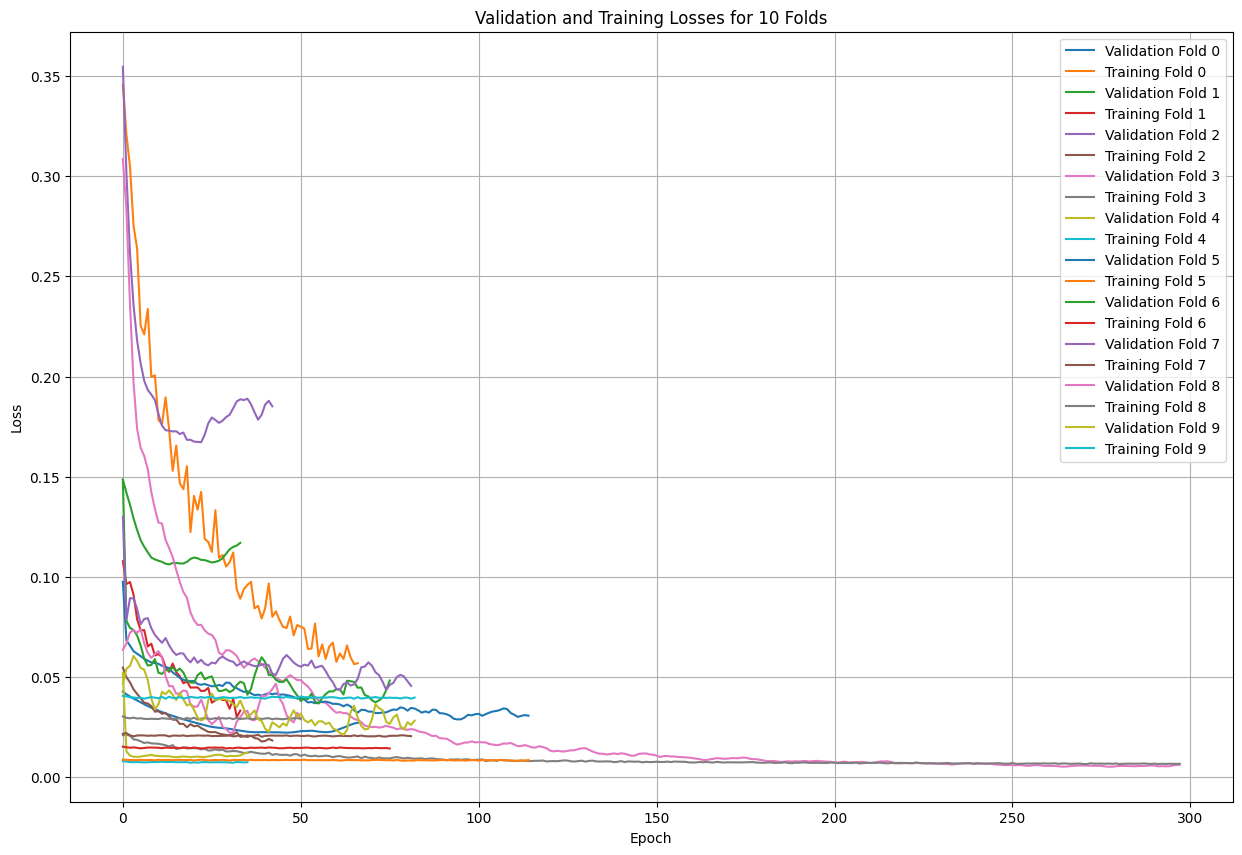

In [53]:
plt.figure(figsize=(15, 10))
for i in range(10):
    plt.plot(val_losses[i], label=f'Validation Fold {i}')
    plt.plot(train_losses[i], label=f'Training Fold {i}')

plt.title('Validation and Training Losses for 10 Folds')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()